In [1]:
# Import Required Libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
sys.path.insert(0, os.getcwd())
from data_loading import WaferDataLoader
from utility import (setup_model_and_loaders, hyperparameter_tuning, 
                     evaluate_model, train_model)
from models import SimpleNN
from config import SIMPLE_NN_TUNING_GRID

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ All libraries imported successfully!")
print(f"Device: {device}")

Helper functions defined successfully!
✓ All libraries imported successfully!
Device: cuda


## 1. Load and Prepare Data

In [2]:
# Load data using WaferDataLoader
print("Loading wafer defect dataset...")
loader = WaferDataLoader()

print(f"✓ Dataset loaded successfully!")
print(f"X shape: {loader.X.shape}")
print(f"y shape: {loader.y.shape}")
print(f"Number of classes: {loader.num_classes}")

# Get the data
X = loader.X.astype('float32')
y = loader.y

# Normalize data
X_min, X_max = X.min(), X.max()
X_normalized = (X - X_min) / (X_max - X_min) if X_max > X_min else X

print(f"\n✓ Normalization:")
print(f"  Original range: [{X_min}, {X_max}]")
print(f"  Normalized range: [{X_normalized.min():.4f}, {X_normalized.max():.4f}]")

# Split into train/val/test (70% / 15% / 15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✓ Data split complete:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(y)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(y)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(y)*100:.1f}%)")

Loading wafer defect dataset...
Loading dataset from kagglehub cache...
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38
✓ Dataset loaded successfully!
X shape: (38015, 52, 52)
y shape: (38015,)
Number of classes: 38

✓ Normalization:
  Original range: [0.0, 3.0]
  Normalized range: [0.0000, 1.0000]

✓ Data split complete:
  Training set: 26610 samples (70.0%)
  Validation set: 5702 samples (15.0%)
  Test set: 5703 samples (15.0%)


## 2. Hyperparameter Tuning Grid

In [3]:
# Display tuning grid
print("="*80)
print("SIMPLE NEURAL NETWORK - HYPERPARAMETER TUNING GRID".center(80))
print("="*80)
print(f"\nTuning Grid:")
for param, values in SIMPLE_NN_TUNING_GRID.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in SIMPLE_NN_TUNING_GRID.values()])
print(f"\nTotal combinations to evaluate: {total_combinations}")
print("="*80)

               SIMPLE NEURAL NETWORK - HYPERPARAMETER TUNING GRID               

Tuning Grid:
  learning_rate: [0.005, 0.001, 0.0005, 0.0001]
  batch_size: [32, 64, 128]
  num_epochs: [15, 20, 30]
  optimizer: ['adam', 'sgd']

Total combinations to evaluate: 72


## 3. Run Hyperparameter Tuning

In [4]:
# SimpleNN Hyperparameter Tuning
print("\n" + "="*80)
print("STARTING HYPERPARAMETER TUNING".center(80))
print("="*80)

simplenn_results = hyperparameter_tuning(
    SimpleNN, X_train, X_val, X_test, y_train, y_val, y_test,
    param_grid=SIMPLE_NN_TUNING_GRID,
    input_size=2704,
    num_classes=38,
    device=str(device),
    num_epochs=25,
    patience=5,
    verbose=True
)

print("\n" + "="*80)
print("TUNING COMPLETE".center(80))
print("="*80)

# Extract top 5
simplenn_top5 = simplenn_results['summary_df'].head(5).copy()
print("\nTop 5 Configurations:")
print(simplenn_top5[['learning_rate', 'batch_size', 'num_epochs', 'optimizer', 'Val_Acc', 'Test_Acc']].to_string())


                         STARTING HYPERPARAMETER TUNING                         

                  HYPERPARAMETER TUNING: Grid Search                  
Model: SimpleNN
Total combinations to evaluate: 72
Parameters: learning_rate, batch_size, num_epochs, optimizer


[1/72] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1145, Train Acc: 0.2048
  Val Loss: 3.0452, Val Acc: 0.2571
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3136, Train Acc: 0.3447
  Val Loss: 2.8020, Val Acc: 0.2971
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9609, Train Acc: 0.4307
  Val Loss: 2.5599, Val Acc: 0.3239
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7320, Train Acc: 0.4904
  Val Loss: 2.3837, Val Acc: 0.2855
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.4982, Train Acc: 0.5429
  Val Loss: 2.0898, Val Acc: 0.4081
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4180, Train Acc: 0.5721
  Val Loss: 2.1656, Val Acc: 0.3872
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.3036, Train Acc: 0.6008
  Val Loss: 1.9679, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.2283, Train Acc: 0.6283
  Val Loss: 2.4241, Val Acc: 0.3800
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.1528, Train Acc: 0.6476
  Val Loss: 2.2615, Val Acc: 0.4081
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.1323, Train Acc: 0.6585
  Val Loss: 1.9721, Val Acc: 0.4344
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.0668, Train Acc: 0.6812
  Val Loss: 2.7459, Val Acc: 0.3525
  Patience: 4/5


Epoch 12/15:
  Train Loss: 1.0193, Train Acc: 0.6905
  Val Loss: 2.3257, Val Acc: 0.3967
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 1.9679
Train Acc: 0.6905 | Val Acc: 0.3967 | Test Acc: 0.3924
✓ NEW BEST! (Val Acc: 0.3967)

[2/72] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9331, Train Acc: 0.1735
  Val Loss: 2.5565, Val Acc: 0.2133
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3172, Train Acc: 0.2814
  Val Loss: 2.2819, Val Acc: 0.2510
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0631, Train Acc: 0.3513
  Val Loss: 2.0372, Val Acc: 0.3273
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8961, Train Acc: 0.4099
  Val Loss: 1.9515, Val Acc: 0.3444
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7726, Train Acc: 0.4496
  Val Loss: 1.8554, Val Acc: 0.4102
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6637, Train Acc: 0.4965
  Val Loss: 1.8066, Val Acc: 0.3802
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5736, Train Acc: 0.5344
  Val Loss: 1.8311, Val Acc: 0.3634
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.5023, Train Acc: 0.5563
  Val Loss: 1.8224, Val Acc: 0.3818
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.4392, Train Acc: 0.5829
  Val Loss: 1.6855, Val Acc: 0.4272
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3795, Train Acc: 0.6090
  Val Loss: 1.6792, Val Acc: 0.4265
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3283, Train Acc: 0.6345
  Val Loss: 1.6638, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.2803, Train Acc: 0.6481
  Val Loss: 1.6369, Val Acc: 0.4320
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.2379, Train Acc: 0.6623
  Val Loss: 1.5701, Val Acc: 0.4828
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.1996, Train Acc: 0.6764
  Val Loss: 1.6034, Val Acc: 0.4469
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.1651, Train Acc: 0.6858
  Val Loss: 1.5462, Val Acc: 0.4781
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5462
Train Acc: 0.6858 | Val Acc: 0.4781 | Test Acc: 0.4845
✓ NEW BEST! (Val Acc: 0.4781)

[3/72] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1141, Train Acc: 0.2002
  Val Loss: 3.0014, Val Acc: 0.2327
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3475, Train Acc: 0.3440
  Val Loss: 2.6089, Val Acc: 0.2827
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9213, Train Acc: 0.4311
  Val Loss: 2.5498, Val Acc: 0.3485
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7034, Train Acc: 0.4942
  Val Loss: 2.5441, Val Acc: 0.3330
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5206, Train Acc: 0.5428
  Val Loss: 1.9888, Val Acc: 0.3797
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4654, Train Acc: 0.5624
  Val Loss: 2.5144, Val Acc: 0.3555
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.3300, Train Acc: 0.5993
  Val Loss: 2.1943, Val Acc: 0.3878
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.2613, Train Acc: 0.6179
  Val Loss: 2.0476, Val Acc: 0.4076
  Patience: 3/5


Epoch 9/20:
  Train Loss: 1.2211, Train Acc: 0.6321
  Val Loss: 2.1370, Val Acc: 0.4099
  Patience: 4/5


Epoch 10/20:
  Train Loss: 1.1245, Train Acc: 0.6589
  Val Loss: 2.7722, Val Acc: 0.3760
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 1.9888
Train Acc: 0.6589 | Val Acc: 0.3760 | Test Acc: 0.3770

[4/72] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9359, Train Acc: 0.1752
  Val Loss: 2.4846, Val Acc: 0.2438
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3200, Train Acc: 0.2832
  Val Loss: 2.2273, Val Acc: 0.2871
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0557, Train Acc: 0.3614
  Val Loss: 2.0678, Val Acc: 0.3244
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8979, Train Acc: 0.4048
  Val Loss: 1.9948, Val Acc: 0.3357
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7649, Train Acc: 0.4566
  Val Loss: 1.8553, Val Acc: 0.3837
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6616, Train Acc: 0.4933
  Val Loss: 1.8050, Val Acc: 0.4107
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5765, Train Acc: 0.5299
  Val Loss: 1.7714, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5092, Train Acc: 0.5523
  Val Loss: 1.7429, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4341, Train Acc: 0.5891
  Val Loss: 1.7212, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3825, Train Acc: 0.6033
  Val Loss: 1.7266, Val Acc: 0.4270
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.3217, Train Acc: 0.6322
  Val Loss: 1.6329, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2851, Train Acc: 0.6406
  Val Loss: 1.6133, Val Acc: 0.4311
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2466, Train Acc: 0.6564
  Val Loss: 1.6240, Val Acc: 0.4509
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.1965, Train Acc: 0.6784
  Val Loss: 1.5656, Val Acc: 0.4746
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.1580, Train Acc: 0.6952
  Val Loss: 1.5857, Val Acc: 0.4518
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.1271, Train Acc: 0.7031
  Val Loss: 1.5580, Val Acc: 0.4811
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.0911, Train Acc: 0.7200
  Val Loss: 1.5443, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0659, Train Acc: 0.7278
  Val Loss: 1.5451, Val Acc: 0.4618
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.0391, Train Acc: 0.7379
  Val Loss: 1.5142, Val Acc: 0.4754
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.0105, Train Acc: 0.7445
  Val Loss: 1.5230, Val Acc: 0.4704
  Patience: 1/5

Loaded best model with validation loss: 1.5142
Train Acc: 0.7445 | Val Acc: 0.4704 | Test Acc: 0.4762

[5/72] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1047, Train Acc: 0.2017
  Val Loss: 2.6136, Val Acc: 0.3218
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3014, Train Acc: 0.3440
  Val Loss: 2.2505, Val Acc: 0.3408
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9204, Train Acc: 0.4388
  Val Loss: 2.3162, Val Acc: 0.3723
  Patience: 1/5


Epoch 4/30:
  Train Loss: 1.7273, Train Acc: 0.4912
  Val Loss: 2.0418, Val Acc: 0.3804
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5295, Train Acc: 0.5388
  Val Loss: 2.0382, Val Acc: 0.3935
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4390, Train Acc: 0.5681
  Val Loss: 2.2705, Val Acc: 0.3590
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.3035, Train Acc: 0.6020
  Val Loss: 2.4563, Val Acc: 0.4069
  Patience: 2/5


Epoch 8/30:
  Train Loss: 1.2713, Train Acc: 0.6225
  Val Loss: 2.9213, Val Acc: 0.3541
  Patience: 3/5


Epoch 9/30:
  Train Loss: 1.2328, Train Acc: 0.6346
  Val Loss: 1.9885, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.0878, Train Acc: 0.6651
  Val Loss: 2.2027, Val Acc: 0.3722
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.0164, Train Acc: 0.6903
  Val Loss: 2.0433, Val Acc: 0.4437
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.0164, Train Acc: 0.6943
  Val Loss: 1.7697, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.9769, Train Acc: 0.6994
  Val Loss: 2.2596, Val Acc: 0.4295
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.8997, Train Acc: 0.7240
  Val Loss: 2.9949, Val Acc: 0.3918
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.8762, Train Acc: 0.7273
  Val Loss: 2.2240, Val Acc: 0.4298
  Patience: 3/5


Epoch 16/30:
  Train Loss: 0.8041, Train Acc: 0.7484
  Val Loss: 1.9365, Val Acc: 0.4616
  Patience: 4/5


Epoch 17/30:
  Train Loss: 0.8166, Train Acc: 0.7482
  Val Loss: 2.4847, Val Acc: 0.4134
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 1.7697
Train Acc: 0.7482 | Val Acc: 0.4134 | Test Acc: 0.4143

[6/72] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9302, Train Acc: 0.1748
  Val Loss: 2.5226, Val Acc: 0.2338
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3037, Train Acc: 0.2891
  Val Loss: 2.2740, Val Acc: 0.2790
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0659, Train Acc: 0.3483
  Val Loss: 2.0803, Val Acc: 0.3472
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8888, Train Acc: 0.4091
  Val Loss: 1.9337, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7662, Train Acc: 0.4557
  Val Loss: 1.9268, Val Acc: 0.3802
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6659, Train Acc: 0.4907
  Val Loss: 1.8299, Val Acc: 0.3841
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5793, Train Acc: 0.5275
  Val Loss: 1.8095, Val Acc: 0.3793
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5047, Train Acc: 0.5584
  Val Loss: 1.7647, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4431, Train Acc: 0.5802
  Val Loss: 1.6704, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3802, Train Acc: 0.6077
  Val Loss: 1.6669, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3234, Train Acc: 0.6303
  Val Loss: 1.6554, Val Acc: 0.4469
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2801, Train Acc: 0.6469
  Val Loss: 1.6522, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2409, Train Acc: 0.6572
  Val Loss: 1.5798, Val Acc: 0.4686
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.1963, Train Acc: 0.6785
  Val Loss: 1.5580, Val Acc: 0.4711
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1636, Train Acc: 0.6917
  Val Loss: 1.5583, Val Acc: 0.4655
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.1270, Train Acc: 0.7034
  Val Loss: 1.5906, Val Acc: 0.4542
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.0925, Train Acc: 0.7188
  Val Loss: 1.5273, Val Acc: 0.4823
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0609, Train Acc: 0.7317
  Val Loss: 1.5439, Val Acc: 0.4583
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0330, Train Acc: 0.7371
  Val Loss: 1.5078, Val Acc: 0.4783
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.0107, Train Acc: 0.7433
  Val Loss: 1.4871, Val Acc: 0.4916
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9891, Train Acc: 0.7514
  Val Loss: 1.5182, Val Acc: 0.4709
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.9624, Train Acc: 0.7641
  Val Loss: 1.4842, Val Acc: 0.4740
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9438, Train Acc: 0.7681
  Val Loss: 1.4513, Val Acc: 0.5028
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.9244, Train Acc: 0.7737
  Val Loss: 1.4727, Val Acc: 0.4830
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.9041, Train Acc: 0.7796
  Val Loss: 1.4751, Val Acc: 0.4891
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.8835, Train Acc: 0.7892
  Val Loss: 1.4612, Val Acc: 0.4865
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.8672, Train Acc: 0.7928
  Val Loss: 1.4716, Val Acc: 0.4879
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.8507, Train Acc: 0.7985
  Val Loss: 1.4529, Val Acc: 0.4923
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 1.4513
Train Acc: 0.7985 | Val Acc: 0.4923 | Test Acc: 0.4885
✓ NEW BEST! (Val Acc: 0.4923)

[7/72] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9542, Train Acc: 0.1965
  Val Loss: 2.3753, Val Acc: 0.2988
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1711, Train Acc: 0.3378
  Val Loss: 2.0554, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8353, Train Acc: 0.4233
  Val Loss: 2.0772, Val Acc: 0.3299
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.6302, Train Acc: 0.4837
  Val Loss: 1.7852, Val Acc: 0.3848
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.4921, Train Acc: 0.5285
  Val Loss: 1.8344, Val Acc: 0.4056
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.3364, Train Acc: 0.5749
  Val Loss: 1.8987, Val Acc: 0.4055
  Patience: 2/5


Epoch 7/15:
  Train Loss: 1.2351, Train Acc: 0.6034
  Val Loss: 1.9591, Val Acc: 0.3686
  Patience: 3/5


Epoch 8/15:
  Train Loss: 1.1776, Train Acc: 0.6223
  Val Loss: 1.6295, Val Acc: 0.4669
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.0666, Train Acc: 0.6596
  Val Loss: 1.8042, Val Acc: 0.4388
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.0087, Train Acc: 0.6791
  Val Loss: 1.9015, Val Acc: 0.4137
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.9609, Train Acc: 0.6882
  Val Loss: 1.6157, Val Acc: 0.4767
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 0.9091, Train Acc: 0.7067
  Val Loss: 1.8984, Val Acc: 0.3992
  Patience: 1/5


Epoch 13/15:
  Train Loss: 0.8492, Train Acc: 0.7230
  Val Loss: 1.7084, Val Acc: 0.4495
  Patience: 2/5


Epoch 14/15:
  Train Loss: 0.7890, Train Acc: 0.7440
  Val Loss: 1.6688, Val Acc: 0.4646
  Patience: 3/5


Epoch 15/15:
  Train Loss: 0.7530, Train Acc: 0.7564
  Val Loss: 1.6435, Val Acc: 0.4704
  Patience: 4/5

Loaded best model with validation loss: 1.6157
Train Acc: 0.7564 | Val Acc: 0.4704 | Test Acc: 0.4738

[8/72] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1221, Train Acc: 0.1547
  Val Loss: 2.7604, Val Acc: 0.1999
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.5637, Train Acc: 0.2528
  Val Loss: 2.4433, Val Acc: 0.2596
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3127, Train Acc: 0.3099
  Val Loss: 2.2926, Val Acc: 0.3330
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1478, Train Acc: 0.3578
  Val Loss: 2.1561, Val Acc: 0.3015
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0259, Train Acc: 0.3995
  Val Loss: 2.0833, Val Acc: 0.3553
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9320, Train Acc: 0.4327
  Val Loss: 1.9879, Val Acc: 0.3979
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8498, Train Acc: 0.4566
  Val Loss: 1.9442, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7819, Train Acc: 0.4821
  Val Loss: 1.8903, Val Acc: 0.4341
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7306, Train Acc: 0.5050
  Val Loss: 1.9043, Val Acc: 0.3921
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.6668, Train Acc: 0.5398
  Val Loss: 1.8330, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6211, Train Acc: 0.5498
  Val Loss: 1.8213, Val Acc: 0.4044
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5786, Train Acc: 0.5729
  Val Loss: 1.7991, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5336, Train Acc: 0.5918
  Val Loss: 1.7441, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4977, Train Acc: 0.6050
  Val Loss: 1.7113, Val Acc: 0.4570
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4584, Train Acc: 0.6183
  Val Loss: 1.7285, Val Acc: 0.4116
  Patience: 1/5

Loaded best model with validation loss: 1.7113
Train Acc: 0.6183 | Val Acc: 0.4116 | Test Acc: 0.4080

[9/72] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0169, Train Acc: 0.1982
  Val Loss: 2.9463, Val Acc: 0.2352
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2125, Train Acc: 0.3318
  Val Loss: 2.2946, Val Acc: 0.2974
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8749, Train Acc: 0.4087
  Val Loss: 2.2254, Val Acc: 0.3658
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5951, Train Acc: 0.4939
  Val Loss: 1.8604, Val Acc: 0.4125
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.4493, Train Acc: 0.5367
  Val Loss: 1.8941, Val Acc: 0.3385
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.3372, Train Acc: 0.5775
  Val Loss: 1.7669, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.2170, Train Acc: 0.6014
  Val Loss: 1.7054, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.1498, Train Acc: 0.6303
  Val Loss: 2.1827, Val Acc: 0.3935
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.0831, Train Acc: 0.6539
  Val Loss: 1.6742, Val Acc: 0.4649
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.0206, Train Acc: 0.6672
  Val Loss: 1.6538, Val Acc: 0.4414
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 0.9559, Train Acc: 0.6964
  Val Loss: 1.8508, Val Acc: 0.4248
  Patience: 1/5


Epoch 12/20:
  Train Loss: 0.8919, Train Acc: 0.7113
  Val Loss: 1.9543, Val Acc: 0.4141
  Patience: 2/5


Epoch 13/20:
  Train Loss: 0.8771, Train Acc: 0.7157
  Val Loss: 1.8575, Val Acc: 0.4330
  Patience: 3/5


Epoch 14/20:
  Train Loss: 0.8599, Train Acc: 0.7249
  Val Loss: 1.9635, Val Acc: 0.4369
  Patience: 4/5


Epoch 15/20:
  Train Loss: 0.7840, Train Acc: 0.7427
  Val Loss: 1.8428, Val Acc: 0.4306
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.6538
Train Acc: 0.7427 | Val Acc: 0.4306 | Test Acc: 0.4319

[10/72] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1372, Train Acc: 0.1463
  Val Loss: 2.7640, Val Acc: 0.1882
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5698, Train Acc: 0.2514
  Val Loss: 2.4613, Val Acc: 0.2960
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3108, Train Acc: 0.3082
  Val Loss: 2.2927, Val Acc: 0.3006
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1507, Train Acc: 0.3558
  Val Loss: 2.1516, Val Acc: 0.3087
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0293, Train Acc: 0.3962
  Val Loss: 2.0594, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9360, Train Acc: 0.4274
  Val Loss: 2.0183, Val Acc: 0.3558
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8566, Train Acc: 0.4568
  Val Loss: 1.9475, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7894, Train Acc: 0.4812
  Val Loss: 1.9125, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7238, Train Acc: 0.5131
  Val Loss: 1.8713, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6684, Train Acc: 0.5371
  Val Loss: 1.8481, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6199, Train Acc: 0.5553
  Val Loss: 1.7939, Val Acc: 0.4290
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5755, Train Acc: 0.5738
  Val Loss: 1.7891, Val Acc: 0.4139
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5352, Train Acc: 0.5918
  Val Loss: 1.7530, Val Acc: 0.4190
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4919, Train Acc: 0.6121
  Val Loss: 1.7261, Val Acc: 0.4181
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4593, Train Acc: 0.6219
  Val Loss: 1.6836, Val Acc: 0.4511
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4310, Train Acc: 0.6233
  Val Loss: 1.6834, Val Acc: 0.4519
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3954, Train Acc: 0.6409
  Val Loss: 1.6646, Val Acc: 0.4539
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.3633, Train Acc: 0.6613
  Val Loss: 1.6729, Val Acc: 0.4456
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.3384, Train Acc: 0.6648
  Val Loss: 1.6248, Val Acc: 0.4548
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3134, Train Acc: 0.6710
  Val Loss: 1.6343, Val Acc: 0.4551
  Patience: 1/5

Loaded best model with validation loss: 1.6248
Train Acc: 0.6710 | Val Acc: 0.4551 | Test Acc: 0.4496

[11/72] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9767, Train Acc: 0.1973
  Val Loss: 2.2588, Val Acc: 0.2860
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1366, Train Acc: 0.3412
  Val Loss: 2.2054, Val Acc: 0.2792
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8308, Train Acc: 0.4244
  Val Loss: 2.5013, Val Acc: 0.2774
  Patience: 1/5


Epoch 4/30:
  Train Loss: 1.6270, Train Acc: 0.4852
  Val Loss: 1.7702, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.4268, Train Acc: 0.5412
  Val Loss: 1.8858, Val Acc: 0.4013
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.3079, Train Acc: 0.5812
  Val Loss: 1.7636, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2500, Train Acc: 0.5981
  Val Loss: 1.9422, Val Acc: 0.3958
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.1415, Train Acc: 0.6346
  Val Loss: 1.6891, Val Acc: 0.4349
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.0485, Train Acc: 0.6611
  Val Loss: 1.7426, Val Acc: 0.4263
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.0002, Train Acc: 0.6779
  Val Loss: 1.7113, Val Acc: 0.4291
  Patience: 2/5


Epoch 11/30:
  Train Loss: 0.9594, Train Acc: 0.6848
  Val Loss: 1.9470, Val Acc: 0.3983
  Patience: 3/5


Epoch 12/30:
  Train Loss: 0.9015, Train Acc: 0.7081
  Val Loss: 1.7142, Val Acc: 0.4481
  Patience: 4/5


Epoch 13/30:
  Train Loss: 0.8316, Train Acc: 0.7321
  Val Loss: 1.8001, Val Acc: 0.4288
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.6891
Train Acc: 0.7321 | Val Acc: 0.4288 | Test Acc: 0.4291

[12/72] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1259, Train Acc: 0.1537
  Val Loss: 2.7672, Val Acc: 0.2450
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5630, Train Acc: 0.2608
  Val Loss: 2.4625, Val Acc: 0.2441
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3079, Train Acc: 0.3132
  Val Loss: 2.2662, Val Acc: 0.3215
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1447, Train Acc: 0.3603
  Val Loss: 2.1699, Val Acc: 0.3104
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0331, Train Acc: 0.3906
  Val Loss: 2.0684, Val Acc: 0.3655
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9347, Train Acc: 0.4247
  Val Loss: 2.0091, Val Acc: 0.3888
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8551, Train Acc: 0.4543
  Val Loss: 1.9599, Val Acc: 0.3681
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7839, Train Acc: 0.4865
  Val Loss: 1.9143, Val Acc: 0.3723
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7203, Train Acc: 0.5204
  Val Loss: 1.8674, Val Acc: 0.3823
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6718, Train Acc: 0.5325
  Val Loss: 1.8273, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6264, Train Acc: 0.5472
  Val Loss: 1.8056, Val Acc: 0.3886
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5749, Train Acc: 0.5760
  Val Loss: 1.7662, Val Acc: 0.4362
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5407, Train Acc: 0.5826
  Val Loss: 1.7357, Val Acc: 0.4337
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4919, Train Acc: 0.6096
  Val Loss: 1.7243, Val Acc: 0.4444
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4617, Train Acc: 0.6160
  Val Loss: 1.7100, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4265, Train Acc: 0.6299
  Val Loss: 1.6868, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3921, Train Acc: 0.6476
  Val Loss: 1.6846, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3655, Train Acc: 0.6549
  Val Loss: 1.6724, Val Acc: 0.4479
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3364, Train Acc: 0.6707
  Val Loss: 1.6476, Val Acc: 0.4555
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3071, Train Acc: 0.6782
  Val Loss: 1.6318, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.2856, Train Acc: 0.6861
  Val Loss: 1.6076, Val Acc: 0.4569
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.2614, Train Acc: 0.6972
  Val Loss: 1.5848, Val Acc: 0.4751
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.2396, Train Acc: 0.7036
  Val Loss: 1.5729, Val Acc: 0.4951
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2181, Train Acc: 0.7108
  Val Loss: 1.5640, Val Acc: 0.4832
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1946, Train Acc: 0.7182
  Val Loss: 1.5484, Val Acc: 0.5042
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.1771, Train Acc: 0.7222
  Val Loss: 1.5478, Val Acc: 0.4919
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.1586, Train Acc: 0.7285
  Val Loss: 1.5573, Val Acc: 0.4825
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.1400, Train Acc: 0.7336
  Val Loss: 1.5303, Val Acc: 0.4761
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1212, Train Acc: 0.7413
  Val Loss: 1.5164, Val Acc: 0.5063
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1060, Train Acc: 0.7443
  Val Loss: 1.5128, Val Acc: 0.4935
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5128
Train Acc: 0.7443 | Val Acc: 0.4935 | Test Acc: 0.4966
✓ NEW BEST! (Val Acc: 0.4935)

[13/72] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0170, Train Acc: 0.1824
  Val Loss: 2.5714, Val Acc: 0.2459
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1772, Train Acc: 0.3124
  Val Loss: 2.1610, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9005, Train Acc: 0.3888
  Val Loss: 2.0342, Val Acc: 0.3250
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6691, Train Acc: 0.4666
  Val Loss: 1.9260, Val Acc: 0.3534
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5348, Train Acc: 0.5101
  Val Loss: 1.7215, Val Acc: 0.4412
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4072, Train Acc: 0.5537
  Val Loss: 1.9058, Val Acc: 0.4035
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.3248, Train Acc: 0.5810
  Val Loss: 1.6360, Val Acc: 0.4465
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.2254, Train Acc: 0.6115
  Val Loss: 1.6426, Val Acc: 0.4125
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.1535, Train Acc: 0.6443
  Val Loss: 1.6854, Val Acc: 0.4270
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.0358, Train Acc: 0.6810
  Val Loss: 1.5143, Val Acc: 0.4737
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.0198, Train Acc: 0.6822
  Val Loss: 1.6088, Val Acc: 0.4467
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.9577, Train Acc: 0.7080
  Val Loss: 1.6632, Val Acc: 0.4383
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.9474, Train Acc: 0.7073
  Val Loss: 1.6016, Val Acc: 0.4435
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.8622, Train Acc: 0.7350
  Val Loss: 1.5676, Val Acc: 0.4448
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.8336, Train Acc: 0.7513
  Val Loss: 1.4951, Val Acc: 0.4795
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4951
Train Acc: 0.7513 | Val Acc: 0.4795 | Test Acc: 0.4776

[14/72] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3136, Train Acc: 0.1205
  Val Loss: 3.0183, Val Acc: 0.2094
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8452, Train Acc: 0.2243
  Val Loss: 2.7364, Val Acc: 0.2145
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6014, Train Acc: 0.2679
  Val Loss: 2.5330, Val Acc: 0.2787
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.4344, Train Acc: 0.3059
  Val Loss: 2.4020, Val Acc: 0.3043
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.3153, Train Acc: 0.3365
  Val Loss: 2.3194, Val Acc: 0.3015
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.2179, Train Acc: 0.3655
  Val Loss: 2.2397, Val Acc: 0.3423
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.1401, Train Acc: 0.3948
  Val Loss: 2.1764, Val Acc: 0.3534
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0747, Train Acc: 0.4139
  Val Loss: 2.1382, Val Acc: 0.3337
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.0154, Train Acc: 0.4281
  Val Loss: 2.0764, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.9609, Train Acc: 0.4579
  Val Loss: 2.0506, Val Acc: 0.3260
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.9185, Train Acc: 0.4664
  Val Loss: 2.0152, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.8741, Train Acc: 0.4871
  Val Loss: 1.9907, Val Acc: 0.3828
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.8362, Train Acc: 0.5051
  Val Loss: 1.9565, Val Acc: 0.4153
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.8024, Train Acc: 0.5124
  Val Loss: 1.9306, Val Acc: 0.4055
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7649, Train Acc: 0.5328
  Val Loss: 1.8938, Val Acc: 0.4190
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8938
Train Acc: 0.5328 | Val Acc: 0.4190 | Test Acc: 0.4142

[15/72] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0606, Train Acc: 0.1828
  Val Loss: 2.3768, Val Acc: 0.2948
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1647, Train Acc: 0.3229
  Val Loss: 2.1089, Val Acc: 0.3351
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8943, Train Acc: 0.3941
  Val Loss: 2.0272, Val Acc: 0.3287
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6700, Train Acc: 0.4613
  Val Loss: 1.8441, Val Acc: 0.3946
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5137, Train Acc: 0.5166
  Val Loss: 1.7375, Val Acc: 0.3976
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4009, Train Acc: 0.5630
  Val Loss: 1.7337, Val Acc: 0.4204
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.3045, Train Acc: 0.5930
  Val Loss: 1.5552, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.2064, Train Acc: 0.6200
  Val Loss: 1.5374, Val Acc: 0.4649
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.1379, Train Acc: 0.6393
  Val Loss: 1.6532, Val Acc: 0.4234
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.0889, Train Acc: 0.6570
  Val Loss: 1.5953, Val Acc: 0.4476
  Patience: 2/5


Epoch 11/20:
  Train Loss: 0.9992, Train Acc: 0.6902
  Val Loss: 1.6142, Val Acc: 0.4546
  Patience: 3/5


Epoch 12/20:
  Train Loss: 0.9557, Train Acc: 0.7095
  Val Loss: 1.6071, Val Acc: 0.4381
  Patience: 4/5


Epoch 13/20:
  Train Loss: 0.9233, Train Acc: 0.7167
  Val Loss: 1.6597, Val Acc: 0.4362
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.5374
Train Acc: 0.7167 | Val Acc: 0.4362 | Test Acc: 0.4382

[16/72] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3165, Train Acc: 0.1264
  Val Loss: 3.0308, Val Acc: 0.1917
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8484, Train Acc: 0.2216
  Val Loss: 2.7237, Val Acc: 0.2408
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.6010, Train Acc: 0.2637
  Val Loss: 2.5574, Val Acc: 0.2673
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.4343, Train Acc: 0.3110
  Val Loss: 2.4191, Val Acc: 0.2682
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.3139, Train Acc: 0.3475
  Val Loss: 2.3208, Val Acc: 0.3053
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.2193, Train Acc: 0.3625
  Val Loss: 2.2432, Val Acc: 0.3329
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.1421, Train Acc: 0.3945
  Val Loss: 2.1812, Val Acc: 0.3350
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.0724, Train Acc: 0.4189
  Val Loss: 2.1262, Val Acc: 0.3246
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.0153, Train Acc: 0.4354
  Val Loss: 2.0815, Val Acc: 0.3488
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9660, Train Acc: 0.4517
  Val Loss: 2.0311, Val Acc: 0.4249
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.9195, Train Acc: 0.4691
  Val Loss: 2.0111, Val Acc: 0.3643
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.8740, Train Acc: 0.4947
  Val Loss: 1.9730, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.8350, Train Acc: 0.5122
  Val Loss: 1.9494, Val Acc: 0.3867
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.7977, Train Acc: 0.5254
  Val Loss: 1.9179, Val Acc: 0.4169
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7663, Train Acc: 0.5275
  Val Loss: 1.9113, Val Acc: 0.3886
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.7364, Train Acc: 0.5473
  Val Loss: 1.8771, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7079, Train Acc: 0.5556
  Val Loss: 1.8550, Val Acc: 0.4344
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.6807, Train Acc: 0.5668
  Val Loss: 1.8419, Val Acc: 0.4486
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6481, Train Acc: 0.5848
  Val Loss: 1.8216, Val Acc: 0.4548
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6244, Train Acc: 0.5868
  Val Loss: 1.8021, Val Acc: 0.4607
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8021
Train Acc: 0.5868 | Val Acc: 0.4607 | Test Acc: 0.4554

[17/72] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0268, Train Acc: 0.1786
  Val Loss: 2.5256, Val Acc: 0.2182
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2243, Train Acc: 0.3093
  Val Loss: 2.1839, Val Acc: 0.2876
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8808, Train Acc: 0.3973
  Val Loss: 2.0681, Val Acc: 0.3171
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6756, Train Acc: 0.4643
  Val Loss: 1.8976, Val Acc: 0.3678
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5176, Train Acc: 0.5156
  Val Loss: 1.7718, Val Acc: 0.4081
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4202, Train Acc: 0.5445
  Val Loss: 1.7399, Val Acc: 0.4076
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.2903, Train Acc: 0.5972
  Val Loss: 1.7037, Val Acc: 0.4446
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.2052, Train Acc: 0.6251
  Val Loss: 1.6547, Val Acc: 0.4519
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.1517, Train Acc: 0.6331
  Val Loss: 1.7243, Val Acc: 0.4076
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.1156, Train Acc: 0.6521
  Val Loss: 1.6669, Val Acc: 0.4377
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.0157, Train Acc: 0.6867
  Val Loss: 1.5533, Val Acc: 0.4653
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 0.9656, Train Acc: 0.6982
  Val Loss: 1.5460, Val Acc: 0.4655
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 0.9188, Train Acc: 0.7182
  Val Loss: 1.7591, Val Acc: 0.4400
  Patience: 1/5


Epoch 14/30:
  Train Loss: 0.8609, Train Acc: 0.7372
  Val Loss: 1.6802, Val Acc: 0.4409
  Patience: 2/5


Epoch 15/30:
  Train Loss: 0.8161, Train Acc: 0.7534
  Val Loss: 1.4726, Val Acc: 0.4926
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.7896, Train Acc: 0.7603
  Val Loss: 1.6077, Val Acc: 0.4539
  Patience: 1/5


Epoch 17/30:
  Train Loss: 0.8026, Train Acc: 0.7611
  Val Loss: 1.5030, Val Acc: 0.4861
  Patience: 2/5


Epoch 18/30:
  Train Loss: 0.7443, Train Acc: 0.7753
  Val Loss: 1.6802, Val Acc: 0.4739
  Patience: 3/5


Epoch 19/30:
  Train Loss: 0.7432, Train Acc: 0.7723
  Val Loss: 1.7883, Val Acc: 0.4021
  Patience: 4/5


Epoch 20/30:
  Train Loss: 0.6987, Train Acc: 0.7873
  Val Loss: 1.4837, Val Acc: 0.4935
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 1.4726
Train Acc: 0.7873 | Val Acc: 0.4935 | Test Acc: 0.4913

[18/72] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3184, Train Acc: 0.1198
  Val Loss: 3.0481, Val Acc: 0.2115
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.8496, Train Acc: 0.2233
  Val Loss: 2.7221, Val Acc: 0.2217
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5992, Train Acc: 0.2719
  Val Loss: 2.5434, Val Acc: 0.2569
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.4366, Train Acc: 0.3082
  Val Loss: 2.4082, Val Acc: 0.3394
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.3148, Train Acc: 0.3442
  Val Loss: 2.3059, Val Acc: 0.3050
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.2193, Train Acc: 0.3683
  Val Loss: 2.2486, Val Acc: 0.2957
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.1409, Train Acc: 0.3971
  Val Loss: 2.1891, Val Acc: 0.3081
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0719, Train Acc: 0.4176
  Val Loss: 2.1303, Val Acc: 0.3416
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.0157, Train Acc: 0.4386
  Val Loss: 2.0937, Val Acc: 0.3627
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.9650, Train Acc: 0.4574
  Val Loss: 2.0446, Val Acc: 0.3764
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.9191, Train Acc: 0.4753
  Val Loss: 2.0128, Val Acc: 0.3883
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.8748, Train Acc: 0.4940
  Val Loss: 1.9758, Val Acc: 0.3995
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.8354, Train Acc: 0.5098
  Val Loss: 1.9484, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.7983, Train Acc: 0.5257
  Val Loss: 1.9156, Val Acc: 0.4179
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7657, Train Acc: 0.5374
  Val Loss: 1.9102, Val Acc: 0.3881
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.7304, Train Acc: 0.5528
  Val Loss: 1.8784, Val Acc: 0.4160
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7016, Train Acc: 0.5648
  Val Loss: 1.8644, Val Acc: 0.4081
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6803, Train Acc: 0.5654
  Val Loss: 1.8463, Val Acc: 0.4377
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6498, Train Acc: 0.5827
  Val Loss: 1.8169, Val Acc: 0.4507
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6207, Train Acc: 0.6019
  Val Loss: 1.7979, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5981, Train Acc: 0.6089
  Val Loss: 1.7880, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5774, Train Acc: 0.6132
  Val Loss: 1.7683, Val Acc: 0.4535
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5554, Train Acc: 0.6171
  Val Loss: 1.7517, Val Acc: 0.4711
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.5344, Train Acc: 0.6282
  Val Loss: 1.7642, Val Acc: 0.4313
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.5167, Train Acc: 0.6330
  Val Loss: 1.7331, Val Acc: 0.4565
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4943, Train Acc: 0.6428
  Val Loss: 1.7192, Val Acc: 0.4553
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4758, Train Acc: 0.6442
  Val Loss: 1.7216, Val Acc: 0.4448
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.4551, Train Acc: 0.6625
  Val Loss: 1.6975, Val Acc: 0.4844
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.4389, Train Acc: 0.6595
  Val Loss: 1.6924, Val Acc: 0.4763
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.4239, Train Acc: 0.6679
  Val Loss: 1.6765, Val Acc: 0.4825
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6765
Train Acc: 0.6679 | Val Acc: 0.4825 | Test Acc: 0.4782

[19/72] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8548, Train Acc: 0.1820
  Val Loss: 2.4142, Val Acc: 0.2490
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2137, Train Acc: 0.3066
  Val Loss: 2.1578, Val Acc: 0.2776
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9325, Train Acc: 0.3857
  Val Loss: 2.0085, Val Acc: 0.3078
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7536, Train Acc: 0.4455
  Val Loss: 1.8458, Val Acc: 0.3674
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6253, Train Acc: 0.4957
  Val Loss: 1.8339, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5015, Train Acc: 0.5392
  Val Loss: 1.7212, Val Acc: 0.4227
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4141, Train Acc: 0.5682
  Val Loss: 1.6536, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.3213, Train Acc: 0.6039
  Val Loss: 1.6276, Val Acc: 0.4448
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.2527, Train Acc: 0.6277
  Val Loss: 1.6786, Val Acc: 0.4002
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.1877, Train Acc: 0.6520
  Val Loss: 1.5500, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.1369, Train Acc: 0.6696
  Val Loss: 1.5666, Val Acc: 0.4662
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.0763, Train Acc: 0.6888
  Val Loss: 1.4836, Val Acc: 0.4882
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.0223, Train Acc: 0.7101
  Val Loss: 1.5511, Val Acc: 0.4523
  Patience: 1/5


Epoch 14/15:
  Train Loss: 0.9757, Train Acc: 0.7275
  Val Loss: 1.4874, Val Acc: 0.4593
  Patience: 2/5


Epoch 15/15:
  Train Loss: 0.9464, Train Acc: 0.7332
  Val Loss: 1.4974, Val Acc: 0.4695
  Patience: 3/5

Loaded best model with validation loss: 1.4836
Train Acc: 0.7332 | Val Acc: 0.4695 | Test Acc: 0.4813

[20/72] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3516, Train Acc: 0.1135
  Val Loss: 3.0973, Val Acc: 0.2224
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9350, Train Acc: 0.2072
  Val Loss: 2.8245, Val Acc: 0.1810
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6964, Train Acc: 0.2549
  Val Loss: 2.6183, Val Acc: 0.2629
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.5355, Train Acc: 0.2939
  Val Loss: 2.5108, Val Acc: 0.2778
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.4144, Train Acc: 0.3192
  Val Loss: 2.4070, Val Acc: 0.2969
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.3174, Train Acc: 0.3537
  Val Loss: 2.3259, Val Acc: 0.3159
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.2378, Train Acc: 0.3713
  Val Loss: 2.2596, Val Acc: 0.3274
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.1714, Train Acc: 0.3935
  Val Loss: 2.2100, Val Acc: 0.3264
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.1144, Train Acc: 0.4109
  Val Loss: 2.1595, Val Acc: 0.3506
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.0597, Train Acc: 0.4313
  Val Loss: 2.1253, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.0142, Train Acc: 0.4446
  Val Loss: 2.0847, Val Acc: 0.3704
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.9725, Train Acc: 0.4658
  Val Loss: 2.0609, Val Acc: 0.3706
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.9325, Train Acc: 0.4781
  Val Loss: 2.0493, Val Acc: 0.3408
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.8971, Train Acc: 0.4908
  Val Loss: 2.0087, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.8635, Train Acc: 0.5109
  Val Loss: 1.9679, Val Acc: 0.4118
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9679
Train Acc: 0.5109 | Val Acc: 0.4118 | Test Acc: 0.4059

[21/72] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8671, Train Acc: 0.1798
  Val Loss: 2.4521, Val Acc: 0.2434
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2046, Train Acc: 0.3124
  Val Loss: 2.1359, Val Acc: 0.3153
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9468, Train Acc: 0.3865
  Val Loss: 2.0058, Val Acc: 0.3750
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7657, Train Acc: 0.4424
  Val Loss: 1.8851, Val Acc: 0.3913
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6227, Train Acc: 0.4943
  Val Loss: 1.7738, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5061, Train Acc: 0.5395
  Val Loss: 1.7157, Val Acc: 0.4390
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4027, Train Acc: 0.5755
  Val Loss: 1.6107, Val Acc: 0.4791
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3165, Train Acc: 0.6050
  Val Loss: 1.6666, Val Acc: 0.4083
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.2531, Train Acc: 0.6284
  Val Loss: 1.5892, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.1883, Train Acc: 0.6520
  Val Loss: 1.5898, Val Acc: 0.4698
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.1328, Train Acc: 0.6705
  Val Loss: 1.5507, Val Acc: 0.4607
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.0743, Train Acc: 0.6923
  Val Loss: 1.5525, Val Acc: 0.4579
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.0276, Train Acc: 0.7075
  Val Loss: 1.5077, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 0.9822, Train Acc: 0.7239
  Val Loss: 1.5123, Val Acc: 0.4728
  Patience: 1/5


Epoch 15/20:
  Train Loss: 0.9534, Train Acc: 0.7284
  Val Loss: 1.4822, Val Acc: 0.4651
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9226, Train Acc: 0.7357
  Val Loss: 1.4736, Val Acc: 0.4993
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.8834, Train Acc: 0.7525
  Val Loss: 1.5090, Val Acc: 0.4665
  Patience: 1/5


Epoch 18/20:
  Train Loss: 0.8493, Train Acc: 0.7632
  Val Loss: 1.5111, Val Acc: 0.4653
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.8208, Train Acc: 0.7740
  Val Loss: 1.4572, Val Acc: 0.4833
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.7825, Train Acc: 0.7915
  Val Loss: 1.4660, Val Acc: 0.4712
  Patience: 1/5

Loaded best model with validation loss: 1.4572
Train Acc: 0.7915 | Val Acc: 0.4712 | Test Acc: 0.4787

[22/72] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3468, Train Acc: 0.1159
  Val Loss: 3.0935, Val Acc: 0.1645
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.9320, Train Acc: 0.2124
  Val Loss: 2.8092, Val Acc: 0.2485
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.6938, Train Acc: 0.2624
  Val Loss: 2.6296, Val Acc: 0.2660
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.5316, Train Acc: 0.2963
  Val Loss: 2.5040, Val Acc: 0.3004
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.4125, Train Acc: 0.3227
  Val Loss: 2.3978, Val Acc: 0.3164
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.3164, Train Acc: 0.3480
  Val Loss: 2.3289, Val Acc: 0.3378
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.2372, Train Acc: 0.3697
  Val Loss: 2.2630, Val Acc: 0.3655
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.1710, Train Acc: 0.3941
  Val Loss: 2.2050, Val Acc: 0.3430
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.1125, Train Acc: 0.4124
  Val Loss: 2.1681, Val Acc: 0.3346
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.0599, Train Acc: 0.4313
  Val Loss: 2.1195, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.0133, Train Acc: 0.4542
  Val Loss: 2.0811, Val Acc: 0.3736
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.9713, Train Acc: 0.4648
  Val Loss: 2.0553, Val Acc: 0.3843
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9338, Train Acc: 0.4806
  Val Loss: 2.0138, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.8977, Train Acc: 0.4926
  Val Loss: 1.9939, Val Acc: 0.3904
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.8624, Train Acc: 0.5101
  Val Loss: 1.9740, Val Acc: 0.3818
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.8330, Train Acc: 0.5225
  Val Loss: 1.9530, Val Acc: 0.3678
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.8035, Train Acc: 0.5294
  Val Loss: 1.9355, Val Acc: 0.4221
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.7757, Train Acc: 0.5409
  Val Loss: 1.9163, Val Acc: 0.3895
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.7483, Train Acc: 0.5565
  Val Loss: 1.8970, Val Acc: 0.4100
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7255, Train Acc: 0.5648
  Val Loss: 1.8693, Val Acc: 0.4218
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8693
Train Acc: 0.5648 | Val Acc: 0.4218 | Test Acc: 0.4100

[23/72] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8515, Train Acc: 0.1849
  Val Loss: 2.4198, Val Acc: 0.2297
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2176, Train Acc: 0.3062
  Val Loss: 2.2592, Val Acc: 0.3139
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9484, Train Acc: 0.3885
  Val Loss: 1.9420, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7628, Train Acc: 0.4405
  Val Loss: 1.9097, Val Acc: 0.3767
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6223, Train Acc: 0.4971
  Val Loss: 1.8038, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5031, Train Acc: 0.5355
  Val Loss: 1.7261, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.3971, Train Acc: 0.5797
  Val Loss: 1.6840, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3253, Train Acc: 0.6033
  Val Loss: 1.6278, Val Acc: 0.4456
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.2508, Train Acc: 0.6289
  Val Loss: 1.7014, Val Acc: 0.3934
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.1865, Train Acc: 0.6502
  Val Loss: 1.5753, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.1335, Train Acc: 0.6688
  Val Loss: 1.6004, Val Acc: 0.4318
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.0859, Train Acc: 0.6866
  Val Loss: 1.6161, Val Acc: 0.4349
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.0286, Train Acc: 0.7069
  Val Loss: 1.4774, Val Acc: 0.4872
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 0.9865, Train Acc: 0.7194
  Val Loss: 1.4739, Val Acc: 0.4921
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 0.9489, Train Acc: 0.7317
  Val Loss: 1.6515, Val Acc: 0.4509
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.9157, Train Acc: 0.7401
  Val Loss: 1.4487, Val Acc: 0.4996
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.8779, Train Acc: 0.7567
  Val Loss: 1.4866, Val Acc: 0.4832
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.8427, Train Acc: 0.7690
  Val Loss: 1.5591, Val Acc: 0.4533
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.8182, Train Acc: 0.7755
  Val Loss: 1.4153, Val Acc: 0.4961
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.7955, Train Acc: 0.7800
  Val Loss: 1.4587, Val Acc: 0.4932
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.7620, Train Acc: 0.7937
  Val Loss: 1.4359, Val Acc: 0.5009
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.7411, Train Acc: 0.7995
  Val Loss: 1.5183, Val Acc: 0.4833
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.7149, Train Acc: 0.8089
  Val Loss: 1.4294, Val Acc: 0.5042
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.6967, Train Acc: 0.8151
  Val Loss: 1.4703, Val Acc: 0.4856
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 1.4153
Train Acc: 0.8151 | Val Acc: 0.4856 | Test Acc: 0.4752

[24/72] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3504, Train Acc: 0.1188
  Val Loss: 3.1029, Val Acc: 0.1654
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9344, Train Acc: 0.2116
  Val Loss: 2.8062, Val Acc: 0.2296
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6940, Train Acc: 0.2610
  Val Loss: 2.6301, Val Acc: 0.2311
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.5334, Train Acc: 0.2958
  Val Loss: 2.5070, Val Acc: 0.2838
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.4142, Train Acc: 0.3265
  Val Loss: 2.3976, Val Acc: 0.3020
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.3184, Train Acc: 0.3469
  Val Loss: 2.3253, Val Acc: 0.3236
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2393, Train Acc: 0.3724
  Val Loss: 2.2695, Val Acc: 0.3255
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.1708, Train Acc: 0.3929
  Val Loss: 2.2194, Val Acc: 0.3432
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.1142, Train Acc: 0.4132
  Val Loss: 2.1613, Val Acc: 0.3637
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.0618, Train Acc: 0.4300
  Val Loss: 2.1243, Val Acc: 0.3814
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.0159, Train Acc: 0.4442
  Val Loss: 2.0924, Val Acc: 0.3722
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.9719, Train Acc: 0.4628
  Val Loss: 2.0511, Val Acc: 0.3676
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.9345, Train Acc: 0.4762
  Val Loss: 2.0290, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8984, Train Acc: 0.4948
  Val Loss: 1.9971, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.8638, Train Acc: 0.4981
  Val Loss: 1.9798, Val Acc: 0.3876
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.8346, Train Acc: 0.5186
  Val Loss: 1.9455, Val Acc: 0.4255
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.8020, Train Acc: 0.5312
  Val Loss: 1.9350, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.7735, Train Acc: 0.5480
  Val Loss: 1.9036, Val Acc: 0.4372
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.7494, Train Acc: 0.5565
  Val Loss: 1.8968, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7236, Train Acc: 0.5645
  Val Loss: 1.8803, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.7004, Train Acc: 0.5725
  Val Loss: 1.8588, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6782, Train Acc: 0.5769
  Val Loss: 1.8434, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.6561, Train Acc: 0.5899
  Val Loss: 1.8276, Val Acc: 0.4172
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.6347, Train Acc: 0.5985
  Val Loss: 1.8167, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.6160, Train Acc: 0.6106
  Val Loss: 1.7960, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5955, Train Acc: 0.6193
  Val Loss: 1.7808, Val Acc: 0.4770
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5768, Train Acc: 0.6201
  Val Loss: 1.7846, Val Acc: 0.4553
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.5597, Train Acc: 0.6295
  Val Loss: 1.7702, Val Acc: 0.4621
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.5407, Train Acc: 0.6365
  Val Loss: 1.7490, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.5248, Train Acc: 0.6448
  Val Loss: 1.7554, Val Acc: 0.4491
  Patience: 1/5

Loaded best model with validation loss: 1.7490
Train Acc: 0.6448 | Val Acc: 0.4491 | Test Acc: 0.4406

[25/72] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9697, Train Acc: 0.1672
  Val Loss: 2.5691, Val Acc: 0.2646
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3357, Train Acc: 0.2903
  Val Loss: 2.2309, Val Acc: 0.3034
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0809, Train Acc: 0.3536
  Val Loss: 2.0952, Val Acc: 0.2988
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9010, Train Acc: 0.4187
  Val Loss: 1.9570, Val Acc: 0.3930
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7693, Train Acc: 0.4646
  Val Loss: 1.8954, Val Acc: 0.3872
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6574, Train Acc: 0.5019
  Val Loss: 1.8263, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5633, Train Acc: 0.5420
  Val Loss: 1.8365, Val Acc: 0.3667
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.4818, Train Acc: 0.5693
  Val Loss: 1.7139, Val Acc: 0.4267
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4084, Train Acc: 0.5989
  Val Loss: 1.6351, Val Acc: 0.4632
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3573, Train Acc: 0.6159
  Val Loss: 1.5868, Val Acc: 0.4763
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.2917, Train Acc: 0.6470
  Val Loss: 1.5870, Val Acc: 0.4914
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.2382, Train Acc: 0.6653
  Val Loss: 1.6015, Val Acc: 0.4497
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.1961, Train Acc: 0.6734
  Val Loss: 1.6017, Val Acc: 0.4579
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.1488, Train Acc: 0.6883
  Val Loss: 1.5177, Val Acc: 0.4783
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.1140, Train Acc: 0.7002
  Val Loss: 1.5321, Val Acc: 0.4735
  Patience: 1/5

Loaded best model with validation loss: 1.5177
Train Acc: 0.7002 | Val Acc: 0.4735 | Test Acc: 0.4712

[26/72] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4740, Train Acc: 0.0840
  Val Loss: 3.3166, Val Acc: 0.1440
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1954, Train Acc: 0.1606
  Val Loss: 3.0912, Val Acc: 0.2199
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.9936, Train Acc: 0.2102
  Val Loss: 2.9239, Val Acc: 0.2276
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.8447, Train Acc: 0.2462
  Val Loss: 2.7952, Val Acc: 0.2778
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.7264, Train Acc: 0.2700
  Val Loss: 2.7025, Val Acc: 0.2410
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.6322, Train Acc: 0.2999
  Val Loss: 2.6133, Val Acc: 0.2510
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.5515, Train Acc: 0.3151
  Val Loss: 2.5484, Val Acc: 0.3118
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.4845, Train Acc: 0.3268
  Val Loss: 2.4920, Val Acc: 0.2831
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.4239, Train Acc: 0.3434
  Val Loss: 2.4420, Val Acc: 0.3213
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.3702, Train Acc: 0.3653
  Val Loss: 2.3952, Val Acc: 0.3137
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.3230, Train Acc: 0.3780
  Val Loss: 2.3487, Val Acc: 0.3371
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.2805, Train Acc: 0.3868
  Val Loss: 2.3174, Val Acc: 0.3418
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.2411, Train Acc: 0.3969
  Val Loss: 2.2839, Val Acc: 0.3339
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.2047, Train Acc: 0.4144
  Val Loss: 2.2519, Val Acc: 0.3485
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.1714, Train Acc: 0.4302
  Val Loss: 2.2259, Val Acc: 0.3609
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2259
Train Acc: 0.4302 | Val Acc: 0.3609 | Test Acc: 0.3651

[27/72] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9568, Train Acc: 0.1761
  Val Loss: 2.5260, Val Acc: 0.2473
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3326, Train Acc: 0.2858
  Val Loss: 2.2453, Val Acc: 0.2848
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0768, Train Acc: 0.3594
  Val Loss: 2.0317, Val Acc: 0.3529
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9003, Train Acc: 0.4112
  Val Loss: 1.9345, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7611, Train Acc: 0.4649
  Val Loss: 1.8888, Val Acc: 0.3464
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6562, Train Acc: 0.5045
  Val Loss: 1.7729, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5633, Train Acc: 0.5429
  Val Loss: 1.7611, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4817, Train Acc: 0.5692
  Val Loss: 1.7121, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4158, Train Acc: 0.5949
  Val Loss: 1.6591, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3493, Train Acc: 0.6211
  Val Loss: 1.6120, Val Acc: 0.4754
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2912, Train Acc: 0.6396
  Val Loss: 1.6007, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2445, Train Acc: 0.6547
  Val Loss: 1.5436, Val Acc: 0.4916
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1903, Train Acc: 0.6782
  Val Loss: 1.5370, Val Acc: 0.4728
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1516, Train Acc: 0.6884
  Val Loss: 1.5515, Val Acc: 0.4828
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.1103, Train Acc: 0.6997
  Val Loss: 1.5367, Val Acc: 0.4674
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.0699, Train Acc: 0.7191
  Val Loss: 1.4994, Val Acc: 0.4856
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.0311, Train Acc: 0.7303
  Val Loss: 1.4671, Val Acc: 0.4946
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0039, Train Acc: 0.7446
  Val Loss: 1.4737, Val Acc: 0.4891
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.9796, Train Acc: 0.7425
  Val Loss: 1.4998, Val Acc: 0.4844
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.9443, Train Acc: 0.7569
  Val Loss: 1.4495, Val Acc: 0.4858
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4495
Train Acc: 0.7569 | Val Acc: 0.4858 | Test Acc: 0.4880

[28/72] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4731, Train Acc: 0.0792
  Val Loss: 3.3194, Val Acc: 0.0812
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1934, Train Acc: 0.1610
  Val Loss: 3.0862, Val Acc: 0.2143
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.9932, Train Acc: 0.2091
  Val Loss: 2.9195, Val Acc: 0.2176
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.8441, Train Acc: 0.2428
  Val Loss: 2.8016, Val Acc: 0.2264
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7283, Train Acc: 0.2673
  Val Loss: 2.6986, Val Acc: 0.2520
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.6339, Train Acc: 0.2860
  Val Loss: 2.6154, Val Acc: 0.2617
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.5531, Train Acc: 0.3068
  Val Loss: 2.5455, Val Acc: 0.2857
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.4841, Train Acc: 0.3277
  Val Loss: 2.4923, Val Acc: 0.3013
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.4257, Train Acc: 0.3438
  Val Loss: 2.4376, Val Acc: 0.2917
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.3726, Train Acc: 0.3603
  Val Loss: 2.3897, Val Acc: 0.3259
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.3242, Train Acc: 0.3784
  Val Loss: 2.3517, Val Acc: 0.3174
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.2824, Train Acc: 0.3920
  Val Loss: 2.3154, Val Acc: 0.3548
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.2416, Train Acc: 0.4018
  Val Loss: 2.2839, Val Acc: 0.3476
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.2077, Train Acc: 0.4113
  Val Loss: 2.2507, Val Acc: 0.3485
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1725, Train Acc: 0.4214
  Val Loss: 2.2321, Val Acc: 0.3513
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.1415, Train Acc: 0.4360
  Val Loss: 2.2018, Val Acc: 0.3523
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.1122, Train Acc: 0.4398
  Val Loss: 2.1738, Val Acc: 0.3427
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.0844, Train Acc: 0.4532
  Val Loss: 2.1513, Val Acc: 0.3769
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.0593, Train Acc: 0.4633
  Val Loss: 2.1331, Val Acc: 0.3681
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.0347, Train Acc: 0.4760
  Val Loss: 2.1135, Val Acc: 0.3855
  ✓ New best validation loss!

Loaded best model with validation loss: 2.1135
Train Acc: 0.4760 | Val Acc: 0.3855 | Test Acc: 0.3756

[29/72] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9495, Train Acc: 0.1756
  Val Loss: 2.5202, Val Acc: 0.2392
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3323, Train Acc: 0.2899
  Val Loss: 2.2360, Val Acc: 0.3136
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0695, Train Acc: 0.3590
  Val Loss: 2.0568, Val Acc: 0.3520
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9041, Train Acc: 0.4103
  Val Loss: 2.0184, Val Acc: 0.3380
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7634, Train Acc: 0.4613
  Val Loss: 1.8851, Val Acc: 0.4002
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6567, Train Acc: 0.5028
  Val Loss: 1.7992, Val Acc: 0.3911
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5606, Train Acc: 0.5433
  Val Loss: 1.7215, Val Acc: 0.4277
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4845, Train Acc: 0.5731
  Val Loss: 1.6946, Val Acc: 0.4563
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4146, Train Acc: 0.5944
  Val Loss: 1.7149, Val Acc: 0.4074
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.3473, Train Acc: 0.6242
  Val Loss: 1.6473, Val Acc: 0.4541
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.2895, Train Acc: 0.6404
  Val Loss: 1.5786, Val Acc: 0.4691
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2392, Train Acc: 0.6579
  Val Loss: 1.5440, Val Acc: 0.4898
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1989, Train Acc: 0.6719
  Val Loss: 1.5782, Val Acc: 0.4605
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.1478, Train Acc: 0.6899
  Val Loss: 1.5345, Val Acc: 0.4721
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1038, Train Acc: 0.7105
  Val Loss: 1.5204, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.0687, Train Acc: 0.7160
  Val Loss: 1.5182, Val Acc: 0.4847
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0400, Train Acc: 0.7210
  Val Loss: 1.5616, Val Acc: 0.4558
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.0056, Train Acc: 0.7394
  Val Loss: 1.4597, Val Acc: 0.4977
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9758, Train Acc: 0.7430
  Val Loss: 1.4659, Val Acc: 0.4854
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.9412, Train Acc: 0.7600
  Val Loss: 1.4458, Val Acc: 0.4954
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9207, Train Acc: 0.7653
  Val Loss: 1.4774, Val Acc: 0.4828
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.8914, Train Acc: 0.7733
  Val Loss: 1.4451, Val Acc: 0.5070
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.8684, Train Acc: 0.7795
  Val Loss: 1.4463, Val Acc: 0.4993
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.8472, Train Acc: 0.7855
  Val Loss: 1.3932, Val Acc: 0.5135
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8227, Train Acc: 0.7939
  Val Loss: 1.4233, Val Acc: 0.5000
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.8014, Train Acc: 0.7994
  Val Loss: 1.4046, Val Acc: 0.5054
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.7873, Train Acc: 0.8050
  Val Loss: 1.4176, Val Acc: 0.5051
  Patience: 3/5


Epoch 28/30:
  Train Loss: 0.7724, Train Acc: 0.8066
  Val Loss: 1.4293, Val Acc: 0.5005
  Patience: 4/5


Epoch 29/30:
  Train Loss: 0.7449, Train Acc: 0.8221
  Val Loss: 1.3772, Val Acc: 0.5186
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.7304, Train Acc: 0.8237
  Val Loss: 1.3899, Val Acc: 0.5128
  Patience: 1/5

Loaded best model with validation loss: 1.3772
Train Acc: 0.8237 | Val Acc: 0.5128 | Test Acc: 0.5103
✓ NEW BEST! (Val Acc: 0.5128)

[30/72] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4699, Train Acc: 0.0820
  Val Loss: 3.3154, Val Acc: 0.1028
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1890, Train Acc: 0.1610
  Val Loss: 3.0881, Val Acc: 0.1843
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9920, Train Acc: 0.2107
  Val Loss: 2.9207, Val Acc: 0.2447
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8423, Train Acc: 0.2476
  Val Loss: 2.7975, Val Acc: 0.2448
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.7253, Train Acc: 0.2663
  Val Loss: 2.6964, Val Acc: 0.2550
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.6299, Train Acc: 0.2915
  Val Loss: 2.6161, Val Acc: 0.2418
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.5510, Train Acc: 0.3147
  Val Loss: 2.5490, Val Acc: 0.2692
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.4828, Train Acc: 0.3306
  Val Loss: 2.4886, Val Acc: 0.2880
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.4240, Train Acc: 0.3446
  Val Loss: 2.4511, Val Acc: 0.2664
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.3718, Train Acc: 0.3615
  Val Loss: 2.3941, Val Acc: 0.3180
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.3234, Train Acc: 0.3732
  Val Loss: 2.3563, Val Acc: 0.3190
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.2797, Train Acc: 0.3854
  Val Loss: 2.3128, Val Acc: 0.3278
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.2403, Train Acc: 0.4041
  Val Loss: 2.2861, Val Acc: 0.3192
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.2044, Train Acc: 0.4118
  Val Loss: 2.2508, Val Acc: 0.3634
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.1712, Train Acc: 0.4222
  Val Loss: 2.2307, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1400, Train Acc: 0.4306
  Val Loss: 2.2000, Val Acc: 0.3571
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.1114, Train Acc: 0.4475
  Val Loss: 2.1752, Val Acc: 0.3718
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.0837, Train Acc: 0.4531
  Val Loss: 2.1509, Val Acc: 0.3722
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.0578, Train Acc: 0.4715
  Val Loss: 2.1316, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.0343, Train Acc: 0.4716
  Val Loss: 2.1123, Val Acc: 0.4014
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.0097, Train Acc: 0.4864
  Val Loss: 2.0943, Val Acc: 0.3823
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.9873, Train Acc: 0.4880
  Val Loss: 2.0841, Val Acc: 0.3807
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.9665, Train Acc: 0.4936
  Val Loss: 2.0556, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.9477, Train Acc: 0.5024
  Val Loss: 2.0454, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.9290, Train Acc: 0.5103
  Val Loss: 2.0286, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.9088, Train Acc: 0.5245
  Val Loss: 2.0188, Val Acc: 0.3844
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.8914, Train Acc: 0.5365
  Val Loss: 2.0005, Val Acc: 0.4074
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.8740, Train Acc: 0.5333
  Val Loss: 1.9900, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.8581, Train Acc: 0.5434
  Val Loss: 1.9763, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.8409, Train Acc: 0.5488
  Val Loss: 1.9621, Val Acc: 0.4421
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9621
Train Acc: 0.5488 | Val Acc: 0.4421 | Test Acc: 0.4408

[31/72] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0633, Train Acc: 0.1626
  Val Loss: 2.6666, Val Acc: 0.2631
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4777, Train Acc: 0.2721
  Val Loss: 2.3600, Val Acc: 0.2632
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2185, Train Acc: 0.3326
  Val Loss: 2.2120, Val Acc: 0.2669
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0548, Train Acc: 0.3880
  Val Loss: 2.0634, Val Acc: 0.3353
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9240, Train Acc: 0.4300
  Val Loss: 1.9894, Val Acc: 0.3492
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8235, Train Acc: 0.4637
  Val Loss: 1.9325, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7309, Train Acc: 0.5039
  Val Loss: 1.8476, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6577, Train Acc: 0.5261
  Val Loss: 1.8462, Val Acc: 0.4065
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5916, Train Acc: 0.5495
  Val Loss: 1.7915, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5360, Train Acc: 0.5719
  Val Loss: 1.7335, Val Acc: 0.4423
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4773, Train Acc: 0.5982
  Val Loss: 1.7167, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4267, Train Acc: 0.6168
  Val Loss: 1.6725, Val Acc: 0.4467
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3881, Train Acc: 0.6218
  Val Loss: 1.6566, Val Acc: 0.4586
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3413, Train Acc: 0.6423
  Val Loss: 1.6447, Val Acc: 0.4446
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2976, Train Acc: 0.6635
  Val Loss: 1.6403, Val Acc: 0.4439
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6403
Train Acc: 0.6635 | Val Acc: 0.4439 | Test Acc: 0.4478

[32/72] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5416, Train Acc: 0.0621
  Val Loss: 3.4511, Val Acc: 0.0784
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.3758, Train Acc: 0.1027
  Val Loss: 3.3062, Val Acc: 0.1538
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.2375, Train Acc: 0.1510
  Val Loss: 3.1799, Val Acc: 0.1552
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.1218, Train Acc: 0.1893
  Val Loss: 3.0794, Val Acc: 0.1992
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.0255, Train Acc: 0.2109
  Val Loss: 2.9911, Val Acc: 0.1999
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.9398, Train Acc: 0.2281
  Val Loss: 2.9146, Val Acc: 0.2664
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.8663, Train Acc: 0.2474
  Val Loss: 2.8455, Val Acc: 0.2404
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.8011, Train Acc: 0.2714
  Val Loss: 2.7902, Val Acc: 0.2461
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7435, Train Acc: 0.2752
  Val Loss: 2.7407, Val Acc: 0.2664
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.6912, Train Acc: 0.2955
  Val Loss: 2.6919, Val Acc: 0.2780
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.6454, Train Acc: 0.3038
  Val Loss: 2.6488, Val Acc: 0.2601
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.6006, Train Acc: 0.3117
  Val Loss: 2.6073, Val Acc: 0.3036
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.5611, Train Acc: 0.3367
  Val Loss: 2.5745, Val Acc: 0.2848
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.5249, Train Acc: 0.3306
  Val Loss: 2.5430, Val Acc: 0.2873
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.4905, Train Acc: 0.3481
  Val Loss: 2.5104, Val Acc: 0.3025
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5104
Train Acc: 0.3481 | Val Acc: 0.3025 | Test Acc: 0.2997

[33/72] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0830, Train Acc: 0.1563
  Val Loss: 2.7041, Val Acc: 0.2103
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4896, Train Acc: 0.2644
  Val Loss: 2.3838, Val Acc: 0.2706
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.2285, Train Acc: 0.3306
  Val Loss: 2.1856, Val Acc: 0.2892
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0524, Train Acc: 0.3882
  Val Loss: 2.0954, Val Acc: 0.3365
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9255, Train Acc: 0.4272
  Val Loss: 1.9718, Val Acc: 0.3881
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8184, Train Acc: 0.4661
  Val Loss: 1.9018, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7382, Train Acc: 0.4954
  Val Loss: 1.8723, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6629, Train Acc: 0.5262
  Val Loss: 1.8182, Val Acc: 0.4298
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5870, Train Acc: 0.5613
  Val Loss: 1.8028, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5291, Train Acc: 0.5817
  Val Loss: 1.7211, Val Acc: 0.4614
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4689, Train Acc: 0.6069
  Val Loss: 1.7028, Val Acc: 0.4270
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4257, Train Acc: 0.6181
  Val Loss: 1.6746, Val Acc: 0.4449
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3764, Train Acc: 0.6392
  Val Loss: 1.6259, Val Acc: 0.4649
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3391, Train Acc: 0.6447
  Val Loss: 1.5976, Val Acc: 0.4777
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2912, Train Acc: 0.6655
  Val Loss: 1.5991, Val Acc: 0.4684
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.2617, Train Acc: 0.6694
  Val Loss: 1.5848, Val Acc: 0.4770
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.2283, Train Acc: 0.6865
  Val Loss: 1.5686, Val Acc: 0.4890
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.1867, Train Acc: 0.7036
  Val Loss: 1.5419, Val Acc: 0.4835
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.1660, Train Acc: 0.7048
  Val Loss: 1.5046, Val Acc: 0.5065
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.1234, Train Acc: 0.7274
  Val Loss: 1.5282, Val Acc: 0.4918
  Patience: 1/5

Loaded best model with validation loss: 1.5046
Train Acc: 0.7274 | Val Acc: 0.4918 | Test Acc: 0.4903

[34/72] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5419, Train Acc: 0.0618
  Val Loss: 3.4570, Val Acc: 0.0900
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.3772, Train Acc: 0.1014
  Val Loss: 3.3056, Val Acc: 0.1421
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.2383, Train Acc: 0.1470
  Val Loss: 3.1849, Val Acc: 0.1855
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.1236, Train Acc: 0.1904
  Val Loss: 3.0787, Val Acc: 0.1962
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.0247, Train Acc: 0.2153
  Val Loss: 2.9925, Val Acc: 0.2022
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.9409, Train Acc: 0.2283
  Val Loss: 2.9139, Val Acc: 0.2624
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.8678, Train Acc: 0.2459
  Val Loss: 2.8492, Val Acc: 0.2436
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.8025, Train Acc: 0.2671
  Val Loss: 2.7899, Val Acc: 0.2320
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.7439, Train Acc: 0.2759
  Val Loss: 2.7401, Val Acc: 0.2573
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.6915, Train Acc: 0.2885
  Val Loss: 2.6917, Val Acc: 0.2617
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.6441, Train Acc: 0.3048
  Val Loss: 2.6471, Val Acc: 0.2692
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.6015, Train Acc: 0.3109
  Val Loss: 2.6117, Val Acc: 0.3006
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.5609, Train Acc: 0.3417
  Val Loss: 2.5764, Val Acc: 0.3022
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.5250, Train Acc: 0.3407
  Val Loss: 2.5415, Val Acc: 0.3262
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.4907, Train Acc: 0.3458
  Val Loss: 2.5138, Val Acc: 0.3041
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.4596, Train Acc: 0.3591
  Val Loss: 2.4843, Val Acc: 0.2825
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.4294, Train Acc: 0.3673
  Val Loss: 2.4566, Val Acc: 0.3267
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.4006, Train Acc: 0.3785
  Val Loss: 2.4318, Val Acc: 0.3446
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.3753, Train Acc: 0.3870
  Val Loss: 2.4099, Val Acc: 0.3259
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.3497, Train Acc: 0.3872
  Val Loss: 2.3870, Val Acc: 0.3330
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3870
Train Acc: 0.3872 | Val Acc: 0.3330 | Test Acc: 0.3330

[35/72] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0619, Train Acc: 0.1663
  Val Loss: 2.6784, Val Acc: 0.2350
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4719, Train Acc: 0.2758
  Val Loss: 2.3585, Val Acc: 0.2981
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2199, Train Acc: 0.3398
  Val Loss: 2.2274, Val Acc: 0.2845
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0504, Train Acc: 0.3820
  Val Loss: 2.0784, Val Acc: 0.3465
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9267, Train Acc: 0.4216
  Val Loss: 2.0142, Val Acc: 0.3571
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8294, Train Acc: 0.4601
  Val Loss: 1.9271, Val Acc: 0.4270
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7303, Train Acc: 0.5033
  Val Loss: 1.8366, Val Acc: 0.4165
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6456, Train Acc: 0.5485
  Val Loss: 1.7971, Val Acc: 0.4144
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5889, Train Acc: 0.5581
  Val Loss: 1.7612, Val Acc: 0.4542
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5328, Train Acc: 0.5759
  Val Loss: 1.7233, Val Acc: 0.4370
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4702, Train Acc: 0.6052
  Val Loss: 1.7351, Val Acc: 0.4327
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.4314, Train Acc: 0.6108
  Val Loss: 1.6533, Val Acc: 0.4621
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3713, Train Acc: 0.6427
  Val Loss: 1.6605, Val Acc: 0.4509
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.3275, Train Acc: 0.6564
  Val Loss: 1.5869, Val Acc: 0.5044
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2885, Train Acc: 0.6739
  Val Loss: 1.5903, Val Acc: 0.4726
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.2557, Train Acc: 0.6814
  Val Loss: 1.5635, Val Acc: 0.4826
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2220, Train Acc: 0.6885
  Val Loss: 1.5620, Val Acc: 0.4669
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1885, Train Acc: 0.6998
  Val Loss: 1.5546, Val Acc: 0.4933
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.1595, Train Acc: 0.7138
  Val Loss: 1.5524, Val Acc: 0.4723
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.1285, Train Acc: 0.7195
  Val Loss: 1.5138, Val Acc: 0.4937
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1023, Train Acc: 0.7313
  Val Loss: 1.5104, Val Acc: 0.4788
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.0655, Train Acc: 0.7472
  Val Loss: 1.4835, Val Acc: 0.4860
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0491, Train Acc: 0.7437
  Val Loss: 1.4892, Val Acc: 0.4996
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.0179, Train Acc: 0.7605
  Val Loss: 1.4487, Val Acc: 0.5228
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.0015, Train Acc: 0.7629
  Val Loss: 1.4478, Val Acc: 0.5063
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9778, Train Acc: 0.7698
  Val Loss: 1.4605, Val Acc: 0.4851
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9631, Train Acc: 0.7676
  Val Loss: 1.4671, Val Acc: 0.4902
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.9419, Train Acc: 0.7751
  Val Loss: 1.4346, Val Acc: 0.5021
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9232, Train Acc: 0.7832
  Val Loss: 1.4333, Val Acc: 0.5125
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9006, Train Acc: 0.7927
  Val Loss: 1.4124, Val Acc: 0.5156
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4124
Train Acc: 0.7927 | Val Acc: 0.5156 | Test Acc: 0.5038
✓ NEW BEST! (Val Acc: 0.5156)

[36/72] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5432, Train Acc: 0.0596
  Val Loss: 3.4569, Val Acc: 0.0924
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.3775, Train Acc: 0.1037
  Val Loss: 3.3065, Val Acc: 0.1049
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2400, Train Acc: 0.1449
  Val Loss: 3.1805, Val Acc: 0.1955
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.1241, Train Acc: 0.1818
  Val Loss: 3.0784, Val Acc: 0.2124
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.0242, Train Acc: 0.2136
  Val Loss: 2.9883, Val Acc: 0.2347
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.9408, Train Acc: 0.2307
  Val Loss: 2.9137, Val Acc: 0.2462
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.8681, Train Acc: 0.2516
  Val Loss: 2.8480, Val Acc: 0.2373
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.8018, Train Acc: 0.2634
  Val Loss: 2.7905, Val Acc: 0.2399
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.7438, Train Acc: 0.2782
  Val Loss: 2.7378, Val Acc: 0.2610
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.6924, Train Acc: 0.2886
  Val Loss: 2.6914, Val Acc: 0.2675
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.6446, Train Acc: 0.3031
  Val Loss: 2.6480, Val Acc: 0.2515
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.6009, Train Acc: 0.3121
  Val Loss: 2.6069, Val Acc: 0.2895
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.5621, Train Acc: 0.3234
  Val Loss: 2.5719, Val Acc: 0.2790
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.5252, Train Acc: 0.3383
  Val Loss: 2.5414, Val Acc: 0.2897
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.4917, Train Acc: 0.3519
  Val Loss: 2.5113, Val Acc: 0.3153
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.4602, Train Acc: 0.3608
  Val Loss: 2.4844, Val Acc: 0.3267
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.4302, Train Acc: 0.3623
  Val Loss: 2.4539, Val Acc: 0.3267
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.4015, Train Acc: 0.3800
  Val Loss: 2.4305, Val Acc: 0.3257
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.3751, Train Acc: 0.3906
  Val Loss: 2.4106, Val Acc: 0.3244
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.3505, Train Acc: 0.3928
  Val Loss: 2.3841, Val Acc: 0.3392
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.3263, Train Acc: 0.4008
  Val Loss: 2.3642, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.3040, Train Acc: 0.4101
  Val Loss: 2.3464, Val Acc: 0.3311
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.2832, Train Acc: 0.4068
  Val Loss: 2.3287, Val Acc: 0.3448
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.2626, Train Acc: 0.4159
  Val Loss: 2.3104, Val Acc: 0.3495
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.2428, Train Acc: 0.4267
  Val Loss: 2.2943, Val Acc: 0.3437
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.2240, Train Acc: 0.4222
  Val Loss: 2.2787, Val Acc: 0.3476
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.2064, Train Acc: 0.4362
  Val Loss: 2.2593, Val Acc: 0.3686
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.1893, Train Acc: 0.4422
  Val Loss: 2.2437, Val Acc: 0.3778
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.1714, Train Acc: 0.4496
  Val Loss: 2.2309, Val Acc: 0.3897
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.1565, Train Acc: 0.4546
  Val Loss: 2.2171, Val Acc: 0.3897
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2171
Train Acc: 0.4546 | Val Acc: 0.3897 | Test Acc: 0.3873

[37/72] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0070, Train Acc: 0.1683
  Val Loss: 2.6008, Val Acc: 0.2434
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4074, Train Acc: 0.2789
  Val Loss: 2.3026, Val Acc: 0.3274
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1537, Train Acc: 0.3414
  Val Loss: 2.1829, Val Acc: 0.3122
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9754, Train Acc: 0.4031
  Val Loss: 2.0174, Val Acc: 0.3373
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8548, Train Acc: 0.4435
  Val Loss: 1.9672, Val Acc: 0.3509
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7474, Train Acc: 0.4800
  Val Loss: 1.8768, Val Acc: 0.3602
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6587, Train Acc: 0.5154
  Val Loss: 1.8136, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5799, Train Acc: 0.5515
  Val Loss: 1.8119, Val Acc: 0.3955
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5147, Train Acc: 0.5724
  Val Loss: 1.7355, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4485, Train Acc: 0.5999
  Val Loss: 1.6781, Val Acc: 0.4449
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3881, Train Acc: 0.6209
  Val Loss: 1.6520, Val Acc: 0.4660
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3433, Train Acc: 0.6346
  Val Loss: 1.6468, Val Acc: 0.4269
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.2940, Train Acc: 0.6542
  Val Loss: 1.6160, Val Acc: 0.4623
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2500, Train Acc: 0.6719
  Val Loss: 1.5625, Val Acc: 0.4767
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2052, Train Acc: 0.6878
  Val Loss: 1.5392, Val Acc: 0.4805
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5392
Train Acc: 0.6878 | Val Acc: 0.4805 | Test Acc: 0.4713

[38/72] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4699, Train Acc: 0.0824
  Val Loss: 3.3129, Val Acc: 0.0961
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1912, Train Acc: 0.1609
  Val Loss: 3.0833, Val Acc: 0.1734
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.9919, Train Acc: 0.2106
  Val Loss: 2.9265, Val Acc: 0.2376
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.8435, Train Acc: 0.2425
  Val Loss: 2.8008, Val Acc: 0.2508
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.7272, Train Acc: 0.2718
  Val Loss: 2.6968, Val Acc: 0.2462
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.6302, Train Acc: 0.2903
  Val Loss: 2.6145, Val Acc: 0.2534
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.5524, Train Acc: 0.3076
  Val Loss: 2.5472, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.4842, Train Acc: 0.3254
  Val Loss: 2.4879, Val Acc: 0.3118
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.4234, Train Acc: 0.3475
  Val Loss: 2.4423, Val Acc: 0.3301
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.3720, Train Acc: 0.3593
  Val Loss: 2.3953, Val Acc: 0.3027
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.3230, Train Acc: 0.3714
  Val Loss: 2.3496, Val Acc: 0.3476
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.2813, Train Acc: 0.3849
  Val Loss: 2.3157, Val Acc: 0.3337
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.2416, Train Acc: 0.4012
  Val Loss: 2.2828, Val Acc: 0.3304
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.2046, Train Acc: 0.4100
  Val Loss: 2.2519, Val Acc: 0.3602
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.1723, Train Acc: 0.4225
  Val Loss: 2.2245, Val Acc: 0.3762
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2245
Train Acc: 0.4225 | Val Acc: 0.3762 | Test Acc: 0.3740

[39/72] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0197, Train Acc: 0.1621
  Val Loss: 2.6383, Val Acc: 0.2766
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4113, Train Acc: 0.2830
  Val Loss: 2.3263, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1532, Train Acc: 0.3463
  Val Loss: 2.1149, Val Acc: 0.3606
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9914, Train Acc: 0.3926
  Val Loss: 2.0641, Val Acc: 0.3048
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8541, Train Acc: 0.4454
  Val Loss: 1.9306, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7476, Train Acc: 0.4860
  Val Loss: 1.8613, Val Acc: 0.3844
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6506, Train Acc: 0.5228
  Val Loss: 1.7781, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5786, Train Acc: 0.5487
  Val Loss: 1.7378, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5085, Train Acc: 0.5753
  Val Loss: 1.7303, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4524, Train Acc: 0.5898
  Val Loss: 1.6755, Val Acc: 0.4565
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3922, Train Acc: 0.6147
  Val Loss: 1.6599, Val Acc: 0.4565
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.3422, Train Acc: 0.6353
  Val Loss: 1.6359, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2941, Train Acc: 0.6516
  Val Loss: 1.6817, Val Acc: 0.4021
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.2535, Train Acc: 0.6681
  Val Loss: 1.5750, Val Acc: 0.4632
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2084, Train Acc: 0.6798
  Val Loss: 1.5360, Val Acc: 0.4939
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.1723, Train Acc: 0.6956
  Val Loss: 1.5261, Val Acc: 0.4890
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1369, Train Acc: 0.7092
  Val Loss: 1.5132, Val Acc: 0.4861
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.1022, Train Acc: 0.7217
  Val Loss: 1.4958, Val Acc: 0.4972
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0721, Train Acc: 0.7278
  Val Loss: 1.4792, Val Acc: 0.4982
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.0452, Train Acc: 0.7333
  Val Loss: 1.5203, Val Acc: 0.4774
  Patience: 1/5

Loaded best model with validation loss: 1.4792
Train Acc: 0.7333 | Val Acc: 0.4774 | Test Acc: 0.4799

[40/72] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4652, Train Acc: 0.0839
  Val Loss: 3.3114, Val Acc: 0.1370
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1868, Train Acc: 0.1616
  Val Loss: 3.0880, Val Acc: 0.2019
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.9882, Train Acc: 0.2104
  Val Loss: 2.9187, Val Acc: 0.2196
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.8397, Train Acc: 0.2459
  Val Loss: 2.7907, Val Acc: 0.2725
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7231, Train Acc: 0.2719
  Val Loss: 2.7036, Val Acc: 0.2562
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.6306, Train Acc: 0.2867
  Val Loss: 2.6163, Val Acc: 0.2347
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.5500, Train Acc: 0.3114
  Val Loss: 2.5477, Val Acc: 0.2780
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.4817, Train Acc: 0.3284
  Val Loss: 2.4877, Val Acc: 0.3020
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.4233, Train Acc: 0.3420
  Val Loss: 2.4369, Val Acc: 0.3045
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.3710, Train Acc: 0.3585
  Val Loss: 2.3940, Val Acc: 0.3097
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.3223, Train Acc: 0.3804
  Val Loss: 2.3652, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.2803, Train Acc: 0.3911
  Val Loss: 2.3137, Val Acc: 0.3194
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.2396, Train Acc: 0.4016
  Val Loss: 2.2849, Val Acc: 0.3399
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.2039, Train Acc: 0.4090
  Val Loss: 2.2501, Val Acc: 0.3485
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1702, Train Acc: 0.4289
  Val Loss: 2.2215, Val Acc: 0.3504
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.1405, Train Acc: 0.4374
  Val Loss: 2.2009, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.1111, Train Acc: 0.4431
  Val Loss: 2.1690, Val Acc: 0.3843
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.0828, Train Acc: 0.4559
  Val Loss: 2.1500, Val Acc: 0.3844
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.0569, Train Acc: 0.4651
  Val Loss: 2.1281, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.0333, Train Acc: 0.4781
  Val Loss: 2.1130, Val Acc: 0.3958
  ✓ New best validation loss!

Loaded best model with validation loss: 2.1130
Train Acc: 0.4781 | Val Acc: 0.3958 | Test Acc: 0.3879

[41/72] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0091, Train Acc: 0.1647
  Val Loss: 2.6325, Val Acc: 0.1954
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4092, Train Acc: 0.2813
  Val Loss: 2.3299, Val Acc: 0.2678
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1495, Train Acc: 0.3477
  Val Loss: 2.1364, Val Acc: 0.3383
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9773, Train Acc: 0.4058
  Val Loss: 2.0054, Val Acc: 0.3476
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8471, Train Acc: 0.4498
  Val Loss: 1.9071, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7463, Train Acc: 0.4840
  Val Loss: 1.8845, Val Acc: 0.4069
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6525, Train Acc: 0.5174
  Val Loss: 1.8094, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5782, Train Acc: 0.5464
  Val Loss: 1.7262, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5097, Train Acc: 0.5759
  Val Loss: 1.7565, Val Acc: 0.4046
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.4448, Train Acc: 0.6005
  Val Loss: 1.7032, Val Acc: 0.4407
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3911, Train Acc: 0.6153
  Val Loss: 1.6838, Val Acc: 0.4502
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3351, Train Acc: 0.6423
  Val Loss: 1.6265, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2926, Train Acc: 0.6528
  Val Loss: 1.6184, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2433, Train Acc: 0.6724
  Val Loss: 1.5637, Val Acc: 0.4574
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2069, Train Acc: 0.6822
  Val Loss: 1.5313, Val Acc: 0.4856
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1701, Train Acc: 0.6936
  Val Loss: 1.5134, Val Acc: 0.4974
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1334, Train Acc: 0.7092
  Val Loss: 1.4998, Val Acc: 0.5018
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1028, Train Acc: 0.7164
  Val Loss: 1.5086, Val Acc: 0.4790
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0738, Train Acc: 0.7260
  Val Loss: 1.5128, Val Acc: 0.4953
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.0410, Train Acc: 0.7399
  Val Loss: 1.4970, Val Acc: 0.4761
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.0165, Train Acc: 0.7484
  Val Loss: 1.4837, Val Acc: 0.4863
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.9855, Train Acc: 0.7582
  Val Loss: 1.4483, Val Acc: 0.5084
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9669, Train Acc: 0.7601
  Val Loss: 1.4388, Val Acc: 0.5098
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.9389, Train Acc: 0.7702
  Val Loss: 1.4821, Val Acc: 0.4823
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.9158, Train Acc: 0.7782
  Val Loss: 1.4111, Val Acc: 0.5100
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.8916, Train Acc: 0.7850
  Val Loss: 1.4688, Val Acc: 0.4914
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.8779, Train Acc: 0.7867
  Val Loss: 1.3974, Val Acc: 0.5165
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.8536, Train Acc: 0.7924
  Val Loss: 1.4200, Val Acc: 0.5072
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.8332, Train Acc: 0.8029
  Val Loss: 1.4090, Val Acc: 0.5053
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.8233, Train Acc: 0.8023
  Val Loss: 1.4185, Val Acc: 0.5123
  Patience: 3/5

Loaded best model with validation loss: 1.3974
Train Acc: 0.8023 | Val Acc: 0.5123 | Test Acc: 0.5071

[42/72] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4654, Train Acc: 0.0889
  Val Loss: 3.3129, Val Acc: 0.1296
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1885, Train Acc: 0.1637
  Val Loss: 3.0865, Val Acc: 0.1571
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9894, Train Acc: 0.2111
  Val Loss: 2.9200, Val Acc: 0.1999
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8423, Train Acc: 0.2448
  Val Loss: 2.7961, Val Acc: 0.2601
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.7261, Train Acc: 0.2678
  Val Loss: 2.6991, Val Acc: 0.2929
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.6324, Train Acc: 0.2934
  Val Loss: 2.6175, Val Acc: 0.2575
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.5518, Train Acc: 0.3045
  Val Loss: 2.5499, Val Acc: 0.2783
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.4820, Train Acc: 0.3274
  Val Loss: 2.4932, Val Acc: 0.2731
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.4244, Train Acc: 0.3411
  Val Loss: 2.4376, Val Acc: 0.2948
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.3709, Train Acc: 0.3625
  Val Loss: 2.4012, Val Acc: 0.2836
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.3238, Train Acc: 0.3708
  Val Loss: 2.3544, Val Acc: 0.3294
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.2806, Train Acc: 0.3899
  Val Loss: 2.3202, Val Acc: 0.3253
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.2410, Train Acc: 0.3993
  Val Loss: 2.2831, Val Acc: 0.3358
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.2043, Train Acc: 0.4118
  Val Loss: 2.2492, Val Acc: 0.3539
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.1710, Train Acc: 0.4239
  Val Loss: 2.2299, Val Acc: 0.3357
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1410, Train Acc: 0.4336
  Val Loss: 2.1995, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.1117, Train Acc: 0.4423
  Val Loss: 2.1745, Val Acc: 0.3942
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.0834, Train Acc: 0.4530
  Val Loss: 2.1574, Val Acc: 0.3599
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.0592, Train Acc: 0.4621
  Val Loss: 2.1327, Val Acc: 0.3572
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.0346, Train Acc: 0.4712
  Val Loss: 2.1126, Val Acc: 0.3544
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.0110, Train Acc: 0.4800
  Val Loss: 2.0963, Val Acc: 0.3890
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.9884, Train Acc: 0.4925
  Val Loss: 2.0786, Val Acc: 0.3828
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.9687, Train Acc: 0.4950
  Val Loss: 2.0596, Val Acc: 0.3834
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.9473, Train Acc: 0.5118
  Val Loss: 2.0471, Val Acc: 0.4028
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.9280, Train Acc: 0.5126
  Val Loss: 2.0312, Val Acc: 0.3928
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.9088, Train Acc: 0.5193
  Val Loss: 2.0201, Val Acc: 0.3760
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.8924, Train Acc: 0.5252
  Val Loss: 2.0057, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.8748, Train Acc: 0.5387
  Val Loss: 1.9939, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.8578, Train Acc: 0.5430
  Val Loss: 1.9804, Val Acc: 0.3806
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.8414, Train Acc: 0.5509
  Val Loss: 1.9734, Val Acc: 0.3807
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9734
Train Acc: 0.5509 | Val Acc: 0.3807 | Test Acc: 0.3782

[43/72] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1350, Train Acc: 0.1484
  Val Loss: 2.7489, Val Acc: 0.2494
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.5658, Train Acc: 0.2644
  Val Loss: 2.4468, Val Acc: 0.2604
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3031, Train Acc: 0.3273
  Val Loss: 2.2949, Val Acc: 0.3025
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1352, Train Acc: 0.3722
  Val Loss: 2.1584, Val Acc: 0.2860
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0154, Train Acc: 0.4051
  Val Loss: 2.0630, Val Acc: 0.3225
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9039, Train Acc: 0.4527
  Val Loss: 1.9859, Val Acc: 0.3565
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8208, Train Acc: 0.4806
  Val Loss: 1.9444, Val Acc: 0.3769
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7452, Train Acc: 0.5098
  Val Loss: 1.8778, Val Acc: 0.3958
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6822, Train Acc: 0.5344
  Val Loss: 1.8275, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6220, Train Acc: 0.5523
  Val Loss: 1.8205, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5660, Train Acc: 0.5818
  Val Loss: 1.7566, Val Acc: 0.4297
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5213, Train Acc: 0.5902
  Val Loss: 1.7438, Val Acc: 0.4400
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4695, Train Acc: 0.6188
  Val Loss: 1.7060, Val Acc: 0.4490
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4335, Train Acc: 0.6251
  Val Loss: 1.6723, Val Acc: 0.4569
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3897, Train Acc: 0.6451
  Val Loss: 1.6514, Val Acc: 0.4811
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6514
Train Acc: 0.6451 | Val Acc: 0.4811 | Test Acc: 0.4780

[44/72] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5393, Train Acc: 0.0614
  Val Loss: 3.4548, Val Acc: 0.0912
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.3749, Train Acc: 0.1013
  Val Loss: 3.3034, Val Acc: 0.1324
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.2373, Train Acc: 0.1437
  Val Loss: 3.1795, Val Acc: 0.1620
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.1214, Train Acc: 0.1851
  Val Loss: 3.0798, Val Acc: 0.2006
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.0240, Train Acc: 0.2126
  Val Loss: 2.9931, Val Acc: 0.1906
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.9389, Train Acc: 0.2335
  Val Loss: 2.9167, Val Acc: 0.2362
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.8666, Train Acc: 0.2508
  Val Loss: 2.8524, Val Acc: 0.2092
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.8014, Train Acc: 0.2662
  Val Loss: 2.7919, Val Acc: 0.2204
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7429, Train Acc: 0.2776
  Val Loss: 2.7392, Val Acc: 0.2575
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.6908, Train Acc: 0.2965
  Val Loss: 2.6904, Val Acc: 0.2843
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.6440, Train Acc: 0.3077
  Val Loss: 2.6490, Val Acc: 0.2904
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.6016, Train Acc: 0.3120
  Val Loss: 2.6096, Val Acc: 0.2997
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.5619, Train Acc: 0.3289
  Val Loss: 2.5766, Val Acc: 0.3008
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.5253, Train Acc: 0.3406
  Val Loss: 2.5402, Val Acc: 0.3173
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.4908, Train Acc: 0.3525
  Val Loss: 2.5099, Val Acc: 0.2955
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5099
Train Acc: 0.3525 | Val Acc: 0.2955 | Test Acc: 0.2914

[45/72] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1254, Train Acc: 0.1551
  Val Loss: 2.7541, Val Acc: 0.1987
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5645, Train Acc: 0.2641
  Val Loss: 2.4344, Val Acc: 0.2704
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3047, Train Acc: 0.3184
  Val Loss: 2.2924, Val Acc: 0.3083
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1380, Train Acc: 0.3686
  Val Loss: 2.1446, Val Acc: 0.3427
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0065, Train Acc: 0.4201
  Val Loss: 2.0521, Val Acc: 0.3523
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9077, Train Acc: 0.4488
  Val Loss: 1.9939, Val Acc: 0.3716
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8199, Train Acc: 0.4816
  Val Loss: 1.9277, Val Acc: 0.3928
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7470, Train Acc: 0.5083
  Val Loss: 1.8714, Val Acc: 0.3846
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6836, Train Acc: 0.5295
  Val Loss: 1.8563, Val Acc: 0.4065
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6208, Train Acc: 0.5578
  Val Loss: 1.7934, Val Acc: 0.3953
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5695, Train Acc: 0.5764
  Val Loss: 1.7504, Val Acc: 0.4593
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5204, Train Acc: 0.5946
  Val Loss: 1.7274, Val Acc: 0.4362
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4731, Train Acc: 0.6115
  Val Loss: 1.6760, Val Acc: 0.4861
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4325, Train Acc: 0.6219
  Val Loss: 1.6900, Val Acc: 0.4420
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.3885, Train Acc: 0.6437
  Val Loss: 1.6437, Val Acc: 0.4914
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3545, Train Acc: 0.6549
  Val Loss: 1.6048, Val Acc: 0.4995
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3186, Train Acc: 0.6706
  Val Loss: 1.6071, Val Acc: 0.4758
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.2821, Train Acc: 0.6829
  Val Loss: 1.5779, Val Acc: 0.5039
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.2591, Train Acc: 0.6802
  Val Loss: 1.5753, Val Acc: 0.4875
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2202, Train Acc: 0.7040
  Val Loss: 1.5487, Val Acc: 0.4989
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5487
Train Acc: 0.7040 | Val Acc: 0.4989 | Test Acc: 0.5001

[46/72] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5401, Train Acc: 0.0581
  Val Loss: 3.4540, Val Acc: 0.0812
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.3741, Train Acc: 0.1030
  Val Loss: 3.3043, Val Acc: 0.1819
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.2367, Train Acc: 0.1546
  Val Loss: 3.1802, Val Acc: 0.1866
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.1206, Train Acc: 0.1861
  Val Loss: 3.0779, Val Acc: 0.2126
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.0228, Train Acc: 0.2164
  Val Loss: 2.9876, Val Acc: 0.2120
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.9384, Train Acc: 0.2298
  Val Loss: 2.9147, Val Acc: 0.2306
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.8653, Train Acc: 0.2521
  Val Loss: 2.8470, Val Acc: 0.2468
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.8000, Train Acc: 0.2632
  Val Loss: 2.7905, Val Acc: 0.2792
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.7428, Train Acc: 0.2868
  Val Loss: 2.7384, Val Acc: 0.2646
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.6908, Train Acc: 0.2990
  Val Loss: 2.6910, Val Acc: 0.2864
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.6441, Train Acc: 0.3097
  Val Loss: 2.6460, Val Acc: 0.2785
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.6010, Train Acc: 0.3138
  Val Loss: 2.6100, Val Acc: 0.2520
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.5606, Train Acc: 0.3297
  Val Loss: 2.5734, Val Acc: 0.2946
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.5236, Train Acc: 0.3425
  Val Loss: 2.5418, Val Acc: 0.3036
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.4903, Train Acc: 0.3478
  Val Loss: 2.5099, Val Acc: 0.3206
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.4580, Train Acc: 0.3628
  Val Loss: 2.4808, Val Acc: 0.3111
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.4293, Train Acc: 0.3652
  Val Loss: 2.4533, Val Acc: 0.3153
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.4004, Train Acc: 0.3752
  Val Loss: 2.4291, Val Acc: 0.3169
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.3743, Train Acc: 0.3826
  Val Loss: 2.4091, Val Acc: 0.3209
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.3489, Train Acc: 0.3891
  Val Loss: 2.3866, Val Acc: 0.3292
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3866
Train Acc: 0.3891 | Val Acc: 0.3292 | Test Acc: 0.3270

[47/72] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1197, Train Acc: 0.1537
  Val Loss: 2.7683, Val Acc: 0.2071
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5599, Train Acc: 0.2652
  Val Loss: 2.4430, Val Acc: 0.2894
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3037, Train Acc: 0.3209
  Val Loss: 2.3028, Val Acc: 0.2932
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1354, Train Acc: 0.3723
  Val Loss: 2.1525, Val Acc: 0.3450
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0071, Train Acc: 0.4131
  Val Loss: 2.0594, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9104, Train Acc: 0.4422
  Val Loss: 1.9969, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8218, Train Acc: 0.4820
  Val Loss: 1.8988, Val Acc: 0.4183
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7521, Train Acc: 0.5026
  Val Loss: 1.8912, Val Acc: 0.3925
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6823, Train Acc: 0.5289
  Val Loss: 1.8360, Val Acc: 0.4362
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6247, Train Acc: 0.5523
  Val Loss: 1.7946, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5689, Train Acc: 0.5743
  Val Loss: 1.7512, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5226, Train Acc: 0.5900
  Val Loss: 1.7195, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4744, Train Acc: 0.6115
  Val Loss: 1.6901, Val Acc: 0.4691
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4297, Train Acc: 0.6292
  Val Loss: 1.6716, Val Acc: 0.4616
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3918, Train Acc: 0.6391
  Val Loss: 1.6811, Val Acc: 0.4430
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.3575, Train Acc: 0.6514
  Val Loss: 1.6214, Val Acc: 0.4828
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3160, Train Acc: 0.6703
  Val Loss: 1.6030, Val Acc: 0.4902
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2828, Train Acc: 0.6876
  Val Loss: 1.5901, Val Acc: 0.4658
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2620, Train Acc: 0.6832
  Val Loss: 1.5937, Val Acc: 0.4746
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.2248, Train Acc: 0.6998
  Val Loss: 1.5554, Val Acc: 0.5028
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1949, Train Acc: 0.7119
  Val Loss: 1.5340, Val Acc: 0.5061
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.1668, Train Acc: 0.7203
  Val Loss: 1.5184, Val Acc: 0.4925
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1447, Train Acc: 0.7278
  Val Loss: 1.5309, Val Acc: 0.4847
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.1225, Train Acc: 0.7302
  Val Loss: 1.5147, Val Acc: 0.4951
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.0972, Train Acc: 0.7398
  Val Loss: 1.4971, Val Acc: 0.5011
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.0755, Train Acc: 0.7477
  Val Loss: 1.4644, Val Acc: 0.5079
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0545, Train Acc: 0.7560
  Val Loss: 1.4869, Val Acc: 0.4891
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.0337, Train Acc: 0.7586
  Val Loss: 1.4809, Val Acc: 0.4991
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.0135, Train Acc: 0.7672
  Val Loss: 1.4702, Val Acc: 0.5040
  Patience: 3/5


Epoch 30/30:
  Train Loss: 0.9944, Train Acc: 0.7705
  Val Loss: 1.4658, Val Acc: 0.5070
  Patience: 4/5

Loaded best model with validation loss: 1.4644
Train Acc: 0.7705 | Val Acc: 0.5070 | Test Acc: 0.5031

[48/72] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5443, Train Acc: 0.0556
  Val Loss: 3.4538, Val Acc: 0.0628
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.3784, Train Acc: 0.1040
  Val Loss: 3.3083, Val Acc: 0.0994
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2411, Train Acc: 0.1518
  Val Loss: 3.1838, Val Acc: 0.1827
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.1240, Train Acc: 0.1861
  Val Loss: 3.0822, Val Acc: 0.1926
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.0256, Train Acc: 0.2125
  Val Loss: 2.9916, Val Acc: 0.1985
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.9410, Train Acc: 0.2305
  Val Loss: 2.9145, Val Acc: 0.2359
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.8670, Train Acc: 0.2496
  Val Loss: 2.8482, Val Acc: 0.2217
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.8026, Train Acc: 0.2632
  Val Loss: 2.7888, Val Acc: 0.2703
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.7445, Train Acc: 0.2857
  Val Loss: 2.7379, Val Acc: 0.2575
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.6921, Train Acc: 0.2945
  Val Loss: 2.6899, Val Acc: 0.2739
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.6444, Train Acc: 0.3042
  Val Loss: 2.6501, Val Acc: 0.2850
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.6018, Train Acc: 0.3172
  Val Loss: 2.6104, Val Acc: 0.2783
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.5621, Train Acc: 0.3268
  Val Loss: 2.5747, Val Acc: 0.2892
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.5254, Train Acc: 0.3411
  Val Loss: 2.5412, Val Acc: 0.2946
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.4911, Train Acc: 0.3489
  Val Loss: 2.5130, Val Acc: 0.2922
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.4600, Train Acc: 0.3566
  Val Loss: 2.4808, Val Acc: 0.3325
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.4309, Train Acc: 0.3751
  Val Loss: 2.4543, Val Acc: 0.3283
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.4016, Train Acc: 0.3769
  Val Loss: 2.4304, Val Acc: 0.3430
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.3760, Train Acc: 0.3820
  Val Loss: 2.4090, Val Acc: 0.3031
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.3506, Train Acc: 0.3885
  Val Loss: 2.3842, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.3263, Train Acc: 0.4041
  Val Loss: 2.3646, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.3048, Train Acc: 0.4057
  Val Loss: 2.3435, Val Acc: 0.3611
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.2830, Train Acc: 0.4144
  Val Loss: 2.3257, Val Acc: 0.3622
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.2618, Train Acc: 0.4197
  Val Loss: 2.3078, Val Acc: 0.3453
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.2428, Train Acc: 0.4205
  Val Loss: 2.2926, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.2242, Train Acc: 0.4310
  Val Loss: 2.2772, Val Acc: 0.3711
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.2060, Train Acc: 0.4430
  Val Loss: 2.2586, Val Acc: 0.3597
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.1892, Train Acc: 0.4415
  Val Loss: 2.2468, Val Acc: 0.3632
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.1722, Train Acc: 0.4534
  Val Loss: 2.2313, Val Acc: 0.3792
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.1558, Train Acc: 0.4599
  Val Loss: 2.2182, Val Acc: 0.3599
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2182
Train Acc: 0.4599 | Val Acc: 0.3599 | Test Acc: 0.3556

[49/72] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2437, Train Acc: 0.1356
  Val Loss: 2.9368, Val Acc: 0.2008
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.7355, Train Acc: 0.2416
  Val Loss: 2.6104, Val Acc: 0.3134
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.4799, Train Acc: 0.2920
  Val Loss: 2.4241, Val Acc: 0.2981
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.3087, Train Acc: 0.3398
  Val Loss: 2.3046, Val Acc: 0.2913
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1877, Train Acc: 0.3717
  Val Loss: 2.2176, Val Acc: 0.3241
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.0852, Train Acc: 0.4047
  Val Loss: 2.1479, Val Acc: 0.3353
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.0025, Train Acc: 0.4291
  Val Loss: 2.0768, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.9282, Train Acc: 0.4660
  Val Loss: 1.9977, Val Acc: 0.4030
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8656, Train Acc: 0.4894
  Val Loss: 1.9698, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8088, Train Acc: 0.5142
  Val Loss: 1.9138, Val Acc: 0.4318
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7521, Train Acc: 0.5391
  Val Loss: 1.8793, Val Acc: 0.4265
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7082, Train Acc: 0.5446
  Val Loss: 1.8510, Val Acc: 0.4270
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6660, Train Acc: 0.5573
  Val Loss: 1.8437, Val Acc: 0.4107
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6194, Train Acc: 0.5795
  Val Loss: 1.7823, Val Acc: 0.4444
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5852, Train Acc: 0.5912
  Val Loss: 1.7734, Val Acc: 0.4488
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7734
Train Acc: 0.5912 | Val Acc: 0.4488 | Test Acc: 0.4440

[50/72] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5788, Train Acc: 0.0511
  Val Loss: 3.5283, Val Acc: 0.0645
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.4867, Train Acc: 0.0655
  Val Loss: 3.4452, Val Acc: 0.0649
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.4051, Train Acc: 0.0885
  Val Loss: 3.3677, Val Acc: 0.0944
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.3303, Train Acc: 0.1097
  Val Loss: 3.2978, Val Acc: 0.1182
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.2616, Train Acc: 0.1413
  Val Loss: 3.2353, Val Acc: 0.1652
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.1988, Train Acc: 0.1647
  Val Loss: 3.1754, Val Acc: 0.1659
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.1417, Train Acc: 0.1832
  Val Loss: 3.1213, Val Acc: 0.1813
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.0891, Train Acc: 0.1985
  Val Loss: 3.0719, Val Acc: 0.1838
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.0409, Train Acc: 0.2112
  Val Loss: 3.0265, Val Acc: 0.1969
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.9947, Train Acc: 0.2239
  Val Loss: 2.9849, Val Acc: 0.2226
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.9534, Train Acc: 0.2368
  Val Loss: 2.9463, Val Acc: 0.2050
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.9141, Train Acc: 0.2473
  Val Loss: 2.9085, Val Acc: 0.2117
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.8770, Train Acc: 0.2628
  Val Loss: 2.8760, Val Acc: 0.2001
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.8436, Train Acc: 0.2637
  Val Loss: 2.8434, Val Acc: 0.2292
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.8107, Train Acc: 0.2741
  Val Loss: 2.8126, Val Acc: 0.2397
  ✓ New best validation loss!

Loaded best model with validation loss: 2.8126
Train Acc: 0.2741 | Val Acc: 0.2397 | Test Acc: 0.2402

[51/72] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2439, Train Acc: 0.1330
  Val Loss: 2.9241, Val Acc: 0.1884
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.7368, Train Acc: 0.2344
  Val Loss: 2.6445, Val Acc: 0.2411
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4793, Train Acc: 0.2990
  Val Loss: 2.4481, Val Acc: 0.2880
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.3071, Train Acc: 0.3441
  Val Loss: 2.2994, Val Acc: 0.3102
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.1849, Train Acc: 0.3692
  Val Loss: 2.1929, Val Acc: 0.3485
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.0833, Train Acc: 0.4100
  Val Loss: 2.1294, Val Acc: 0.3369
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0001, Train Acc: 0.4376
  Val Loss: 2.0625, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9272, Train Acc: 0.4607
  Val Loss: 2.0143, Val Acc: 0.3827
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8665, Train Acc: 0.4828
  Val Loss: 1.9604, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.8056, Train Acc: 0.5115
  Val Loss: 1.9339, Val Acc: 0.4227
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7587, Train Acc: 0.5296
  Val Loss: 1.8797, Val Acc: 0.4014
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.7073, Train Acc: 0.5457
  Val Loss: 1.8642, Val Acc: 0.4149
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6620, Train Acc: 0.5687
  Val Loss: 1.8129, Val Acc: 0.4242
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6206, Train Acc: 0.5853
  Val Loss: 1.8037, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5865, Train Acc: 0.5914
  Val Loss: 1.7686, Val Acc: 0.4379
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5478, Train Acc: 0.6148
  Val Loss: 1.7546, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5128, Train Acc: 0.6177
  Val Loss: 1.7276, Val Acc: 0.4625
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4810, Train Acc: 0.6378
  Val Loss: 1.7164, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4515, Train Acc: 0.6472
  Val Loss: 1.6819, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4247, Train Acc: 0.6546
  Val Loss: 1.6733, Val Acc: 0.4483
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6733
Train Acc: 0.6546 | Val Acc: 0.4483 | Test Acc: 0.4529

[52/72] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5852, Train Acc: 0.0516
  Val Loss: 3.5357, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4920, Train Acc: 0.0630
  Val Loss: 3.4510, Val Acc: 0.0584
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4102, Train Acc: 0.0849
  Val Loss: 3.3754, Val Acc: 0.1003
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.3352, Train Acc: 0.1071
  Val Loss: 3.3032, Val Acc: 0.1412
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.2662, Train Acc: 0.1352
  Val Loss: 3.2386, Val Acc: 0.1350
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.2028, Train Acc: 0.1596
  Val Loss: 3.1808, Val Acc: 0.1980
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.1453, Train Acc: 0.1852
  Val Loss: 3.1251, Val Acc: 0.1906
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.0915, Train Acc: 0.2013
  Val Loss: 3.0767, Val Acc: 0.1948
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.0425, Train Acc: 0.2122
  Val Loss: 3.0315, Val Acc: 0.2268
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.9978, Train Acc: 0.2188
  Val Loss: 2.9885, Val Acc: 0.2413
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.9551, Train Acc: 0.2405
  Val Loss: 2.9492, Val Acc: 0.2012
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.9164, Train Acc: 0.2465
  Val Loss: 2.9122, Val Acc: 0.2243
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.8795, Train Acc: 0.2554
  Val Loss: 2.8791, Val Acc: 0.2666
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.8448, Train Acc: 0.2657
  Val Loss: 2.8468, Val Acc: 0.2048
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.8128, Train Acc: 0.2720
  Val Loss: 2.8159, Val Acc: 0.2746
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.7817, Train Acc: 0.2831
  Val Loss: 2.7869, Val Acc: 0.2799
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.7532, Train Acc: 0.2945
  Val Loss: 2.7607, Val Acc: 0.2522
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.7258, Train Acc: 0.3032
  Val Loss: 2.7367, Val Acc: 0.2438
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.6998, Train Acc: 0.3023
  Val Loss: 2.7110, Val Acc: 0.2708
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.6746, Train Acc: 0.3103
  Val Loss: 2.6893, Val Acc: 0.2778
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6893
Train Acc: 0.3103 | Val Acc: 0.2778 | Test Acc: 0.2730

[53/72] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2385, Train Acc: 0.1411
  Val Loss: 2.9277, Val Acc: 0.1817
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7301, Train Acc: 0.2386
  Val Loss: 2.6067, Val Acc: 0.2583
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4718, Train Acc: 0.3003
  Val Loss: 2.4209, Val Acc: 0.2929
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.3009, Train Acc: 0.3415
  Val Loss: 2.2938, Val Acc: 0.3199
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1781, Train Acc: 0.3802
  Val Loss: 2.2249, Val Acc: 0.3374
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0771, Train Acc: 0.4066
  Val Loss: 2.1170, Val Acc: 0.3657
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.9921, Train Acc: 0.4438
  Val Loss: 2.0597, Val Acc: 0.3778
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.9243, Train Acc: 0.4665
  Val Loss: 2.0166, Val Acc: 0.3985
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8573, Train Acc: 0.4932
  Val Loss: 1.9510, Val Acc: 0.4067
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8033, Train Acc: 0.5121
  Val Loss: 1.9202, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7510, Train Acc: 0.5284
  Val Loss: 1.8993, Val Acc: 0.3830
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7012, Train Acc: 0.5541
  Val Loss: 1.8720, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6575, Train Acc: 0.5635
  Val Loss: 1.8079, Val Acc: 0.4511
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6189, Train Acc: 0.5884
  Val Loss: 1.7809, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5768, Train Acc: 0.6028
  Val Loss: 1.7492, Val Acc: 0.4621
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5428, Train Acc: 0.6114
  Val Loss: 1.7495, Val Acc: 0.4435
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.5117, Train Acc: 0.6195
  Val Loss: 1.7325, Val Acc: 0.4579
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4799, Train Acc: 0.6312
  Val Loss: 1.7105, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4492, Train Acc: 0.6464
  Val Loss: 1.6768, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4178, Train Acc: 0.6591
  Val Loss: 1.6568, Val Acc: 0.4912
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3917, Train Acc: 0.6678
  Val Loss: 1.6493, Val Acc: 0.4882
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3655, Train Acc: 0.6755
  Val Loss: 1.6316, Val Acc: 0.4877
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3396, Train Acc: 0.6818
  Val Loss: 1.6150, Val Acc: 0.4986
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3171, Train Acc: 0.6885
  Val Loss: 1.5993, Val Acc: 0.4893
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2902, Train Acc: 0.6996
  Val Loss: 1.5776, Val Acc: 0.5084
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.2703, Train Acc: 0.7029
  Val Loss: 1.5846, Val Acc: 0.4776
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.2490, Train Acc: 0.7119
  Val Loss: 1.5716, Val Acc: 0.4851
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2286, Train Acc: 0.7189
  Val Loss: 1.5573, Val Acc: 0.5012
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2066, Train Acc: 0.7281
  Val Loss: 1.5465, Val Acc: 0.5004
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1891, Train Acc: 0.7271
  Val Loss: 1.5335, Val Acc: 0.5042
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5335
Train Acc: 0.7271 | Val Acc: 0.5042 | Test Acc: 0.5064

[54/72] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5780, Train Acc: 0.0518
  Val Loss: 3.5273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.4859, Train Acc: 0.0626
  Val Loss: 3.4443, Val Acc: 0.0917
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.4040, Train Acc: 0.0865
  Val Loss: 3.3675, Val Acc: 0.1242
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.3296, Train Acc: 0.1110
  Val Loss: 3.2984, Val Acc: 0.1345
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.2607, Train Acc: 0.1434
  Val Loss: 3.2343, Val Acc: 0.1656
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.1983, Train Acc: 0.1661
  Val Loss: 3.1755, Val Acc: 0.1606
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.1410, Train Acc: 0.1849
  Val Loss: 3.1207, Val Acc: 0.1868
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.0875, Train Acc: 0.2044
  Val Loss: 3.0723, Val Acc: 0.2194
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.0395, Train Acc: 0.2157
  Val Loss: 3.0259, Val Acc: 0.2301
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.9937, Train Acc: 0.2315
  Val Loss: 2.9839, Val Acc: 0.2194
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.9523, Train Acc: 0.2423
  Val Loss: 2.9455, Val Acc: 0.2096
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.9131, Train Acc: 0.2521
  Val Loss: 2.9082, Val Acc: 0.2276
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.8765, Train Acc: 0.2550
  Val Loss: 2.8749, Val Acc: 0.2252
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.8419, Train Acc: 0.2619
  Val Loss: 2.8435, Val Acc: 0.2448
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.8106, Train Acc: 0.2698
  Val Loss: 2.8113, Val Acc: 0.2494
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.7794, Train Acc: 0.2822
  Val Loss: 2.7840, Val Acc: 0.2692
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.7509, Train Acc: 0.2964
  Val Loss: 2.7565, Val Acc: 0.2780
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.7233, Train Acc: 0.3018
  Val Loss: 2.7314, Val Acc: 0.2813
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.6974, Train Acc: 0.3109
  Val Loss: 2.7086, Val Acc: 0.2834
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.6727, Train Acc: 0.3177
  Val Loss: 2.6871, Val Acc: 0.2895
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.6496, Train Acc: 0.3203
  Val Loss: 2.6630, Val Acc: 0.2790
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.6272, Train Acc: 0.3245
  Val Loss: 2.6429, Val Acc: 0.2897
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.6053, Train Acc: 0.3289
  Val Loss: 2.6230, Val Acc: 0.3099
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.5846, Train Acc: 0.3440
  Val Loss: 2.6042, Val Acc: 0.2822
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.5650, Train Acc: 0.3414
  Val Loss: 2.5869, Val Acc: 0.3264
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.5459, Train Acc: 0.3584
  Val Loss: 2.5696, Val Acc: 0.2974
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.5278, Train Acc: 0.3605
  Val Loss: 2.5525, Val Acc: 0.2994
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.5105, Train Acc: 0.3558
  Val Loss: 2.5372, Val Acc: 0.3190
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.4929, Train Acc: 0.3662
  Val Loss: 2.5207, Val Acc: 0.3174
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.4771, Train Acc: 0.3708
  Val Loss: 2.5063, Val Acc: 0.3199
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5063
Train Acc: 0.3708 | Val Acc: 0.3199 | Test Acc: 0.3160

[55/72] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3905, Train Acc: 0.1077
  Val Loss: 3.1739, Val Acc: 0.1147
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0329, Train Acc: 0.1966
  Val Loss: 2.9168, Val Acc: 0.2045
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.8093, Train Acc: 0.2487
  Val Loss: 2.7425, Val Acc: 0.2745
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.6501, Train Acc: 0.2789
  Val Loss: 2.6083, Val Acc: 0.3111
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.5245, Train Acc: 0.3159
  Val Loss: 2.5022, Val Acc: 0.2953
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.4250, Train Acc: 0.3323
  Val Loss: 2.4247, Val Acc: 0.3015
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.3420, Train Acc: 0.3657
  Val Loss: 2.3517, Val Acc: 0.3274
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.2718, Train Acc: 0.3878
  Val Loss: 2.2898, Val Acc: 0.3380
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.2075, Train Acc: 0.4062
  Val Loss: 2.2464, Val Acc: 0.3679
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.1542, Train Acc: 0.4260
  Val Loss: 2.1936, Val Acc: 0.3716
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.1051, Train Acc: 0.4435
  Val Loss: 2.1584, Val Acc: 0.3750
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.0600, Train Acc: 0.4612
  Val Loss: 2.1256, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.0189, Train Acc: 0.4683
  Val Loss: 2.0889, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.9794, Train Acc: 0.4893
  Val Loss: 2.0639, Val Acc: 0.3843
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.9428, Train Acc: 0.5000
  Val Loss: 2.0342, Val Acc: 0.3944
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0342
Train Acc: 0.5000 | Val Acc: 0.3944 | Test Acc: 0.3886

[56/72] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5912, Train Acc: 0.0511
  Val Loss: 3.5485, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5142, Train Acc: 0.0537
  Val Loss: 3.4778, Val Acc: 0.0549
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.4461, Train Acc: 0.0699
  Val Loss: 3.4144, Val Acc: 0.0794
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.3832, Train Acc: 0.0894
  Val Loss: 3.3550, Val Acc: 0.1156
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.3251, Train Acc: 0.1132
  Val Loss: 3.2980, Val Acc: 0.1068
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.2692, Train Acc: 0.1328
  Val Loss: 3.2468, Val Acc: 0.1656
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.2183, Train Acc: 0.1571
  Val Loss: 3.1996, Val Acc: 0.1606
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.1708, Train Acc: 0.1764
  Val Loss: 3.1554, Val Acc: 0.1612
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.1262, Train Acc: 0.1915
  Val Loss: 3.1123, Val Acc: 0.2168
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.0849, Train Acc: 0.2100
  Val Loss: 3.0715, Val Acc: 0.2043
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.0453, Train Acc: 0.2152
  Val Loss: 3.0357, Val Acc: 0.2024
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0090, Train Acc: 0.2238
  Val Loss: 3.0009, Val Acc: 0.2199
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.9740, Train Acc: 0.2336
  Val Loss: 2.9686, Val Acc: 0.2396
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.9414, Train Acc: 0.2483
  Val Loss: 2.9375, Val Acc: 0.2420
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.9108, Train Acc: 0.2536
  Val Loss: 2.9088, Val Acc: 0.2206
  ✓ New best validation loss!

Loaded best model with validation loss: 2.9088
Train Acc: 0.2536 | Val Acc: 0.2206 | Test Acc: 0.2192

[57/72] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3897, Train Acc: 0.1063
  Val Loss: 3.1804, Val Acc: 0.1321
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0338, Train Acc: 0.1971
  Val Loss: 2.9202, Val Acc: 0.2212
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.8094, Train Acc: 0.2464
  Val Loss: 2.7465, Val Acc: 0.2548
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.6505, Train Acc: 0.2879
  Val Loss: 2.6074, Val Acc: 0.2899
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.5259, Train Acc: 0.3200
  Val Loss: 2.5033, Val Acc: 0.3016
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.4273, Train Acc: 0.3412
  Val Loss: 2.4178, Val Acc: 0.3039
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.3425, Train Acc: 0.3613
  Val Loss: 2.3496, Val Acc: 0.3409
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.2735, Train Acc: 0.3850
  Val Loss: 2.3078, Val Acc: 0.3178
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.2125, Train Acc: 0.4025
  Val Loss: 2.2459, Val Acc: 0.3585
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.1552, Train Acc: 0.4191
  Val Loss: 2.2046, Val Acc: 0.3246
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.1068, Train Acc: 0.4391
  Val Loss: 2.1565, Val Acc: 0.3885
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.0610, Train Acc: 0.4586
  Val Loss: 2.1271, Val Acc: 0.3955
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.0204, Train Acc: 0.4671
  Val Loss: 2.0929, Val Acc: 0.3848
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.9818, Train Acc: 0.4847
  Val Loss: 2.0624, Val Acc: 0.4011
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.9454, Train Acc: 0.4937
  Val Loss: 2.0350, Val Acc: 0.4241
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.9115, Train Acc: 0.5098
  Val Loss: 2.0114, Val Acc: 0.4174
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.8815, Train Acc: 0.5221
  Val Loss: 1.9809, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.8509, Train Acc: 0.5324
  Val Loss: 1.9554, Val Acc: 0.4404
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8224, Train Acc: 0.5384
  Val Loss: 1.9492, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7957, Train Acc: 0.5564
  Val Loss: 1.9238, Val Acc: 0.4090
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9238
Train Acc: 0.5564 | Val Acc: 0.4090 | Test Acc: 0.4070

[58/72] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5861, Train Acc: 0.0514
  Val Loss: 3.5438, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5097, Train Acc: 0.0582
  Val Loss: 3.4747, Val Acc: 0.0582
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4422, Train Acc: 0.0731
  Val Loss: 3.4124, Val Acc: 0.0929
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.3792, Train Acc: 0.0936
  Val Loss: 3.3525, Val Acc: 0.1082
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.3210, Train Acc: 0.1183
  Val Loss: 3.2961, Val Acc: 0.1084
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.2666, Train Acc: 0.1365
  Val Loss: 3.2440, Val Acc: 0.1336
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.2154, Train Acc: 0.1590
  Val Loss: 3.1972, Val Acc: 0.1480
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.1680, Train Acc: 0.1789
  Val Loss: 3.1512, Val Acc: 0.1813
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.1233, Train Acc: 0.1918
  Val Loss: 3.1107, Val Acc: 0.1840
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.0821, Train Acc: 0.2018
  Val Loss: 3.0705, Val Acc: 0.2059
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.0428, Train Acc: 0.2197
  Val Loss: 3.0346, Val Acc: 0.1931
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.0066, Train Acc: 0.2290
  Val Loss: 2.9996, Val Acc: 0.1975
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.9722, Train Acc: 0.2346
  Val Loss: 2.9677, Val Acc: 0.2145
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.9396, Train Acc: 0.2430
  Val Loss: 2.9367, Val Acc: 0.2164
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.9087, Train Acc: 0.2505
  Val Loss: 2.9078, Val Acc: 0.2285
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.8797, Train Acc: 0.2623
  Val Loss: 2.8803, Val Acc: 0.2517
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.8519, Train Acc: 0.2644
  Val Loss: 2.8554, Val Acc: 0.2269
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.8256, Train Acc: 0.2686
  Val Loss: 2.8297, Val Acc: 0.2476
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.8002, Train Acc: 0.2740
  Val Loss: 2.8067, Val Acc: 0.2596
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.7761, Train Acc: 0.2894
  Val Loss: 2.7841, Val Acc: 0.2455
  ✓ New best validation loss!

Loaded best model with validation loss: 2.7841
Train Acc: 0.2894 | Val Acc: 0.2455 | Test Acc: 0.2465

[59/72] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3962, Train Acc: 0.1025
  Val Loss: 3.1831, Val Acc: 0.1770
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0377, Train Acc: 0.1945
  Val Loss: 2.9263, Val Acc: 0.2052
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.8142, Train Acc: 0.2467
  Val Loss: 2.7465, Val Acc: 0.2897
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.6527, Train Acc: 0.2851
  Val Loss: 2.6137, Val Acc: 0.2908
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.5271, Train Acc: 0.3130
  Val Loss: 2.5161, Val Acc: 0.2776
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.4269, Train Acc: 0.3383
  Val Loss: 2.4201, Val Acc: 0.3448
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.3454, Train Acc: 0.3680
  Val Loss: 2.3737, Val Acc: 0.3060
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.2738, Train Acc: 0.3820
  Val Loss: 2.2983, Val Acc: 0.3467
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.2124, Train Acc: 0.3997
  Val Loss: 2.2486, Val Acc: 0.3425
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.1567, Train Acc: 0.4134
  Val Loss: 2.1992, Val Acc: 0.3558
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.1065, Train Acc: 0.4393
  Val Loss: 2.1675, Val Acc: 0.3479
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.0625, Train Acc: 0.4550
  Val Loss: 2.1210, Val Acc: 0.3934
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.0199, Train Acc: 0.4729
  Val Loss: 2.0976, Val Acc: 0.3697
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.9819, Train Acc: 0.4809
  Val Loss: 2.0747, Val Acc: 0.3588
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.9467, Train Acc: 0.4962
  Val Loss: 2.0323, Val Acc: 0.4214
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.9120, Train Acc: 0.5131
  Val Loss: 2.0133, Val Acc: 0.3965
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.8804, Train Acc: 0.5227
  Val Loss: 1.9842, Val Acc: 0.4500
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.8508, Train Acc: 0.5318
  Val Loss: 1.9663, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.8225, Train Acc: 0.5421
  Val Loss: 1.9415, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7955, Train Acc: 0.5561
  Val Loss: 1.9209, Val Acc: 0.4388
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.7703, Train Acc: 0.5651
  Val Loss: 1.9016, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.7454, Train Acc: 0.5767
  Val Loss: 1.8860, Val Acc: 0.4434
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.7224, Train Acc: 0.5823
  Val Loss: 1.8678, Val Acc: 0.4528
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.7002, Train Acc: 0.5902
  Val Loss: 1.8591, Val Acc: 0.4167
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.6781, Train Acc: 0.5956
  Val Loss: 1.8309, Val Acc: 0.4795
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.6566, Train Acc: 0.6092
  Val Loss: 1.8158, Val Acc: 0.4665
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.6368, Train Acc: 0.6134
  Val Loss: 1.8014, Val Acc: 0.4551
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.6177, Train Acc: 0.6180
  Val Loss: 1.7899, Val Acc: 0.4642
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.5973, Train Acc: 0.6246
  Val Loss: 1.7731, Val Acc: 0.4690
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.5791, Train Acc: 0.6330
  Val Loss: 1.7762, Val Acc: 0.4863
  Patience: 1/5

Loaded best model with validation loss: 1.7731
Train Acc: 0.6330 | Val Acc: 0.4863 | Test Acc: 0.4836

[60/72] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5872, Train Acc: 0.0499
  Val Loss: 3.5461, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5113, Train Acc: 0.0566
  Val Loss: 3.4772, Val Acc: 0.0714
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.4439, Train Acc: 0.0732
  Val Loss: 3.4132, Val Acc: 0.0987
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.3808, Train Acc: 0.0951
  Val Loss: 3.3533, Val Acc: 0.0865
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.3219, Train Acc: 0.1108
  Val Loss: 3.2984, Val Acc: 0.1247
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.2679, Train Acc: 0.1321
  Val Loss: 3.2453, Val Acc: 0.1627
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.2168, Train Acc: 0.1586
  Val Loss: 3.1975, Val Acc: 0.1564
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.1687, Train Acc: 0.1756
  Val Loss: 3.1531, Val Acc: 0.1898
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.1250, Train Acc: 0.1921
  Val Loss: 3.1103, Val Acc: 0.1866
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.0833, Train Acc: 0.2049
  Val Loss: 3.0719, Val Acc: 0.2001
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.0436, Train Acc: 0.2151
  Val Loss: 3.0366, Val Acc: 0.2127
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.0074, Train Acc: 0.2260
  Val Loss: 3.0005, Val Acc: 0.2250
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.9730, Train Acc: 0.2380
  Val Loss: 2.9687, Val Acc: 0.2117
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.9404, Train Acc: 0.2404
  Val Loss: 2.9385, Val Acc: 0.2357
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.9093, Train Acc: 0.2532
  Val Loss: 2.9104, Val Acc: 0.2248
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.8807, Train Acc: 0.2591
  Val Loss: 2.8813, Val Acc: 0.2313
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.8525, Train Acc: 0.2629
  Val Loss: 2.8552, Val Acc: 0.2562
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.8262, Train Acc: 0.2765
  Val Loss: 2.8310, Val Acc: 0.2860
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.8010, Train Acc: 0.2826
  Val Loss: 2.8073, Val Acc: 0.2522
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.7769, Train Acc: 0.2914
  Val Loss: 2.7848, Val Acc: 0.2447
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.7538, Train Acc: 0.2921
  Val Loss: 2.7632, Val Acc: 0.2887
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.7318, Train Acc: 0.3074
  Val Loss: 2.7429, Val Acc: 0.2774
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.7104, Train Acc: 0.3051
  Val Loss: 2.7234, Val Acc: 0.2578
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.6903, Train Acc: 0.3123
  Val Loss: 2.7036, Val Acc: 0.2781
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.6709, Train Acc: 0.3178
  Val Loss: 2.6861, Val Acc: 0.2738
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.6520, Train Acc: 0.3193
  Val Loss: 2.6690, Val Acc: 0.2774
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.6337, Train Acc: 0.3266
  Val Loss: 2.6510, Val Acc: 0.2890
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.6161, Train Acc: 0.3363
  Val Loss: 2.6364, Val Acc: 0.2892
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.5996, Train Acc: 0.3398
  Val Loss: 2.6199, Val Acc: 0.2953
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.5833, Train Acc: 0.3465
  Val Loss: 2.6042, Val Acc: 0.3027
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6042
Train Acc: 0.3465 | Val Acc: 0.3027 | Test Acc: 0.3016

[61/72] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4574, Train Acc: 0.0781
  Val Loss: 3.2935, Val Acc: 0.1061
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1706, Train Acc: 0.1654
  Val Loss: 3.0655, Val Acc: 0.2122
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.9689, Train Acc: 0.2167
  Val Loss: 2.9074, Val Acc: 0.2047
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.8176, Train Acc: 0.2548
  Val Loss: 2.7720, Val Acc: 0.2624
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.6985, Train Acc: 0.2867
  Val Loss: 2.6718, Val Acc: 0.2499
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.6003, Train Acc: 0.3144
  Val Loss: 2.5854, Val Acc: 0.2904
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.5189, Train Acc: 0.3267
  Val Loss: 2.5184, Val Acc: 0.2971
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.4462, Train Acc: 0.3511
  Val Loss: 2.4521, Val Acc: 0.3122
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.3849, Train Acc: 0.3638
  Val Loss: 2.4023, Val Acc: 0.3455
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.3303, Train Acc: 0.3759
  Val Loss: 2.3638, Val Acc: 0.3120
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.2792, Train Acc: 0.3991
  Val Loss: 2.3161, Val Acc: 0.3543
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.2345, Train Acc: 0.4139
  Val Loss: 2.2747, Val Acc: 0.3504
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.1926, Train Acc: 0.4287
  Val Loss: 2.2405, Val Acc: 0.3809
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.1547, Train Acc: 0.4388
  Val Loss: 2.2107, Val Acc: 0.3625
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.1186, Train Acc: 0.4523
  Val Loss: 2.1759, Val Acc: 0.3971
  ✓ New best validation loss!

Loaded best model with validation loss: 2.1759
Train Acc: 0.4523 | Val Acc: 0.3971 | Test Acc: 0.4038

[62/72] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6044, Train Acc: 0.0508
  Val Loss: 3.5794, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5606, Train Acc: 0.0527
  Val Loss: 3.5429, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5245, Train Acc: 0.0540
  Val Loss: 3.5082, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.4899, Train Acc: 0.0592
  Val Loss: 3.4740, Val Acc: 0.0656
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.4559, Train Acc: 0.0702
  Val Loss: 3.4419, Val Acc: 0.0807
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.4233, Train Acc: 0.0811
  Val Loss: 3.4104, Val Acc: 0.0791
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.3923, Train Acc: 0.0887
  Val Loss: 3.3800, Val Acc: 0.0942
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.3620, Train Acc: 0.0951
  Val Loss: 3.3507, Val Acc: 0.0982
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.3327, Train Acc: 0.1057
  Val Loss: 3.3226, Val Acc: 0.1119
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.3045, Train Acc: 0.1167
  Val Loss: 3.2952, Val Acc: 0.1175
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.2770, Train Acc: 0.1316
  Val Loss: 3.2692, Val Acc: 0.1257
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.2509, Train Acc: 0.1409
  Val Loss: 3.2439, Val Acc: 0.1371
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.2254, Train Acc: 0.1511
  Val Loss: 3.2197, Val Acc: 0.1573
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.2008, Train Acc: 0.1720
  Val Loss: 3.1959, Val Acc: 0.1452
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.1772, Train Acc: 0.1720
  Val Loss: 3.1729, Val Acc: 0.1720
  ✓ New best validation loss!

Loaded best model with validation loss: 3.1729
Train Acc: 0.1720 | Val Acc: 0.1720 | Test Acc: 0.1711

[63/72] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4588, Train Acc: 0.0877
  Val Loss: 3.2903, Val Acc: 0.1077
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1682, Train Acc: 0.1646
  Val Loss: 3.0607, Val Acc: 0.2178
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.9678, Train Acc: 0.2197
  Val Loss: 2.8993, Val Acc: 0.2327
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.8155, Train Acc: 0.2536
  Val Loss: 2.7695, Val Acc: 0.2471
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.6973, Train Acc: 0.2769
  Val Loss: 2.6717, Val Acc: 0.2748
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.5993, Train Acc: 0.3099
  Val Loss: 2.5866, Val Acc: 0.2918
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.5164, Train Acc: 0.3281
  Val Loss: 2.5180, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.4447, Train Acc: 0.3478
  Val Loss: 2.4536, Val Acc: 0.3134
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.3829, Train Acc: 0.3639
  Val Loss: 2.3973, Val Acc: 0.3623
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.3272, Train Acc: 0.3880
  Val Loss: 2.3512, Val Acc: 0.3388
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.2798, Train Acc: 0.3980
  Val Loss: 2.3134, Val Acc: 0.3299
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.2330, Train Acc: 0.4167
  Val Loss: 2.2770, Val Acc: 0.3488
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.1927, Train Acc: 0.4259
  Val Loss: 2.2374, Val Acc: 0.3895
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.1537, Train Acc: 0.4339
  Val Loss: 2.2081, Val Acc: 0.3674
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1171, Train Acc: 0.4542
  Val Loss: 2.1872, Val Acc: 0.3583
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.0836, Train Acc: 0.4638
  Val Loss: 2.1532, Val Acc: 0.3737
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.0545, Train Acc: 0.4729
  Val Loss: 2.1261, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.0236, Train Acc: 0.4901
  Val Loss: 2.1067, Val Acc: 0.3797
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.9959, Train Acc: 0.4955
  Val Loss: 2.0817, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.9708, Train Acc: 0.5048
  Val Loss: 2.0607, Val Acc: 0.3928
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0607
Train Acc: 0.5048 | Val Acc: 0.3928 | Test Acc: 0.3903

[64/72] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6051, Train Acc: 0.0494
  Val Loss: 3.5785, Val Acc: 0.0531
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5611, Train Acc: 0.0531
  Val Loss: 3.5421, Val Acc: 0.0540
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5248, Train Acc: 0.0571
  Val Loss: 3.5069, Val Acc: 0.0575
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.4900, Train Acc: 0.0628
  Val Loss: 3.4731, Val Acc: 0.0740
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.4562, Train Acc: 0.0725
  Val Loss: 3.4405, Val Acc: 0.0742
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4238, Train Acc: 0.0804
  Val Loss: 3.4090, Val Acc: 0.0801
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.3924, Train Acc: 0.0850
  Val Loss: 3.3786, Val Acc: 0.0940
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.3620, Train Acc: 0.0917
  Val Loss: 3.3493, Val Acc: 0.0958
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.3327, Train Acc: 0.1020
  Val Loss: 3.3213, Val Acc: 0.1022
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.3047, Train Acc: 0.1108
  Val Loss: 3.2939, Val Acc: 0.1321
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.2774, Train Acc: 0.1264
  Val Loss: 3.2676, Val Acc: 0.1278
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.2513, Train Acc: 0.1352
  Val Loss: 3.2424, Val Acc: 0.1296
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.2255, Train Acc: 0.1505
  Val Loss: 3.2184, Val Acc: 0.1342
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.2011, Train Acc: 0.1563
  Val Loss: 3.1946, Val Acc: 0.1459
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.1772, Train Acc: 0.1673
  Val Loss: 3.1719, Val Acc: 0.1657
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.1547, Train Acc: 0.1762
  Val Loss: 3.1496, Val Acc: 0.1763
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.1323, Train Acc: 0.1838
  Val Loss: 3.1289, Val Acc: 0.2038
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.1110, Train Acc: 0.1938
  Val Loss: 3.1083, Val Acc: 0.1899
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.0905, Train Acc: 0.2005
  Val Loss: 3.0878, Val Acc: 0.1910
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.0701, Train Acc: 0.2072
  Val Loss: 3.0689, Val Acc: 0.2064
  ✓ New best validation loss!

Loaded best model with validation loss: 3.0689
Train Acc: 0.2072 | Val Acc: 0.2064 | Test Acc: 0.2015

[65/72] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4544, Train Acc: 0.0865
  Val Loss: 3.2879, Val Acc: 0.1087
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1660, Train Acc: 0.1663
  Val Loss: 3.0586, Val Acc: 0.1705
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9654, Train Acc: 0.2128
  Val Loss: 2.8957, Val Acc: 0.1961
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8145, Train Acc: 0.2522
  Val Loss: 2.7700, Val Acc: 0.2724
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.6975, Train Acc: 0.2766
  Val Loss: 2.6642, Val Acc: 0.2741
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.5985, Train Acc: 0.3034
  Val Loss: 2.5907, Val Acc: 0.2760
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.5174, Train Acc: 0.3235
  Val Loss: 2.5146, Val Acc: 0.2725
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.4440, Train Acc: 0.3497
  Val Loss: 2.4584, Val Acc: 0.3248
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.3834, Train Acc: 0.3736
  Val Loss: 2.4017, Val Acc: 0.3011
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.3267, Train Acc: 0.3826
  Val Loss: 2.3584, Val Acc: 0.3280
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.2781, Train Acc: 0.3952
  Val Loss: 2.3133, Val Acc: 0.3332
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.2336, Train Acc: 0.4112
  Val Loss: 2.2758, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.1913, Train Acc: 0.4250
  Val Loss: 2.2397, Val Acc: 0.3641
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.1527, Train Acc: 0.4436
  Val Loss: 2.2074, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.1197, Train Acc: 0.4504
  Val Loss: 2.1804, Val Acc: 0.3562
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.0843, Train Acc: 0.4606
  Val Loss: 2.1548, Val Acc: 0.3755
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0542, Train Acc: 0.4734
  Val Loss: 2.1281, Val Acc: 0.3723
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.0246, Train Acc: 0.4902
  Val Loss: 2.1043, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.9982, Train Acc: 0.4890
  Val Loss: 2.0812, Val Acc: 0.3895
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.9697, Train Acc: 0.5055
  Val Loss: 2.0570, Val Acc: 0.4004
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.9461, Train Acc: 0.5171
  Val Loss: 2.0412, Val Acc: 0.4109
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.9223, Train Acc: 0.5259
  Val Loss: 2.0194, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.8996, Train Acc: 0.5348
  Val Loss: 2.0021, Val Acc: 0.4104
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.8777, Train Acc: 0.5397
  Val Loss: 1.9873, Val Acc: 0.4269
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.8563, Train Acc: 0.5516
  Val Loss: 1.9746, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.8361, Train Acc: 0.5592
  Val Loss: 1.9524, Val Acc: 0.4423
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.8177, Train Acc: 0.5635
  Val Loss: 1.9389, Val Acc: 0.4591
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.7984, Train Acc: 0.5666
  Val Loss: 1.9248, Val Acc: 0.4548
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7790, Train Acc: 0.5787
  Val Loss: 1.9076, Val Acc: 0.4632
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.7626, Train Acc: 0.5832
  Val Loss: 1.8994, Val Acc: 0.4349
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8994
Train Acc: 0.5832 | Val Acc: 0.4349 | Test Acc: 0.4403

[66/72] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6079, Train Acc: 0.0495
  Val Loss: 3.5796, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5652, Train Acc: 0.0526
  Val Loss: 3.5431, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5291, Train Acc: 0.0528
  Val Loss: 3.5081, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.4939, Train Acc: 0.0572
  Val Loss: 3.4746, Val Acc: 0.0559
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.4601, Train Acc: 0.0660
  Val Loss: 3.4416, Val Acc: 0.0768
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.4276, Train Acc: 0.0791
  Val Loss: 3.4100, Val Acc: 0.0749
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.3961, Train Acc: 0.0857
  Val Loss: 3.3796, Val Acc: 0.0849
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.3655, Train Acc: 0.0943
  Val Loss: 3.3506, Val Acc: 0.0947
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.3363, Train Acc: 0.1013
  Val Loss: 3.3222, Val Acc: 0.1052
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.3079, Train Acc: 0.1126
  Val Loss: 3.2948, Val Acc: 0.1278
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.2806, Train Acc: 0.1255
  Val Loss: 3.2689, Val Acc: 0.1505
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.2544, Train Acc: 0.1368
  Val Loss: 3.2429, Val Acc: 0.1482
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.2289, Train Acc: 0.1495
  Val Loss: 3.2187, Val Acc: 0.1443
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.2041, Train Acc: 0.1585
  Val Loss: 3.1948, Val Acc: 0.1696
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.1803, Train Acc: 0.1691
  Val Loss: 3.1722, Val Acc: 0.1726
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.1571, Train Acc: 0.1859
  Val Loss: 3.1509, Val Acc: 0.1485
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.1351, Train Acc: 0.1869
  Val Loss: 3.1288, Val Acc: 0.1817
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.1135, Train Acc: 0.1933
  Val Loss: 3.1084, Val Acc: 0.2015
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.0930, Train Acc: 0.2056
  Val Loss: 3.0884, Val Acc: 0.1933
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.0726, Train Acc: 0.2086
  Val Loss: 3.0694, Val Acc: 0.2033
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.0533, Train Acc: 0.2183
  Val Loss: 3.0504, Val Acc: 0.2108
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.0341, Train Acc: 0.2206
  Val Loss: 3.0327, Val Acc: 0.2122
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.0160, Train Acc: 0.2278
  Val Loss: 3.0152, Val Acc: 0.2266
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.9983, Train Acc: 0.2314
  Val Loss: 2.9978, Val Acc: 0.2311
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.9811, Train Acc: 0.2376
  Val Loss: 2.9817, Val Acc: 0.2383
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.9640, Train Acc: 0.2419
  Val Loss: 2.9661, Val Acc: 0.2496
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.9479, Train Acc: 0.2506
  Val Loss: 2.9502, Val Acc: 0.2271
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.9321, Train Acc: 0.2538
  Val Loss: 2.9350, Val Acc: 0.2378
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.9167, Train Acc: 0.2579
  Val Loss: 2.9205, Val Acc: 0.2318
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.9015, Train Acc: 0.2541
  Val Loss: 2.9064, Val Acc: 0.2538
  ✓ New best validation loss!

Loaded best model with validation loss: 2.9064
Train Acc: 0.2541 | Val Acc: 0.2538 | Test Acc: 0.2430

[67/72] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5041, Train Acc: 0.0664
  Val Loss: 3.3830, Val Acc: 0.0894
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.2878, Train Acc: 0.1303
  Val Loss: 3.1989, Val Acc: 0.1499
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.1173, Train Acc: 0.1849
  Val Loss: 3.0525, Val Acc: 0.1987
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.9804, Train Acc: 0.2260
  Val Loss: 2.9353, Val Acc: 0.2136
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.8696, Train Acc: 0.2542
  Val Loss: 2.8359, Val Acc: 0.2432
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.7756, Train Acc: 0.2775
  Val Loss: 2.7542, Val Acc: 0.2662
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.6957, Train Acc: 0.2921
  Val Loss: 2.6842, Val Acc: 0.2636
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.6267, Train Acc: 0.3099
  Val Loss: 2.6234, Val Acc: 0.2876
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.5646, Train Acc: 0.3340
  Val Loss: 2.5658, Val Acc: 0.3080
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.5086, Train Acc: 0.3475
  Val Loss: 2.5238, Val Acc: 0.3152
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.4581, Train Acc: 0.3575
  Val Loss: 2.4782, Val Acc: 0.2867
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.4134, Train Acc: 0.3716
  Val Loss: 2.4364, Val Acc: 0.3257
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.3712, Train Acc: 0.3863
  Val Loss: 2.3985, Val Acc: 0.3479
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.3330, Train Acc: 0.4017
  Val Loss: 2.3647, Val Acc: 0.3529
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.2966, Train Acc: 0.4082
  Val Loss: 2.3342, Val Acc: 0.3485
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3342
Train Acc: 0.4082 | Val Acc: 0.3485 | Test Acc: 0.3479

[68/72] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6210, Train Acc: 0.0467
  Val Loss: 3.6001, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5907, Train Acc: 0.0526
  Val Loss: 3.5802, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5713, Train Acc: 0.0526
  Val Loss: 3.5616, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5526, Train Acc: 0.0527
  Val Loss: 3.5435, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5345, Train Acc: 0.0528
  Val Loss: 3.5259, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5168, Train Acc: 0.0537
  Val Loss: 3.5085, Val Acc: 0.0537
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.4993, Train Acc: 0.0566
  Val Loss: 3.4913, Val Acc: 0.0612
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.4821, Train Acc: 0.0622
  Val Loss: 3.4745, Val Acc: 0.0649
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.4651, Train Acc: 0.0670
  Val Loss: 3.4582, Val Acc: 0.0724
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.4488, Train Acc: 0.0726
  Val Loss: 3.4419, Val Acc: 0.0737
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.4322, Train Acc: 0.0766
  Val Loss: 3.4260, Val Acc: 0.0801
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.4164, Train Acc: 0.0803
  Val Loss: 3.4104, Val Acc: 0.0819
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.4005, Train Acc: 0.0850
  Val Loss: 3.3951, Val Acc: 0.0828
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.3850, Train Acc: 0.0881
  Val Loss: 3.3801, Val Acc: 0.0865
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.3699, Train Acc: 0.0906
  Val Loss: 3.3653, Val Acc: 0.0907
  ✓ New best validation loss!

Loaded best model with validation loss: 3.3653
Train Acc: 0.0906 | Val Acc: 0.0907 | Test Acc: 0.0912

[69/72] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5040, Train Acc: 0.0724
  Val Loss: 3.3909, Val Acc: 0.1101
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.2858, Train Acc: 0.1311
  Val Loss: 3.1942, Val Acc: 0.1482
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.1155, Train Acc: 0.1896
  Val Loss: 3.0502, Val Acc: 0.2226
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.9784, Train Acc: 0.2253
  Val Loss: 2.9409, Val Acc: 0.2280
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.8683, Train Acc: 0.2527
  Val Loss: 2.8343, Val Acc: 0.2431
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.7742, Train Acc: 0.2726
  Val Loss: 2.7558, Val Acc: 0.2753
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.6949, Train Acc: 0.2937
  Val Loss: 2.6805, Val Acc: 0.2813
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.6250, Train Acc: 0.3104
  Val Loss: 2.6213, Val Acc: 0.2904
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.5627, Train Acc: 0.3320
  Val Loss: 2.5664, Val Acc: 0.2897
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.5072, Train Acc: 0.3537
  Val Loss: 2.5170, Val Acc: 0.2927
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.4589, Train Acc: 0.3498
  Val Loss: 2.4726, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.4134, Train Acc: 0.3704
  Val Loss: 2.4373, Val Acc: 0.3318
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.3707, Train Acc: 0.3865
  Val Loss: 2.4001, Val Acc: 0.3281
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.3316, Train Acc: 0.3923
  Val Loss: 2.3701, Val Acc: 0.3344
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.2969, Train Acc: 0.4144
  Val Loss: 2.3375, Val Acc: 0.3658
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.2638, Train Acc: 0.4207
  Val Loss: 2.3058, Val Acc: 0.3671
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.2334, Train Acc: 0.4306
  Val Loss: 2.2763, Val Acc: 0.3658
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.2028, Train Acc: 0.4361
  Val Loss: 2.2545, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.1769, Train Acc: 0.4483
  Val Loss: 2.2325, Val Acc: 0.3729
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.1501, Train Acc: 0.4616
  Val Loss: 2.2085, Val Acc: 0.3599
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2085
Train Acc: 0.4616 | Val Acc: 0.3599 | Test Acc: 0.3546

[70/72] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6208, Train Acc: 0.0475
  Val Loss: 3.5999, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5894, Train Acc: 0.0526
  Val Loss: 3.5798, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5698, Train Acc: 0.0526
  Val Loss: 3.5613, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5514, Train Acc: 0.0527
  Val Loss: 3.5433, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5333, Train Acc: 0.0528
  Val Loss: 3.5255, Val Acc: 0.0531
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.5155, Train Acc: 0.0534
  Val Loss: 3.5082, Val Acc: 0.0563
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.4980, Train Acc: 0.0561
  Val Loss: 3.4911, Val Acc: 0.0593
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.4810, Train Acc: 0.0611
  Val Loss: 3.4744, Val Acc: 0.0670
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.4639, Train Acc: 0.0678
  Val Loss: 3.4579, Val Acc: 0.0703
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.4474, Train Acc: 0.0722
  Val Loss: 3.4418, Val Acc: 0.0728
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.4312, Train Acc: 0.0758
  Val Loss: 3.4260, Val Acc: 0.0780
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.4152, Train Acc: 0.0804
  Val Loss: 3.4104, Val Acc: 0.0791
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.3996, Train Acc: 0.0832
  Val Loss: 3.3951, Val Acc: 0.0814
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.3842, Train Acc: 0.0864
  Val Loss: 3.3801, Val Acc: 0.0866
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.3691, Train Acc: 0.0887
  Val Loss: 3.3653, Val Acc: 0.0894
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.3541, Train Acc: 0.0932
  Val Loss: 3.3509, Val Acc: 0.0956
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.3395, Train Acc: 0.0963
  Val Loss: 3.3366, Val Acc: 0.0958
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.3250, Train Acc: 0.1008
  Val Loss: 3.3227, Val Acc: 0.1082
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.3110, Train Acc: 0.1073
  Val Loss: 3.3089, Val Acc: 0.1133
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.2971, Train Acc: 0.1131
  Val Loss: 3.2955, Val Acc: 0.1049
  ✓ New best validation loss!

Loaded best model with validation loss: 3.2955
Train Acc: 0.1131 | Val Acc: 0.1049 | Test Acc: 0.1075

[71/72] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5103, Train Acc: 0.0691
  Val Loss: 3.3864, Val Acc: 0.0791
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.2873, Train Acc: 0.1233
  Val Loss: 3.1975, Val Acc: 0.1771
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.1156, Train Acc: 0.1814
  Val Loss: 3.0514, Val Acc: 0.1557
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.9806, Train Acc: 0.2191
  Val Loss: 2.9345, Val Acc: 0.2520
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.8693, Train Acc: 0.2550
  Val Loss: 2.8387, Val Acc: 0.2536
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.7762, Train Acc: 0.2717
  Val Loss: 2.7536, Val Acc: 0.2553
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.6957, Train Acc: 0.2976
  Val Loss: 2.6877, Val Acc: 0.2515
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.6259, Train Acc: 0.3127
  Val Loss: 2.6212, Val Acc: 0.2631
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.5640, Train Acc: 0.3227
  Val Loss: 2.5716, Val Acc: 0.2969
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.5099, Train Acc: 0.3390
  Val Loss: 2.5190, Val Acc: 0.3095
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.4588, Train Acc: 0.3563
  Val Loss: 2.4798, Val Acc: 0.3401
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.4129, Train Acc: 0.3721
  Val Loss: 2.4343, Val Acc: 0.3390
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.3716, Train Acc: 0.3831
  Val Loss: 2.4018, Val Acc: 0.3474
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.3348, Train Acc: 0.3845
  Val Loss: 2.3658, Val Acc: 0.3451
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2988, Train Acc: 0.4047
  Val Loss: 2.3411, Val Acc: 0.3622
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.2647, Train Acc: 0.4230
  Val Loss: 2.3070, Val Acc: 0.3783
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.2340, Train Acc: 0.4188
  Val Loss: 2.2865, Val Acc: 0.3532
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.2055, Train Acc: 0.4268
  Val Loss: 2.2608, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.1772, Train Acc: 0.4440
  Val Loss: 2.2362, Val Acc: 0.3737
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.1504, Train Acc: 0.4562
  Val Loss: 2.2099, Val Acc: 0.3769
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.1259, Train Acc: 0.4585
  Val Loss: 2.1903, Val Acc: 0.3634
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.1010, Train Acc: 0.4672
  Val Loss: 2.1734, Val Acc: 0.3895
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.0797, Train Acc: 0.4775
  Val Loss: 2.1504, Val Acc: 0.4107
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.0579, Train Acc: 0.4873
  Val Loss: 2.1346, Val Acc: 0.4114
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.0379, Train Acc: 0.4852
  Val Loss: 2.1157, Val Acc: 0.4100
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.0170, Train Acc: 0.5005
  Val Loss: 2.1025, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.9982, Train Acc: 0.5059
  Val Loss: 2.0890, Val Acc: 0.3944
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.9792, Train Acc: 0.5174
  Val Loss: 2.0666, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.9617, Train Acc: 0.5221
  Val Loss: 2.0554, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.9449, Train Acc: 0.5294
  Val Loss: 2.0439, Val Acc: 0.4041
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0439
Train Acc: 0.5294 | Val Acc: 0.4041 | Test Acc: 0.4056

[72/72] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6221, Train Acc: 0.0458
  Val Loss: 3.6017, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5917, Train Acc: 0.0526
  Val Loss: 3.5814, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5723, Train Acc: 0.0526
  Val Loss: 3.5627, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5536, Train Acc: 0.0526
  Val Loss: 3.5447, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5354, Train Acc: 0.0527
  Val Loss: 3.5269, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5175, Train Acc: 0.0532
  Val Loss: 3.5094, Val Acc: 0.0540
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5000, Train Acc: 0.0556
  Val Loss: 3.4923, Val Acc: 0.0584
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.4827, Train Acc: 0.0622
  Val Loss: 3.4756, Val Acc: 0.0612
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.4659, Train Acc: 0.0654
  Val Loss: 3.4590, Val Acc: 0.0737
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.4493, Train Acc: 0.0754
  Val Loss: 3.4430, Val Acc: 0.0709
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.4331, Train Acc: 0.0763
  Val Loss: 3.4269, Val Acc: 0.0773
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.4171, Train Acc: 0.0816
  Val Loss: 3.4113, Val Acc: 0.0851
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.4011, Train Acc: 0.0847
  Val Loss: 3.3960, Val Acc: 0.0921
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.3858, Train Acc: 0.0912
  Val Loss: 3.3808, Val Acc: 0.0889
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.3703, Train Acc: 0.0916
  Val Loss: 3.3660, Val Acc: 0.0961
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.3555, Train Acc: 0.0955
  Val Loss: 3.3515, Val Acc: 0.1000
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.3408, Train Acc: 0.0993
  Val Loss: 3.3372, Val Acc: 0.1063
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.3264, Train Acc: 0.1050
  Val Loss: 3.3232, Val Acc: 0.1061
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.3123, Train Acc: 0.1092
  Val Loss: 3.3093, Val Acc: 0.1150
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.2983, Train Acc: 0.1132
  Val Loss: 3.2958, Val Acc: 0.1124
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.2846, Train Acc: 0.1204
  Val Loss: 3.2825, Val Acc: 0.1289
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.2711, Train Acc: 0.1252
  Val Loss: 3.2695, Val Acc: 0.1364
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.2580, Train Acc: 0.1332
  Val Loss: 3.2566, Val Acc: 0.1421
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.2448, Train Acc: 0.1410
  Val Loss: 3.2440, Val Acc: 0.1429
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.2320, Train Acc: 0.1416
  Val Loss: 3.2317, Val Acc: 0.1549
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.2196, Train Acc: 0.1568
  Val Loss: 3.2193, Val Acc: 0.1468
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.2073, Train Acc: 0.1574
  Val Loss: 3.2075, Val Acc: 0.1459
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.1951, Train Acc: 0.1618
  Val Loss: 3.1958, Val Acc: 0.1633
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.1832, Train Acc: 0.1699
  Val Loss: 3.1842, Val Acc: 0.1650
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.1716, Train Acc: 0.1743
  Val Loss: 3.1728, Val Acc: 0.1629
  ✓ New best validation loss!

Loaded best model with validation loss: 3.1728
Train Acc: 0.1743 | Val Acc: 0.1629 | Test Acc: 0.1583

                        TUNING RESULTS SUMMARY                        

Top 5 Configurations:
 Rank  learning_rate  batch_size  num_epochs optimizer  Train_Acc  Val_Acc  Test_Acc  Epochs  Params
    1         0.0010         128          30      adam   0.792747 0.515609  0.503770      30  102790
    2         0.0010          64          30      adam   0.823675 0.512803  0.510258      30  102790
    3         0.0005          32          30      adam   0.802255 0.512276  0.507102      30  102790
    4         0.0005          64          30      adam   0.770537 0.507015  0.503069      30  102790
    5         0.0005         128          30      adam   0.727133 0.504209  0.506400      30  102790

BEST CONFIGURATION:
  learning_rate: 0.001
  batch_size: 128
  num_epochs: 3

## 4. Validation Loss Curves - Top 5

In [5]:
# Retrain top 5 models to get training histories
print("\nRetraining top 5 models to generate loss curves...")

def retrain_with_history(model_class, X_train, X_val, X_test, y_train, y_val, y_test, 
                         params, input_size, num_classes, device_str):
    """Retrain a model with given params and return training history"""
    try:
        # Extract parameters
        learning_rate = params.get('learning_rate', 0.001)
        batch_size = params.get('batch_size', 64)
        optimizer_type = params.get('optimizer', 'adam')
        epochs_to_train = params.get('num_epochs', 20)
        
        # Setup model and loaders
        setup_result = setup_model_and_loaders(
            model_class, X_train, X_val, X_test, y_train, y_val, y_test,
            input_size=input_size, num_classes=num_classes, device=device_str,
            batch_size=batch_size, model_kwargs={}, verbose=False
        )
        
        model = setup_result['model']
        train_loader = setup_result['train_loader']
        val_loader = setup_result['val_loader']
        
        # Setup optimizer
        if optimizer_type.lower() == 'adam':
            opt = optim.Adam(model.parameters(), lr=learning_rate)
        else:
            opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
        # Train
        criterion = nn.CrossEntropyLoss()
        history = train_model(
            model, train_loader, val_loader, criterion, opt,
            num_epochs=epochs_to_train, device=device_str, patience=5
        )
        
        return history
    except Exception as e:
        print(f"Error: {e}")
        return None

# Get histories for top 5
top5_histories = []
for i, (_, row) in enumerate(simplenn_top5.iterrows(), 1):
    print(f"  Retraining rank {i}/5...")
    
    # Extract parameters from row (they are individual columns, not a 'params' dict)
    params = {
        'learning_rate': row['learning_rate'],
        'batch_size': int(row['batch_size']),
        'optimizer': row['optimizer'],
        'num_epochs': int(row['num_epochs']),
    }
    
    history = retrain_with_history(
        SimpleNN, X_train, X_val, X_test, y_train, y_val, y_test,
        params, input_size=2704, num_classes=38, device_str=str(device)
    )
    if history:
        top5_histories.append(history)

print(f"✓ Successfully generated {len(top5_histories)} training histories")


Retraining top 5 models to generate loss curves...
  Retraining rank 1/5...


Epoch 1/30:
  Train Loss: 3.0748, Train Acc: 0.1584
  Val Loss: 2.6882, Val Acc: 0.2478
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4817, Train Acc: 0.2779
  Val Loss: 2.3816, Val Acc: 0.3132
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2187, Train Acc: 0.3306
  Val Loss: 2.1782, Val Acc: 0.3174
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0449, Train Acc: 0.3918
  Val Loss: 2.1070, Val Acc: 0.3432
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9214, Train Acc: 0.4308
  Val Loss: 1.9888, Val Acc: 0.3695
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8194, Train Acc: 0.4672
  Val Loss: 1.8989, Val Acc: 0.3988
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7309, Train Acc: 0.5036
  Val Loss: 1.8759, Val Acc: 0.4090
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6520, Train Acc: 0.5295
  Val Loss: 1.8283, Val Acc: 0.4023
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5939, Train Acc: 0.5533
  Val Loss: 1.7761, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5232, Train Acc: 0.5809
  Val Loss: 1.7263, Val Acc: 0.4298
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4757, Train Acc: 0.5988
  Val Loss: 1.7300, Val Acc: 0.4283
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.4273, Train Acc: 0.6133
  Val Loss: 1.6766, Val Acc: 0.4470
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3797, Train Acc: 0.6304
  Val Loss: 1.6631, Val Acc: 0.4288
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3409, Train Acc: 0.6411
  Val Loss: 1.6254, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2987, Train Acc: 0.6588
  Val Loss: 1.5988, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.2596, Train Acc: 0.6752
  Val Loss: 1.5887, Val Acc: 0.4818
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2211, Train Acc: 0.6887
  Val Loss: 1.5870, Val Acc: 0.4407
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1881, Train Acc: 0.7001
  Val Loss: 1.5311, Val Acc: 0.4891
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.1574, Train Acc: 0.7145
  Val Loss: 1.5534, Val Acc: 0.4860
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.1285, Train Acc: 0.7193
  Val Loss: 1.5669, Val Acc: 0.4555
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.1049, Train Acc: 0.7233
  Val Loss: 1.5297, Val Acc: 0.4805
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.0767, Train Acc: 0.7354
  Val Loss: 1.4854, Val Acc: 0.5000
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0499, Train Acc: 0.7469
  Val Loss: 1.4734, Val Acc: 0.5025
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0331, Train Acc: 0.7497
  Val Loss: 1.4757, Val Acc: 0.4984
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.0105, Train Acc: 0.7526
  Val Loss: 1.4545, Val Acc: 0.4995
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9808, Train Acc: 0.7678
  Val Loss: 1.4590, Val Acc: 0.4898
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9610, Train Acc: 0.7724
  Val Loss: 1.4421, Val Acc: 0.5058
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.9473, Train Acc: 0.7712
  Val Loss: 1.4468, Val Acc: 0.4867
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.9210, Train Acc: 0.7869
  Val Loss: 1.4185, Val Acc: 0.5189
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9083, Train Acc: 0.7894
  Val Loss: 1.4115, Val Acc: 0.5065
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4115
  Retraining rank 2/5...


Epoch 1/30:
  Train Loss: 2.9642, Train Acc: 0.1734
  Val Loss: 2.5060, Val Acc: 0.2641
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3256, Train Acc: 0.2925
  Val Loss: 2.2795, Val Acc: 0.2783
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0728, Train Acc: 0.3653
  Val Loss: 2.0600, Val Acc: 0.3194
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8985, Train Acc: 0.4167
  Val Loss: 1.9633, Val Acc: 0.3683
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7649, Train Acc: 0.4631
  Val Loss: 1.8791, Val Acc: 0.4056
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6613, Train Acc: 0.4985
  Val Loss: 1.8483, Val Acc: 0.3921
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5652, Train Acc: 0.5325
  Val Loss: 1.7325, Val Acc: 0.4393
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4839, Train Acc: 0.5682
  Val Loss: 1.7134, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4112, Train Acc: 0.5927
  Val Loss: 1.6474, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3453, Train Acc: 0.6242
  Val Loss: 1.6043, Val Acc: 0.4711
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.2928, Train Acc: 0.6410
  Val Loss: 1.6976, Val Acc: 0.4207
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.2428, Train Acc: 0.6564
  Val Loss: 1.5711, Val Acc: 0.4791
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1948, Train Acc: 0.6727
  Val Loss: 1.5098, Val Acc: 0.4890
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.1515, Train Acc: 0.6882
  Val Loss: 1.5055, Val Acc: 0.4947
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1158, Train Acc: 0.6979
  Val Loss: 1.4733, Val Acc: 0.5035
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.0749, Train Acc: 0.7126
  Val Loss: 1.5218, Val Acc: 0.4751
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.0484, Train Acc: 0.7175
  Val Loss: 1.4697, Val Acc: 0.5019
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0019, Train Acc: 0.7424
  Val Loss: 1.4723, Val Acc: 0.4965
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.9740, Train Acc: 0.7472
  Val Loss: 1.4490, Val Acc: 0.4818
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9479, Train Acc: 0.7570
  Val Loss: 1.4429, Val Acc: 0.5140
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9190, Train Acc: 0.7636
  Val Loss: 1.4712, Val Acc: 0.4783
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.8972, Train Acc: 0.7696
  Val Loss: 1.4487, Val Acc: 0.5012
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.8673, Train Acc: 0.7809
  Val Loss: 1.4354, Val Acc: 0.4921
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8434, Train Acc: 0.7909
  Val Loss: 1.4140, Val Acc: 0.5068
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8292, Train Acc: 0.7915
  Val Loss: 1.4351, Val Acc: 0.5046
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.8094, Train Acc: 0.7957
  Val Loss: 1.4138, Val Acc: 0.5058
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.7823, Train Acc: 0.8072
  Val Loss: 1.3710, Val Acc: 0.5272
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.7693, Train Acc: 0.8079
  Val Loss: 1.3900, Val Acc: 0.5098
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.7524, Train Acc: 0.8124
  Val Loss: 1.4097, Val Acc: 0.5103
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.7254, Train Acc: 0.8279
  Val Loss: 1.4139, Val Acc: 0.5007
  Patience: 3/5

Loaded best model with validation loss: 1.3710
  Retraining rank 3/5...


Epoch 1/30:
  Train Loss: 3.0079, Train Acc: 0.1685
  Val Loss: 2.6047, Val Acc: 0.2324
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4043, Train Acc: 0.2804
  Val Loss: 2.2848, Val Acc: 0.3162
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1513, Train Acc: 0.3437
  Val Loss: 2.1432, Val Acc: 0.3055
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9811, Train Acc: 0.3947
  Val Loss: 1.9943, Val Acc: 0.3906
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8529, Train Acc: 0.4463
  Val Loss: 1.9279, Val Acc: 0.3688
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7523, Train Acc: 0.4772
  Val Loss: 1.8857, Val Acc: 0.3530
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6644, Train Acc: 0.5109
  Val Loss: 1.8246, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5834, Train Acc: 0.5421
  Val Loss: 1.7565, Val Acc: 0.4078
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5119, Train Acc: 0.5700
  Val Loss: 1.7626, Val Acc: 0.4195
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.4540, Train Acc: 0.5873
  Val Loss: 1.7197, Val Acc: 0.4176
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3918, Train Acc: 0.6174
  Val Loss: 1.6524, Val Acc: 0.4451
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3426, Train Acc: 0.6331
  Val Loss: 1.6349, Val Acc: 0.4521
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2940, Train Acc: 0.6557
  Val Loss: 1.6374, Val Acc: 0.4400
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.2499, Train Acc: 0.6707
  Val Loss: 1.5729, Val Acc: 0.4711
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2077, Train Acc: 0.6820
  Val Loss: 1.5738, Val Acc: 0.4614
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.1729, Train Acc: 0.6978
  Val Loss: 1.5424, Val Acc: 0.4614
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1370, Train Acc: 0.7081
  Val Loss: 1.5399, Val Acc: 0.4683
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1081, Train Acc: 0.7138
  Val Loss: 1.4795, Val Acc: 0.4939
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.0731, Train Acc: 0.7286
  Val Loss: 1.4854, Val Acc: 0.4919
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.0400, Train Acc: 0.7365
  Val Loss: 1.4935, Val Acc: 0.4742
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.0140, Train Acc: 0.7477
  Val Loss: 1.4856, Val Acc: 0.4946
  Patience: 3/5


Epoch 22/30:
  Train Loss: 0.9905, Train Acc: 0.7528
  Val Loss: 1.4622, Val Acc: 0.4963
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9646, Train Acc: 0.7616
  Val Loss: 1.4623, Val Acc: 0.5047
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.9423, Train Acc: 0.7682
  Val Loss: 1.4674, Val Acc: 0.4891
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.9177, Train Acc: 0.7778
  Val Loss: 1.4367, Val Acc: 0.5018
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9000, Train Acc: 0.7807
  Val Loss: 1.4194, Val Acc: 0.5082
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.8786, Train Acc: 0.7869
  Val Loss: 1.4092, Val Acc: 0.5093
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.8590, Train Acc: 0.7923
  Val Loss: 1.4150, Val Acc: 0.5037
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.8365, Train Acc: 0.8019
  Val Loss: 1.4349, Val Acc: 0.5058
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.8234, Train Acc: 0.8042
  Val Loss: 1.4180, Val Acc: 0.4995
  Patience: 3/5

Loaded best model with validation loss: 1.4092
  Retraining rank 4/5...


Epoch 1/30:
  Train Loss: 3.1173, Train Acc: 0.1561
  Val Loss: 2.7657, Val Acc: 0.2331
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5573, Train Acc: 0.2606
  Val Loss: 2.4279, Val Acc: 0.2511
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3011, Train Acc: 0.3237
  Val Loss: 2.2396, Val Acc: 0.3388
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1358, Train Acc: 0.3706
  Val Loss: 2.1376, Val Acc: 0.3458
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0096, Train Acc: 0.4129
  Val Loss: 2.0609, Val Acc: 0.3420
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9072, Train Acc: 0.4477
  Val Loss: 2.0179, Val Acc: 0.3360
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8204, Train Acc: 0.4802
  Val Loss: 1.9131, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7494, Train Acc: 0.5021
  Val Loss: 1.8800, Val Acc: 0.4165
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6828, Train Acc: 0.5371
  Val Loss: 1.8345, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6228, Train Acc: 0.5540
  Val Loss: 1.7973, Val Acc: 0.4284
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5745, Train Acc: 0.5648
  Val Loss: 1.7819, Val Acc: 0.4174
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5199, Train Acc: 0.5909
  Val Loss: 1.7441, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4749, Train Acc: 0.6091
  Val Loss: 1.7139, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4297, Train Acc: 0.6269
  Val Loss: 1.6681, Val Acc: 0.4493
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3928, Train Acc: 0.6449
  Val Loss: 1.6599, Val Acc: 0.4660
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3556, Train Acc: 0.6548
  Val Loss: 1.6299, Val Acc: 0.4728
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3163, Train Acc: 0.6740
  Val Loss: 1.5984, Val Acc: 0.5004
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2875, Train Acc: 0.6742
  Val Loss: 1.5745, Val Acc: 0.4958
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2564, Train Acc: 0.6878
  Val Loss: 1.5962, Val Acc: 0.4739
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.2272, Train Acc: 0.6986
  Val Loss: 1.5659, Val Acc: 0.4940
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1965, Train Acc: 0.7089
  Val Loss: 1.5376, Val Acc: 0.5046
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.1685, Train Acc: 0.7181
  Val Loss: 1.5398, Val Acc: 0.4879
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.1465, Train Acc: 0.7251
  Val Loss: 1.5215, Val Acc: 0.4877
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.1198, Train Acc: 0.7340
  Val Loss: 1.4960, Val Acc: 0.5054
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.0967, Train Acc: 0.7382
  Val Loss: 1.5177, Val Acc: 0.4739
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.0753, Train Acc: 0.7475
  Val Loss: 1.4755, Val Acc: 0.5007
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0558, Train Acc: 0.7489
  Val Loss: 1.4785, Val Acc: 0.4998
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.0360, Train Acc: 0.7582
  Val Loss: 1.4494, Val Acc: 0.5061
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.0124, Train Acc: 0.7632
  Val Loss: 1.4659, Val Acc: 0.5016
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.9949, Train Acc: 0.7693
  Val Loss: 1.4648, Val Acc: 0.5000
  Patience: 2/5

Loaded best model with validation loss: 1.4494
  Retraining rank 5/5...


Epoch 1/30:
  Train Loss: 3.2433, Train Acc: 0.1394
  Val Loss: 2.9146, Val Acc: 0.2382
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7373, Train Acc: 0.2477
  Val Loss: 2.6175, Val Acc: 0.2496
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4774, Train Acc: 0.2970
  Val Loss: 2.4385, Val Acc: 0.2880
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.3061, Train Acc: 0.3336
  Val Loss: 2.3093, Val Acc: 0.2957
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1794, Train Acc: 0.3813
  Val Loss: 2.1918, Val Acc: 0.3176
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0829, Train Acc: 0.4051
  Val Loss: 2.1199, Val Acc: 0.3802
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.9974, Train Acc: 0.4381
  Val Loss: 2.0540, Val Acc: 0.3662
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.9224, Train Acc: 0.4693
  Val Loss: 2.0089, Val Acc: 0.4016
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8685, Train Acc: 0.4768
  Val Loss: 1.9880, Val Acc: 0.3697
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7995, Train Acc: 0.5151
  Val Loss: 1.9199, Val Acc: 0.4328
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7556, Train Acc: 0.5279
  Val Loss: 1.8822, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7032, Train Acc: 0.5583
  Val Loss: 1.8725, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6632, Train Acc: 0.5684
  Val Loss: 1.8191, Val Acc: 0.4491
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6213, Train Acc: 0.5768
  Val Loss: 1.7888, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5861, Train Acc: 0.5918
  Val Loss: 1.7636, Val Acc: 0.4567
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5472, Train Acc: 0.6121
  Val Loss: 1.7445, Val Acc: 0.4702
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5113, Train Acc: 0.6247
  Val Loss: 1.7236, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4834, Train Acc: 0.6308
  Val Loss: 1.6952, Val Acc: 0.4851
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4481, Train Acc: 0.6454
  Val Loss: 1.6897, Val Acc: 0.4558
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4216, Train Acc: 0.6556
  Val Loss: 1.6619, Val Acc: 0.4774
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3942, Train Acc: 0.6655
  Val Loss: 1.6475, Val Acc: 0.4849
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3702, Train Acc: 0.6705
  Val Loss: 1.6393, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3415, Train Acc: 0.6831
  Val Loss: 1.6224, Val Acc: 0.4877
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3151, Train Acc: 0.6916
  Val Loss: 1.5950, Val Acc: 0.5125
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2964, Train Acc: 0.6984
  Val Loss: 1.5861, Val Acc: 0.5030
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.2722, Train Acc: 0.7058
  Val Loss: 1.5845, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2521, Train Acc: 0.7124
  Val Loss: 1.5573, Val Acc: 0.5184
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2326, Train Acc: 0.7122
  Val Loss: 1.5512, Val Acc: 0.5007
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2114, Train Acc: 0.7172
  Val Loss: 1.5350, Val Acc: 0.5142
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1961, Train Acc: 0.7216
  Val Loss: 1.5359, Val Acc: 0.5037
  Patience: 1/5

Loaded best model with validation loss: 1.5350
✓ Successfully generated 5 training histories


✓ Loss curves plot saved as 'simplenn_validation_loss_curves.png'


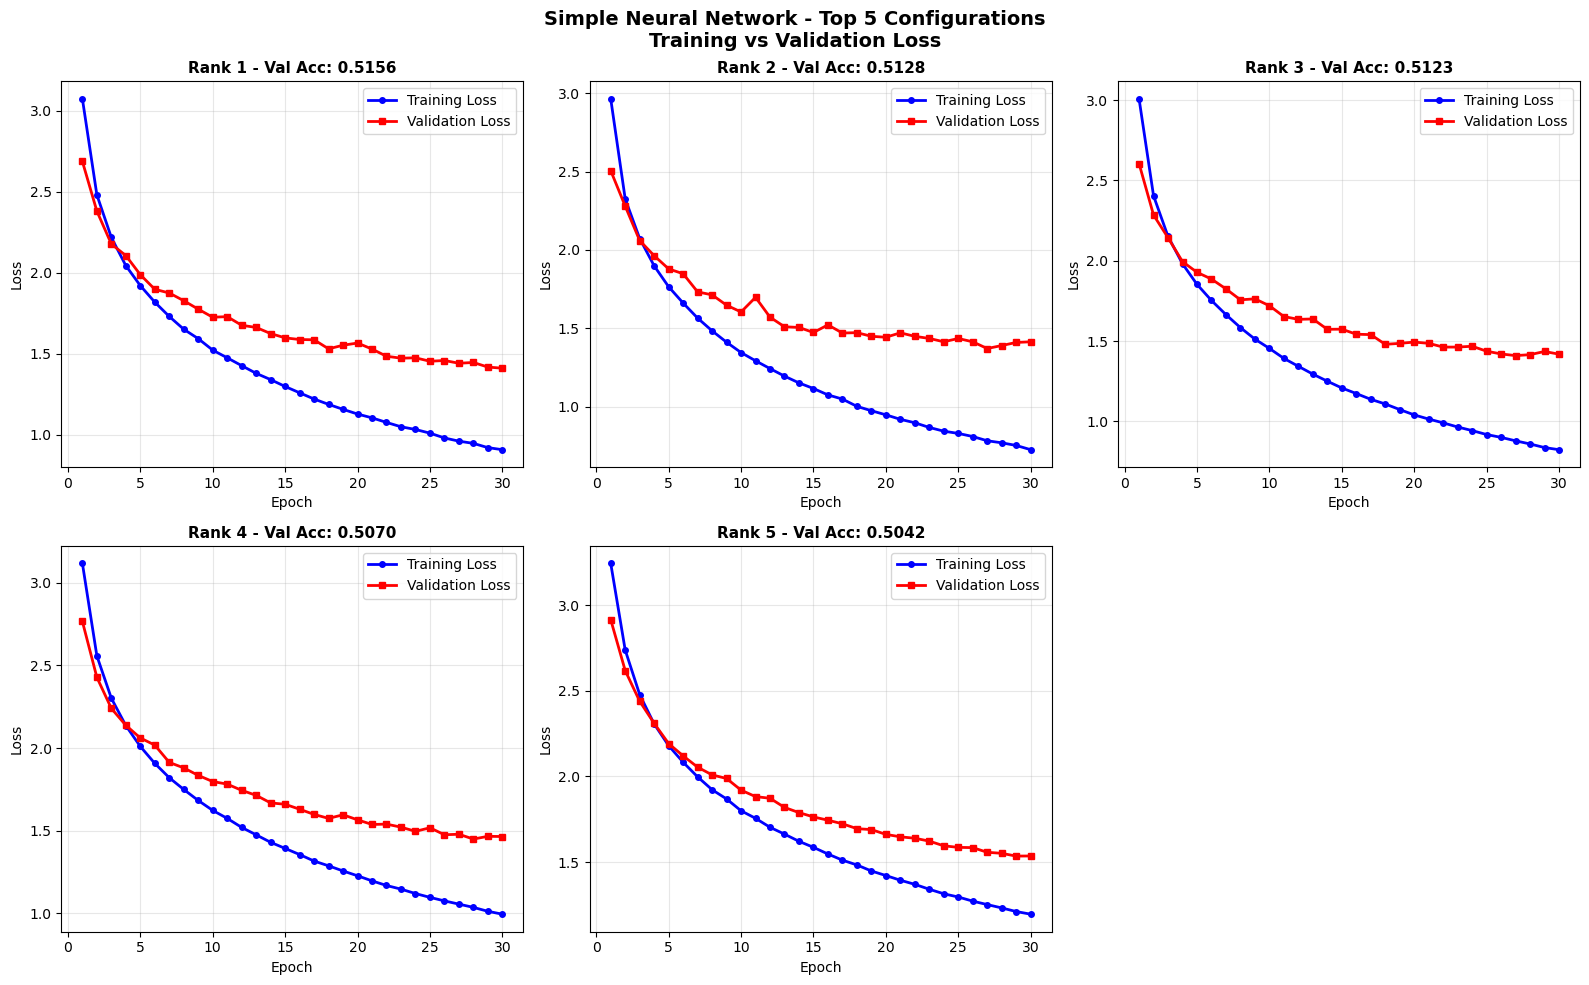

In [6]:
# Plot validation loss curves for top 5
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Simple Neural Network - Top 5 Configurations\nTraining vs Validation Loss', 
             fontsize=14, fontweight='bold')

for idx, history in enumerate(top5_histories):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    
    rank = idx + 1
    val_acc = simplenn_top5.iloc[idx]['Val_Acc']
    ax.set_title(f'Rank {rank} - Val Acc: {val_acc:.4f}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig('simplenn_validation_loss_curves.png', dpi=300, bbox_inches='tight')
print("✓ Loss curves plot saved as 'simplenn_validation_loss_curves.png'")
plt.show()

## 5. Save Results

In [7]:
# Create results directory
results_dir = 'simplenn_results'
os.makedirs(results_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("\n" + "="*80)
print("SAVING RESULTS".center(80))
print("="*80)

# 1. Save summary CSV with all results
simplenn_results['summary_df'].to_csv(f'{results_dir}/all_results_{timestamp}.csv', index=False)
print(f"✓ All results saved to: all_results_{timestamp}.csv")

# 2. Save top 5 CSV
simplenn_top5.to_csv(f'{results_dir}/top5_results_{timestamp}.csv', index=False)
print(f"✓ Top 5 results saved to: top5_results_{timestamp}.csv")

# 3. Save best model info
best_model_info = {
    'best_params': simplenn_results['best_params'],
    'best_val_acc': float(simplenn_results['best_val_acc']),
    'best_test_acc': float(simplenn_results['best_test_acc']),
}

with open(f'{results_dir}/best_model_{timestamp}.json', 'w') as f:
    json.dump(best_model_info, f, indent=4, default=str)
print(f"✓ Best model info saved to: best_model_{timestamp}.json")

# 4. Save best model itself
torch.save(simplenn_results['best_model'].state_dict(), 
           f'{results_dir}/best_model_weights_{timestamp}.pt')
print(f"✓ Best model weights saved to: best_model_weights_{timestamp}.pt")

# 5. Save training history for best model
with open(f'{results_dir}/best_model_history_{timestamp}.pkl', 'wb') as f:
    pickle.dump(simplenn_results['best_history'], f)
print(f"✓ Best model training history saved to: best_model_history_{timestamp}.pkl")

# 6. Save training histories for top 5
for i, history in enumerate(top5_histories, 1):
    with open(f'{results_dir}/rank_{i:02d}_history_{timestamp}.pkl', 'wb') as f:
        pickle.dump(history, f)
print(f"✓ Top 5 training histories saved")

# 7. Save loss curves data as CSV for easy access
for i, history in enumerate(top5_histories, 1):
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(history['train_loss']) + 1),
        'Train_Loss': history['train_loss'],
        'Val_Loss': history['val_loss'],
        'Train_Acc': history['train_acc'],
        'Val_Acc': history['val_acc'],
    })
    loss_df.to_csv(f'{results_dir}/rank_{i:02d}_loss_curves_{timestamp}.csv', index=False)
print(f"✓ Loss curves data saved as CSV for all top 5")

# 8. Save summary report
summary = {
    'model': 'SimpleNN',
    'timestamp': timestamp,
    'total_combinations': int(total_combinations),
    'best_val_accuracy': float(simplenn_results['best_val_acc']),
    'best_test_accuracy': float(simplenn_results['best_test_acc']),
    'best_hyperparameters': simplenn_results['best_params'],
    'top5_accuracies': simplenn_top5['Val_Acc'].tolist(),
}

with open(f'{results_dir}/summary_report_{timestamp}.json', 'w') as f:
    json.dump(summary, f, indent=4, default=str)
print(f"✓ Summary report saved to: summary_report_{timestamp}.json")

print("\n" + "="*80)
print(f"All results saved to: {results_dir}/".center(80))
print("="*80)


                                 SAVING RESULTS                                 
✓ All results saved to: all_results_20251125_213552.csv
✓ Top 5 results saved to: top5_results_20251125_213552.csv
✓ Best model info saved to: best_model_20251125_213552.json
✓ Best model weights saved to: best_model_weights_20251125_213552.pt
✓ Best model training history saved to: best_model_history_20251125_213552.pkl
✓ Top 5 training histories saved
✓ Loss curves data saved as CSV for all top 5
✓ Summary report saved to: summary_report_20251125_213552.json

                    All results saved to: simplenn_results/                     


## 6. Results Summary

In [8]:
print("\n" + "="*80)
print("SIMPLE NEURAL NETWORK - TUNING RESULTS SUMMARY".center(80))
print("="*80)

print(f"\nBest Model Performance:")
print(f"  Validation Accuracy: {simplenn_results['best_val_acc']:.4f}")
print(f"  Test Accuracy: {simplenn_results['best_test_acc']:.4f}")

print(f"\nBest Hyperparameters:")
for key, value in simplenn_results['best_params'].items():
    print(f"  {key}: {value}")

print(f"\nTop 5 Validation Accuracies:")
for rank, acc in enumerate(simplenn_top5['Val_Acc'].values, 1):
    print(f"  Rank {rank}: {acc:.4f}")

print(f"\nTotal tuning combinations evaluated: {total_combinations}")
print("\n" + "="*80)


                 SIMPLE NEURAL NETWORK - TUNING RESULTS SUMMARY                 

Best Model Performance:
  Validation Accuracy: 0.5156
  Test Accuracy: 0.5038

Best Hyperparameters:
  learning_rate: 0.001
  batch_size: 128
  num_epochs: 30
  optimizer: adam

Top 5 Validation Accuracies:
  Rank 1: 0.5156
  Rank 2: 0.5128
  Rank 3: 0.5123
  Rank 4: 0.5070
  Rank 5: 0.5042

Total tuning combinations evaluated: 72



## 6. Best Model Evaluation - Classification Report & Confusion Matrix

Loading best model and generating predictions...

✓ Best Model Test Accuracy: 0.5038

                            CLASSIFICATION REPORT - Best SimpleNN Model                             
              precision    recall  f1-score   support

    Class_00     0.5581    0.9600    0.7059       150
    Class_01     0.4351    0.4467    0.4408       150
    Class_02     0.4060    0.8067    0.5402       150
    Class_03     0.3537    0.7333    0.4772       150
    Class_04     0.6154    0.3733    0.4647       150
    Class_05     0.6593    0.5933    0.6246       150
    Class_06     0.6786    0.8261    0.7451        23
    Class_07     0.5723    0.6600    0.6130       150
    Class_08     0.9677    0.9231    0.9449       130
    Class_09     0.5000    0.3533    0.4141       150
    Class_10     0.5537    0.4467    0.4945       150
    Class_11     0.3594    0.6733    0.4687       150
    Class_12     0.5366    0.2933    0.3793       150
    Class_13     0.6667    0.2533    0.3671       150
  

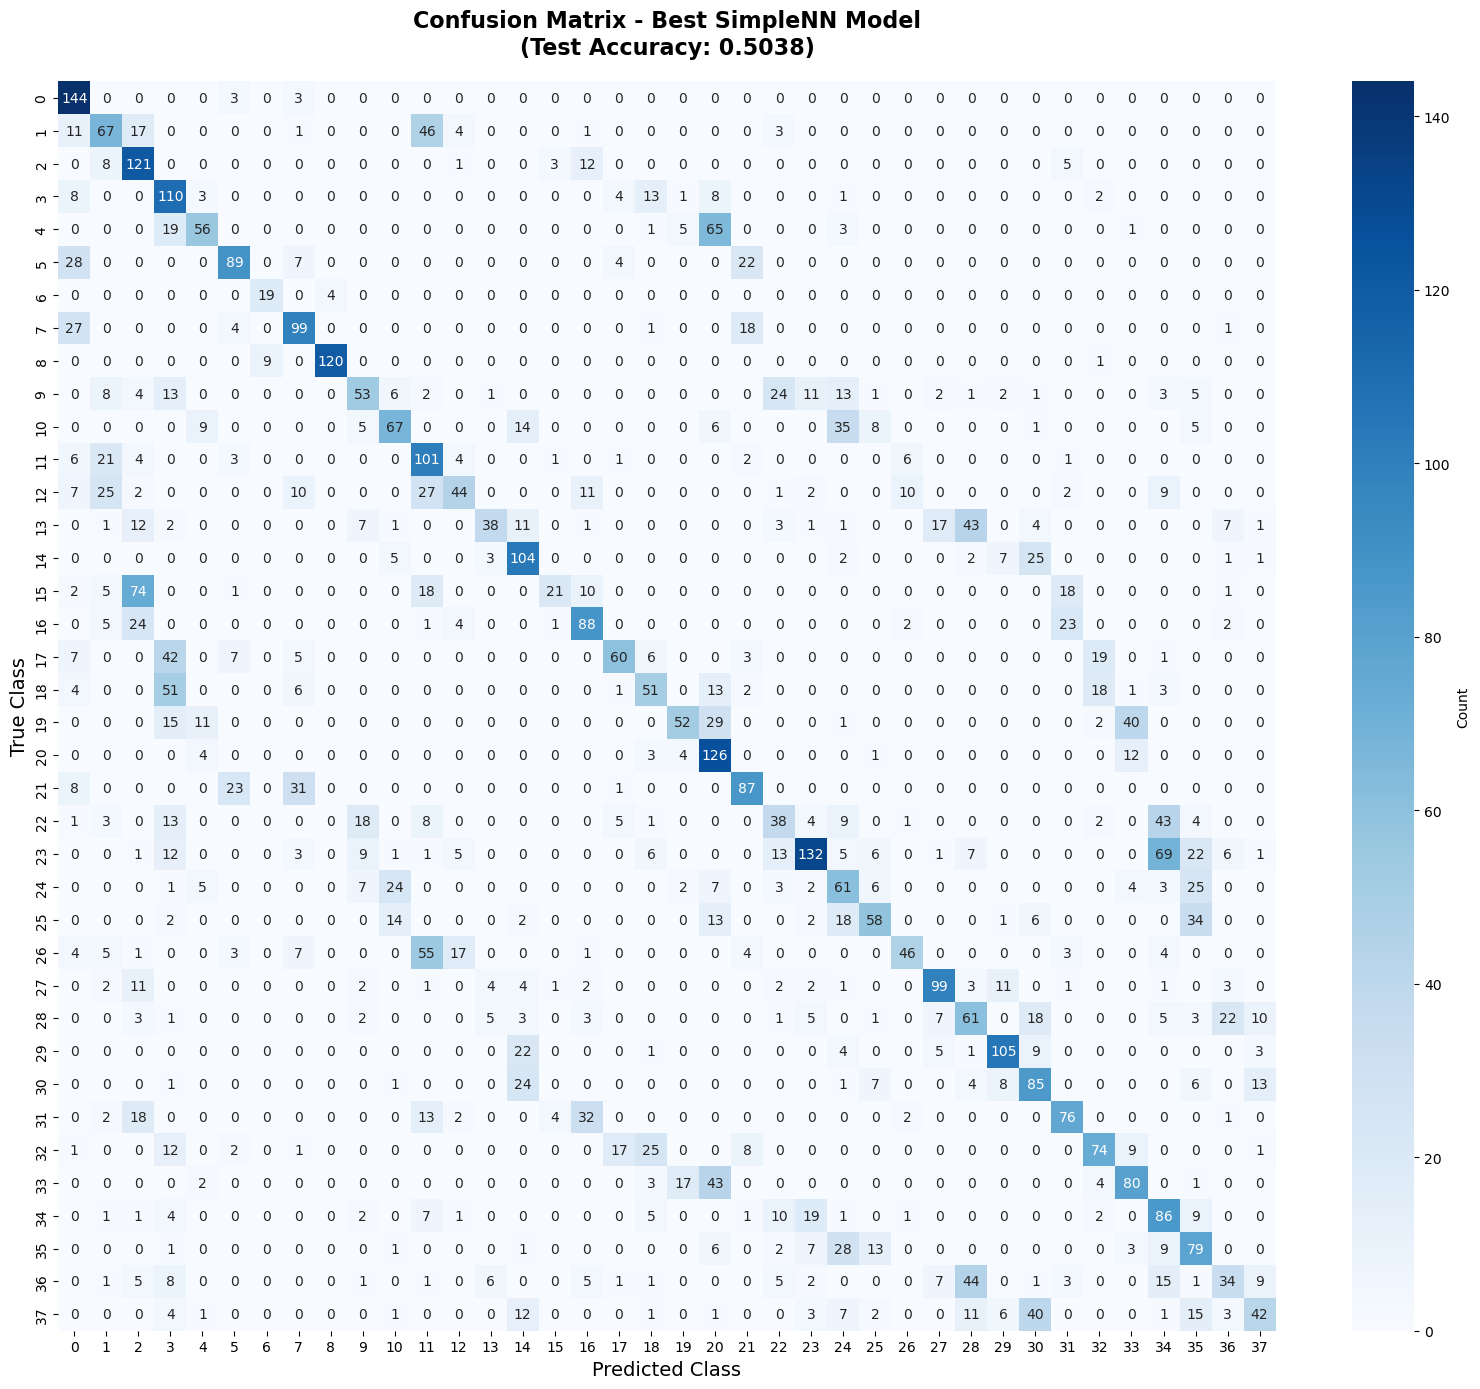

CLASS-WISE PERFORMANCE METRICS:
   Class  Precision   Recall  F1-Score  Support  Accuracy
Class_00   0.558140 0.960000  0.705882      150  0.960000
Class_01   0.435065 0.446667  0.440789      150  0.446667
Class_02   0.406040 0.806667  0.540179      150  0.806667
Class_03   0.353698 0.733333  0.477223      150  0.733333
Class_04   0.615385 0.373333  0.464730      150  0.373333
Class_05   0.659259 0.593333  0.624561      150  0.593333
Class_06   0.678571 0.826087  0.745098       23  0.826087
Class_07   0.572254 0.660000  0.613003      150  0.660000
Class_08   0.967742 0.923077  0.944882      130  0.923077
Class_09   0.500000 0.353333  0.414062      150  0.353333
Class_10   0.553719 0.446667  0.494465      150  0.446667
Class_11   0.359431 0.673333  0.468677      150  0.673333
Class_12   0.536585 0.293333  0.379310      150  0.293333
Class_13   0.666667 0.253333  0.367150      150  0.253333
Class_14   0.527919 0.693333  0.599424      150  0.693333
Class_15   0.677419 0.140000  0.232044  

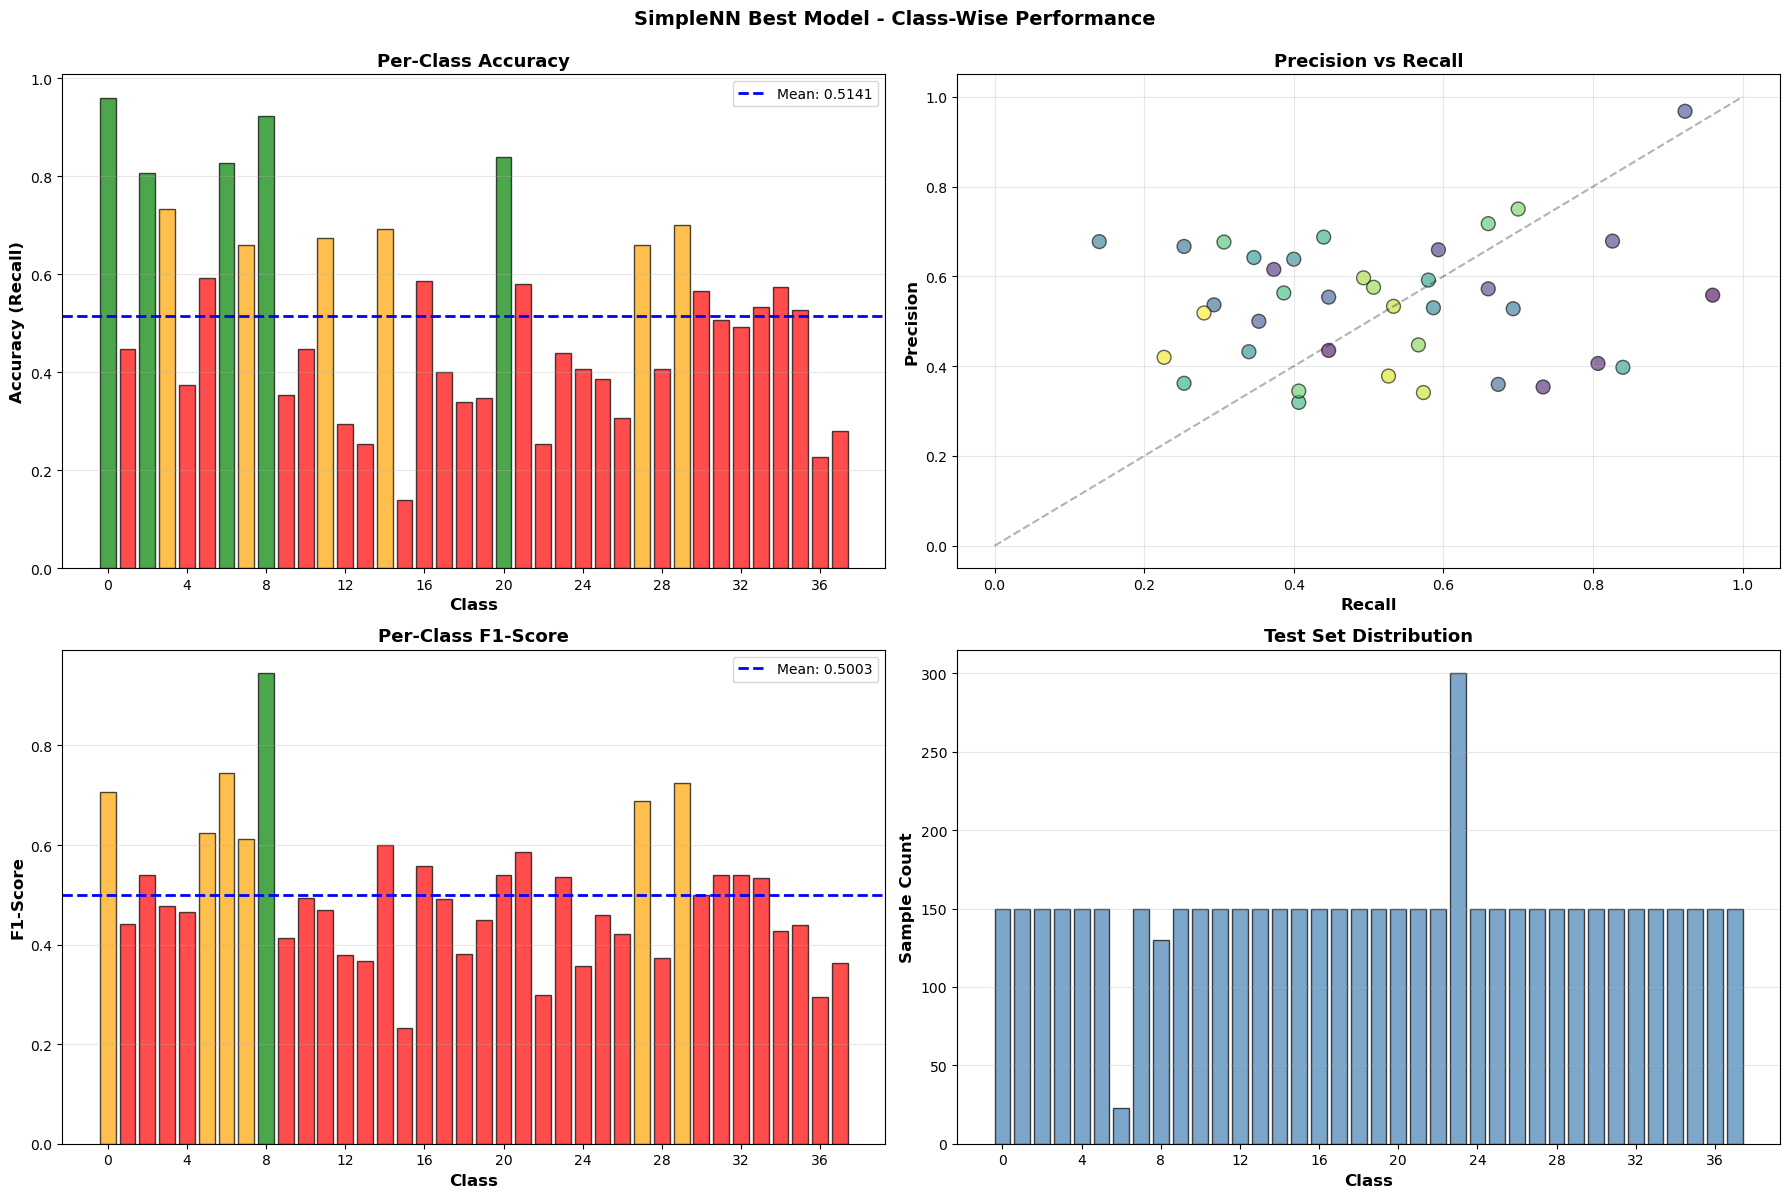

Overall Accuracy: 0.5038
Macro F1-Score: 0.5003


In [9]:
# Load best model and generate predictions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

print("Loading best model and generating predictions...\n")

best_model = simplenn_results['best_model']
best_model.eval()

# Generate predictions on test set
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    outputs = best_model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.cpu().numpy()

test_accuracy = accuracy_score(y_test, predictions)
print(f"✓ Best Model Test Accuracy: {test_accuracy:.4f}\n")

# Generate classification report
class_names = [f'Class_{i:02d}' for i in range(38)]
print("="*100)
print("CLASSIFICATION REPORT - Best SimpleNN Model".center(100))
print("="*100)
report = classification_report(y_test, predictions, target_names=class_names, digits=4)
print(report)

with open(f'{results_dir}/classification_report_{timestamp}.txt', 'w') as f:
    f.write(f"Classification Report - Best SimpleNN Model\n")
    f.write(f"{'='*100}\n\n")
    f.write(report)
print(f"✓ Classification report saved\n")

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
print(f"✓ Confusion matrix computed: shape {cm.shape}")

# Visualize
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=range(38), yticklabels=range(38), cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Best SimpleNN Model\n(Test Accuracy: {:.4f})'.format(test_accuracy),
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.tight_layout()
plt.savefig(f'{results_dir}/confusion_matrix_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix plot saved\n")
plt.show()

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions, average=None)
class_accuracy = recall

class_metrics = pd.DataFrame({
    'Class': [f'Class_{i:02d}' for i in range(38)],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Accuracy': class_accuracy
})

class_metrics.to_csv(f'{results_dir}/class_wise_metrics_{timestamp}.csv', index=False)
print("CLASS-WISE PERFORMANCE METRICS:")
print("="*100)
print(class_metrics.to_string(index=False))
print("="*100)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

ax = axes[0, 0]
colors = ['green' if acc >= 0.8 else 'orange' if acc >= 0.6 else 'red' for acc in class_accuracy]
ax.bar(range(38), class_accuracy, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=class_accuracy.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {class_accuracy.mean():.4f}')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (Recall)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=13, fontweight='bold')
ax.set_xticks(range(0, 38, 4))
ax.legend()
ax.grid(axis='y', alpha=0.3)

ax = axes[0, 1]
ax.scatter(recall, precision, s=100, alpha=0.6, c=range(38), cmap='viridis', edgecolors='black')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision vs Recall', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
colors_f1 = ['green' if f >= 0.8 else 'orange' if f >= 0.6 else 'red' for f in f1]
ax.bar(range(38), f1, color=colors_f1, alpha=0.7, edgecolor='black')
ax.axhline(y=f1.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {f1.mean():.4f}')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score', fontsize=13, fontweight='bold')
ax.set_xticks(range(0, 38, 4))
ax.legend()
ax.grid(axis='y', alpha=0.3)

ax = axes[1, 1]
ax.bar(range(38), support, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
ax.set_title('Test Set Distribution', fontsize=13, fontweight='bold')
ax.set_xticks(range(0, 38, 4))
ax.grid(axis='y', alpha=0.3)

plt.suptitle('SimpleNN Best Model - Class-Wise Performance', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{results_dir}/class_wise_accuracy_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"✓ Class-wise accuracy plots saved\n")
plt.show()

print(f"Overall Accuracy: {test_accuracy:.4f}")
print(f"Macro F1-Score: {f1.mean():.4f}")